In [4]:
'''
Package install helper
These packages need to be installed separately by running the associated line in Anaconda prompt.
'''
# conda install -c conda-forge adjusttext

'\nPackage install helper\nThese packages need to be installed separately by running the associated line in Anaconda prompt.\n'

In [1]:
'''
Program will search for this key string in filenames in relevant data folder to define the set of files for analysis
'''
 
file_target = 'deep_induction'

In [2]:
'''
This module builds a pandas table in tidy format from data contained in plate-reader-exported xlsx files.
The data files should be located in a directory './xlsx/' relative to this code 
(i.e., in a folder named 'xlsx' in the same folder as this code)

The program will also read sample information defined in sheets subsequent to the first, data-containing sheet.
These sheets should be named to correspond exactly to the plate name found on the main data sheet 
(i.e., as found in cells B2, B14, etc.). Plates can be renamed by defining a value in cell A1 on sample-defining sheets.

Sample variables should start in the second row of each sample-defining sheet, with variable names defined in this row.
I believe 'Well', 'Sample', 'Media', and 'Induction' are required variables, 
but other variables should be able to be deleted, renamed, or newly-defined as you wish.
I have not extensively tested this though.

A well can be designated as blank by defining its 'Sample' as 'blank' and deleted from analysis with 'drop'
'''
import warnings
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import copy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from matplotlib import ticker as mticker
import matplotlib
import itertools
from itertools import product

'''
Defining relative location of data to current script and other path variables. 
Data files must be placed in a folder labeled xlsx in the same folder as this script.
'''

absolute_path = Path().absolute()
data_location = os.path.join(absolute_path, 'xlsx/')

'''Setting initial parameters for plotting'''

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['errorbar.capsize'] = 2

'''Defining Induction class for OOP'''

class Induction:
    IND_translate = {'ribose': 'R+', 'IPTG': 'I+', 'cellobiose': 'E+', 'fucose': 'G+', 'fructose': 'F+'}
    inducers = []
    conditions = {}
    
    def __init__(self, string, schedule = 'unscheduled'):
        self.string = string
        self.inducer = self.get_inducer()
        self.TF = Induction.IND_translate[self.inducer]
        self.schedule = schedule
        self.amt, self.unit, self.induced = self.amt_unit()
        self.titer = ' '.join([str(self.amt), self.unit])
        self.inducer_conditions_compile()

            
    def __str__(self):
        return self.string
    
    def __repr__(self):
        if self.schedule != None:
            return ','.join([str(self.amt), self.unit, self.inducer, self.TF, self.schedule])
        else:
            return ','.join([str(self.amt), self.unit, self.inducer, self.TF])
    
    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.string == other.string
    
#     def __ne__(self, other):
#         return self.string != other.string
    
    def __hash__(self):
        return hash(self.string)
    
    def get_inducer(self):
        for inducer in Induction.IND_translate.keys():
            if 'true_inducer' in locals() and inducer in self.string:
                raise ValueError('Currently only allow one inducer')
            elif inducer in self.string:
                true_inducer = inducer
        return true_inducer
        
    def amt_unit(self):
        searchstring = self.string.replace(' ','').replace('_','')
        match = re.search(r'\d+',searchstring)
        
        if match:
            index = match.span()
            amt, unit = float(searchstring[index[0]:index[1]]), searchstring[index[1]:index[1]+2]
        else:
            amt, unit = None, None
            
        if unit == 'uM' or unit == 'µM':
            amt, unit = amt/1000, 'mM'
            
        induced = True
        if amt == 0:
            induced = False
        if self.schedule == '---':
            induced = False
            
        return amt, unit, induced
    
    def inducer_conditions_compile(self):
        if self.inducer not in Induction.inducers:
            Induction.inducers.append(self.inducer)
            Induction.conditions[self.inducer] = [self.titer]
        
        if self.titer not in Induction.conditions[self.inducer]:
            Induction.conditions[self.inducer].append(self.titer)
            
    @classmethod
    def get_all_inducers(cls):
        return cls.inducers

    @classmethod
    def get_all_conditions(cls):
        return cls.conditions


'''Defining helper methods and functions to be used later'''

def rowtrieve(self, column, target):
    return self.loc[self[column] == target]
pd.DataFrame.rowtrieve = rowtrieve

def induction_finder(self, column, target):
    return self.loc[self[column].str.contains(target)]
pd.DataFrame.induction_finder = induction_finder

def inverse_groupby(self, ignore_cols = [], redundant_cols = ['Plate','Experiment'],\
                       always_ignore_cols = ['Mean','StDev','Replicates']):
    column_list = []
    for column in self.columns:
        if column not in list(x for x in (ignore_cols + redundant_cols + always_ignore_cols)) and len(self[column].unique()) != 1:
            column_list.append(column)
    return self.groupby(column_list)
pd.DataFrame.inverse_groupby = inverse_groupby

def HMS_rounder(timestring, unit='min'):
    timestring = str(timestring)
    h,m,s = timestring.split(':')
    h,m,s = (float(val) for val in [h,m,s])
   
    s_round = round(s/60)
    m_round = round((m+s/60)/60)
    
    if unit == 'min':
        return h+(m+s_round)/60
    
    if unit == 'hour':
        return h+m_round

def time_parser(string):
    try:
        return_value = string.hour + string.minute/60 + string.second/3600
        
    except:
        try:
            splitstring = string.split('_')[-1]
            unit = splitstring.lstrip('0123456789')
            value = splitstring[:-len(unit)]

            if unit == 'h':
                return_value = float(value)
            if unit == 'm':
                return_value = float(value)/60
            if unit == 's':
                return_value = float(value)/3600
        except:
            return_value = None

    return return_value

'''
Following functions for Excel import functionalities
'''
def xl_info_gather(file, experiment_title, well_list):
    xlsx = pd.ExcelFile(file)
    try:
        datasheet_name = experiment_title[:31]
        xl_read = pd.read_excel(xlsx, sheet_name=datasheet_name)
    except ValueError:
        datasheet_name = experiment_title.replace('+','^M')[:31]
        xl_read = pd.read_excel(xlsx, sheet_name=datasheet_name)
        
    sample_dicts = pd.read_excel(file, sheet_name=None, header = 1)     
    sample_dicts.pop(datasheet_name)

    temperatures = pd.read_excel(file, sheet_name=None, header = 0, nrows=0)
    temperatures_dict = {key:temperatures[key].columns[0] for key in temperatures}
 
    for key in sample_dicts.keys():
        sample_dicts[key]['Temperature'] = temperatures_dict[key]
        sample_dicts[key]['Plate'] = key   

    export_format = xl_read.iloc[0:1,3:4].values[0][0]
    
    return xlsx, xl_read, sample_dicts, export_format


def kinetic_exporter(xl_read, local_df, sample_dicts):
    header = xl_read.columns[0]
    start_index = xl_read.rowtrieve(header, 'Plate:').index
    end_index = xl_read.rowtrieve(header, '~End').index

    for start, end in zip(start_index,end_index):
        idf = pd.DataFrame(data = xl_read.iloc[start+2:end-1].values, columns = xl_read.iloc[start+1:start+2].values[0])
        sample_vars = [value for value in idf.columns if value not in well_list]
        well_vars = [value for value in idf.columns if value  in well_list]

        idf = pd.melt(idf, id_vars = sample_vars, value_vars = well_vars)
        idf = idf.rename(columns={'Temperature(¡C)': 'Temperature','variable':"Well", 'value':'Value'})

        idf['Temperature'] = idf['Temperature'].mode().values[0]
        idf['Assay'] = xl_read.iat[start, 5]
        idf['Time'] = idf['Time'].apply(HMS_rounder)

        sample_conditions_df = list(sample_dicts.values())[0].copy()
        idf = idf.merge(sample_conditions_df, how = 'inner', on = 'Well')

        local_df = pd.concat([local_df, idf])

    return local_df


def  plate_exporter(xl_read, local_df, sample_dicts):
    global carryover
    
    i=2
    while xl_read.iloc[i-2:i-1,0:1].values[0][0] == 'Plate:':
        plate_name = xl_read.iloc[i-2:i-1,1:2].values[0][0]
        assay = xl_read.iloc[i-2:i-1,5:6].values[0][0]

        if plate_name in sample_dicts.keys():
            sample_conditions_df = sample_dicts[plate_name].copy()

            global sample_carryover
            sample_carryover = copy.deepcopy(sample_dicts)

        elif carryover == True:
            sample_conditions_df = sample_carryover[plate_name].copy()

        elif input('Carry over sample conditions from previous experiment? (y/n)') == 'y':
            sample_conditions_df = sample_carryover[plate_name].copy()

            carryover = True

        else:
            print('datasheet B' + str(i) + ': ' + plate_name)
            raise IndexError('Please ensure plate names as defined in sheet names and in datasheet cells B[2+12x] match')

        data = xl_read.iloc[i:i+8,2:14]

        idf = pd.DataFrame(zip(data.unstack(),well_list), columns = ['Value','Well'])
        idf = idf.merge(sample_conditions_df, how = 'inner', on = 'Well')
        idf['Assay'] = assay

        local_df = pd.concat([local_df, idf])

        i+=12
    
    return local_df
           

'''Wrapper function for possible differences in export format; records each analyzed xlsx file as its own 'Experiment' '''
def raw_data_excel_import(file, well_list, xlsx_file = True):
    
    experiment_title = file.split('\\')[-1].split('.')[0]
    print(experiment_title)

    if xlsx_file == True:
        xlsx, xl_read, sample_dicts, export_format = xl_info_gather(file, experiment_title, well_list)      
        local_df = pd.DataFrame()
        
        if export_format == 'TimeFormat':
            local_df = kinetic_exporter(xl_read, local_df, sample_dicts)

        elif export_format == 'PlateFormat':
            local_df = plate_exporter(xl_read, local_df, sample_dicts)

    local_df['Experiment'] = experiment_title
    
    return local_df


def data_cleaner(df):
    '''Removes wells labeled 'drop' from analysis'''
    df = df.loc[df.loc[df['Sample'].str.strip() != 'drop'].index]
    df_reps = pd.DataFrame()
    
    for group in df.groupby(['Media','Plate','Experiment']):
        media_df = group[1]
        
        '''
        This block removes suspected contaminated blanks before averaging for background subtraction.
        Currently, it uses a statistic of z-score > 2 OD600 value compared to all blanks on the same plate to classify.
        Also drops a blank with OD600 > 0.5.
        Statistical method could be improved.
        '''
        blanks_df = group[1].rowtrieve('Sample','blank')
        abs_df = blanks_df.rowtrieve('Assay','Absorbance')
        contaminated_blanks = abs_df[((stats.zscore(abs_df['Value'])) > 2) | (abs_df['Value'] > 0.5)]['Well']
        
        if len(abs_df.loc[~abs_df['Well'].isin(contaminated_blanks.values)]) == 0:
            raise ValueError('No passable blank wells found')
        elif len(abs_df.loc[~abs_df['Well'].isin(contaminated_blanks.values)]) < 4:
            warnings.warn('Number of passable blank wells is low')
            
        media_df = media_df.loc[~media_df['Well'].isin(contaminated_blanks.values)]
#         plt.figure()
#         sns.histplot(media_df.rowtrieve('Sample','blank').rowtrieve('Assay','Absorbance'))
        '''
        Background subtraction: important that blank wells are labeled 'blank' on the excel sheet. 
        Subtracts different media types separately and performs the calculation independently for each plate. 
        Currently does not treat varying induction conditions in blanks as different.
        '''
        fluor = media_df.rowtrieve('Assay', 'Fluorescence').reset_index(drop=True)
        absor = media_df.rowtrieve('Assay', 'Absorbance').reset_index(drop=True)

        fluor['Value'] = fluor['Value'] - np.mean(fluor.rowtrieve('Sample', 'blank')['Value'])
        absor['Value'] = absor['Value'] - np.mean(absor.rowtrieve('Sample', 'blank')['Value'])

        '''Normalizing fluorescence by OD and concatenating these values back to main df'''
        FLOD_df = fluor.copy()
        FLOD_df['Assay'] = 'Normalized Fluorescence'
        FLOD_df['Value'] = float('nan')
        FLOD_df['Value'] = fluor['Value']/absor['Value']

        df_reps = pd.concat([df_reps, absor, fluor, FLOD_df], ignore_index=True) 
            
    '''Removes blank wells from df after their function to background subtract has been carried out'''
    df_reps = df_reps.loc[df_reps.loc[df_reps['Sample'] != 'blank'].index]

    
    return df_reps


'''Calculates means, standard devations, and replicates for each unique combination of variables'''
def means_stds_calculator(df):
    df_means = pd.DataFrame()
    sample_variables = df.columns.drop(['Value','Well'])

    for group in df.groupby(list(sample_variables.values)):
        sub_df = group[1]
        idf = pd.DataFrame([group[0]], columns = list(sample_variables.values))
        idf['Mean'] = np.mean(sub_df['Value'])
        idf['StDev'] = np.std(sub_df['Value'])
        idf['Replicates'] = len(sub_df.index)

        df_means = pd.concat([df_means, idf])

    return df_means




letters = ['A','B','C','D','E','F','G','H']
numbers = ['1','2','3','4','5','6','7','8','9','10','11','12']
well_list = [str2 + str1 for str1 in numbers for str2 in letters]

df_reps = pd.DataFrame()
carryover = False

'''
raw_data_excel_import function gathers certain variables from xlsx datasheets and pulls on helper functions
to output data into tidy-formatted pandas dataframe, df_reps

Following block iterates through relevant data files and aggregates them all into df_reps, with unique ID by 'Experiment' 
'''
for file in sorted(glob.glob(data_location + '*.xls*'), key = lambda x: int(re.sub('\D', '', x))):
    if '.xlsx' in file and file_target in file:
        df_reps = pd.concat([df_reps, raw_data_excel_import(file, well_list, xlsx_file = True)], ignore_index=True) 
    
    '''
    I tried to get pandas to read xls files directly but some computer jank occurred that I can't solve 
    so for now it's best to just convert files to xlsx.
    '''
    if '.xls' in file and '.xlsx' not in file:
        print('YO HOMIE please do a simple export of your .xls raw data files to .xlsx')
        print('Here\'s the file you need to convert: '+ file)

'''data_cleaner function removes wells labeled 'drop' from analysis, 
performs background subtraction and fluorescence normalization calculations,
and then removes blank wells from dataframe'''
df_reps = data_cleaner(df_reps)


'''means_stds_calculator function builds a df containing mean, standard deviation, and replicates 
for each unique combination of variables found in sample descriptions. Tries to apply and standardize time values.'''
df_means = pd.DataFrame()
df_means = means_stds_calculator(df_reps)
df_means['Time'] = df_means.get('Time', df_means['Experiment'].apply(time_parser))    
df_means = df_means.sort_values(['Time','Sample','Media','Temperature','Induction'])        

if 'Induction schedule' in df_means.columns:
    df_means['Induction'] = df_means.apply(lambda x: Induction(x['Induction'], x['Induction schedule']), axis = 1)
else:
    df_means['Induction'] = df_means.apply(lambda x: Induction(x['Induction']), axis = 1) 

'''Collects a list of inducers based on values in 'Induction' column of df_means. 
Last word of 'Induction' column must correspond to an inducer listed in the IND_translate dictionary.'''
inducers = Induction.get_all_inducers()

print(df_means.rowtrieve('Assay','Normalized Fluorescence'))

20230928_R+_I+_deep_induction_course_12h
20230928_R+_I+_deep_induction_course_16h
Carry over sample conditions from previous experiment? (y/n)y
20230928_R+_I+_deep_induction_course_20h
20230928_R+_I+_deep_induction_course_24h
20230928_R+_I+_deep_induction_course_36h
20230928_R+_I+_deep_induction_course_40h
20230928_R+_I+_deep_induction_course_44h
20230928_R+_I+_deep_induction_course_48h
20230928_R+_I+_deep_induction_course_72h
20230928_R+_I+_deep_induction_course_96h
20230928_R+_I+_deep_induction_course_120h
          Sample       Induction Media Induction schedule  I1   I2   I3  \
0         Psyn14    + 10 mM IPTG    M9                +--  0h  12h  24h   
0         Psyn14    + 10 mM IPTG    M9                ---  0h  12h  24h   
0         Psyn14  + 10 mM ribose    M9                +--  0h  12h  24h   
0         Psyn14  + 10 mM ribose    M9                ---  0h  12h  24h   
0         Psyn14    + 10 mM IPTG    M9                +--  0h  12h  24h   
..           ...             ...   .

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD   + 0 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP   + 0 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        30°C  Plate1   
0            Psyn14    + 10 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P    + 10 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD  + 10 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP  + 10 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        30°C  Plate1   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD   + 0 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP   + 0 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        30°C  Plate1   
0            Psyn14    + 10 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P    + 10 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD  + 10 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP  + 10 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        30°C  Plate1   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD   + 0 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP   + 0 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        30°C  Plate1   
0            Psyn14    + 10 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P    + 10 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD  + 10 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP  + 10 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        30°C  Plate1   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        37°C  Plate7   
0        Psyn14-O1P     + 0 mM IPTG    M9        37°C  Plate7   
0       Psyn14-ObsD   + 0 mM ribose    M9        37°C  Plate5   
0       Psyn14-ObsP     + 0 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymD     + 0 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymP   + 0 mM ribose    M9        37°C  Plate5   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        37°C  Plate5   
0            Psyn14    + 10 mM IPTG    M9        37°C  Plate7   
0        Psyn14-O1P    + 10 mM IPTG    M9        37°C  Plate7   
0       Psyn14-ObsD  + 10 mM ribose    M9        37°C  Plate5   
0       Psyn14-ObsP    + 10 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymD    + 10 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymP  + 10 mM ribose    M9        37°C  Plate5   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        37°C  Plate5   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        37°C  Plate7   
0        Psyn14-O1P     + 0 mM IPTG    M9        37°C  Plate7   
0       Psyn14-ObsD   + 0 mM ribose    M9        37°C  Plate5   
0       Psyn14-ObsP     + 0 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymD     + 0 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymP   + 0 mM ribose    M9        37°C  Plate5   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        37°C  Plate5   
0            Psyn14    + 10 mM IPTG    M9        37°C  Plate7   
0        Psyn14-O1P    + 10 mM IPTG    M9        37°C  Plate7   
0       Psyn14-ObsD  + 10 mM ribose    M9        37°C  Plate5   
0       Psyn14-ObsP    + 10 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymD    + 10 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymP  + 10 mM ribose    M9        37°C  Plate5   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        37°C  Plate5   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        37°C  Plate7   
0        Psyn14-O1P     + 0 mM IPTG    M9        37°C  Plate7   
0       Psyn14-ObsD   + 0 mM ribose    M9        37°C  Plate5   
0       Psyn14-ObsP     + 0 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymD     + 0 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymP   + 0 mM ribose    M9        37°C  Plate5   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        37°C  Plate5   
0            Psyn14    + 10 mM IPTG    M9        37°C  Plate7   
0        Psyn14-O1P    + 10 mM IPTG    M9        37°C  Plate7   
0       Psyn14-ObsD  + 10 mM ribose    M9        37°C  Plate5   
0       Psyn14-ObsP    + 10 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymD    + 10 mM IPTG    M9        37°C  Plate7   
0      Psyn14-OsymP  + 10 mM ribose    M9        37°C  Plate5   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        37°C  Plate5   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG   MSM        30°C  Plate4   
0        Psyn14-O1P     + 0 mM IPTG   MSM        30°C  Plate4   
0       Psyn14-ObsD   + 0 mM ribose   MSM        30°C  Plate2   
0       Psyn14-ObsP     + 0 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymD     + 0 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymP   + 0 mM ribose   MSM        30°C  Plate2   
0  hyspank-ObsD-O1P   + 0 mM ribose   MSM        30°C  Plate2   
0            Psyn14    + 10 mM IPTG   MSM        30°C  Plate4   
0        Psyn14-O1P    + 10 mM IPTG   MSM        30°C  Plate4   
0       Psyn14-ObsD  + 10 mM ribose   MSM        30°C  Plate2   
0       Psyn14-ObsP    + 10 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymD    + 10 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymP  + 10 mM ribose   MSM        30°C  Plate2   
0  hyspank-ObsD-O1P  + 10 mM ribose   MSM        30°C  Plate2   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG   MSM        30°C  Plate4   
0        Psyn14-O1P     + 0 mM IPTG   MSM        30°C  Plate4   
0       Psyn14-ObsD   + 0 mM ribose   MSM        30°C  Plate2   
0       Psyn14-ObsP     + 0 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymD     + 0 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymP   + 0 mM ribose   MSM        30°C  Plate2   
0  hyspank-ObsD-O1P   + 0 mM ribose   MSM        30°C  Plate2   
0            Psyn14    + 10 mM IPTG   MSM        30°C  Plate4   
0        Psyn14-O1P    + 10 mM IPTG   MSM        30°C  Plate4   
0       Psyn14-ObsD  + 10 mM ribose   MSM        30°C  Plate2   
0       Psyn14-ObsP    + 10 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymD    + 10 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymP  + 10 mM ribose   MSM        30°C  Plate2   
0  hyspank-ObsD-O1P  + 10 mM ribose   MSM        30°C  Plate2   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG   MSM        30°C  Plate4   
0        Psyn14-O1P     + 0 mM IPTG   MSM        30°C  Plate4   
0       Psyn14-ObsD   + 0 mM ribose   MSM        30°C  Plate2   
0       Psyn14-ObsP     + 0 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymD     + 0 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymP   + 0 mM ribose   MSM        30°C  Plate2   
0  hyspank-ObsD-O1P   + 0 mM ribose   MSM        30°C  Plate2   
0            Psyn14    + 10 mM IPTG   MSM        30°C  Plate4   
0        Psyn14-O1P    + 10 mM IPTG   MSM        30°C  Plate4   
0       Psyn14-ObsD  + 10 mM ribose   MSM        30°C  Plate2   
0       Psyn14-ObsP    + 10 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymD    + 10 mM IPTG   MSM        30°C  Plate4   
0      Psyn14-OsymP  + 10 mM ribose   MSM        30°C  Plate2   
0  hyspank-ObsD-O1P  + 10 mM ribose   MSM        30°C  Plate2   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG   MSM        37°C  Plate8   
0        Psyn14-O1P     + 0 mM IPTG   MSM        37°C  Plate8   
0       Psyn14-ObsD   + 0 mM ribose   MSM        37°C  Plate6   
0       Psyn14-ObsP     + 0 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymD     + 0 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymP   + 0 mM ribose   MSM        37°C  Plate6   
0  hyspank-ObsD-O1P   + 0 mM ribose   MSM        37°C  Plate6   
0            Psyn14    + 10 mM IPTG   MSM        37°C  Plate8   
0        Psyn14-O1P    + 10 mM IPTG   MSM        37°C  Plate8   
0       Psyn14-ObsD  + 10 mM ribose   MSM        37°C  Plate6   
0       Psyn14-ObsP    + 10 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymD    + 10 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymP  + 10 mM ribose   MSM        37°C  Plate6   
0  hyspank-ObsD-O1P  + 10 mM ribose   MSM        37°C  Plate6   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG   MSM        37°C  Plate8   
0        Psyn14-O1P     + 0 mM IPTG   MSM        37°C  Plate8   
0       Psyn14-ObsD   + 0 mM ribose   MSM        37°C  Plate6   
0       Psyn14-ObsP     + 0 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymD     + 0 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymP   + 0 mM ribose   MSM        37°C  Plate6   
0  hyspank-ObsD-O1P   + 0 mM ribose   MSM        37°C  Plate6   
0            Psyn14    + 10 mM IPTG   MSM        37°C  Plate8   
0        Psyn14-O1P    + 10 mM IPTG   MSM        37°C  Plate8   
0       Psyn14-ObsD  + 10 mM ribose   MSM        37°C  Plate6   
0       Psyn14-ObsP    + 10 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymD    + 10 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymP  + 10 mM ribose   MSM        37°C  Plate6   
0  hyspank-ObsD-O1P  + 10 mM ribose   MSM        37°C  Plate6   

                     Ass

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG   MSM        37°C  Plate8   
0        Psyn14-O1P     + 0 mM IPTG   MSM        37°C  Plate8   
0       Psyn14-ObsD   + 0 mM ribose   MSM        37°C  Plate6   
0       Psyn14-ObsP     + 0 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymD     + 0 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymP   + 0 mM ribose   MSM        37°C  Plate6   
0  hyspank-ObsD-O1P   + 0 mM ribose   MSM        37°C  Plate6   
0            Psyn14    + 10 mM IPTG   MSM        37°C  Plate8   
0        Psyn14-O1P    + 10 mM IPTG   MSM        37°C  Plate8   
0       Psyn14-ObsD  + 10 mM ribose   MSM        37°C  Plate6   
0       Psyn14-ObsP    + 10 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymD    + 10 mM IPTG   MSM        37°C  Plate8   
0      Psyn14-OsymP  + 10 mM ribose   MSM        37°C  Plate6   
0  hyspank-ObsD-O1P  + 10 mM ribose   MSM        37°C  Plate6   

                     Ass

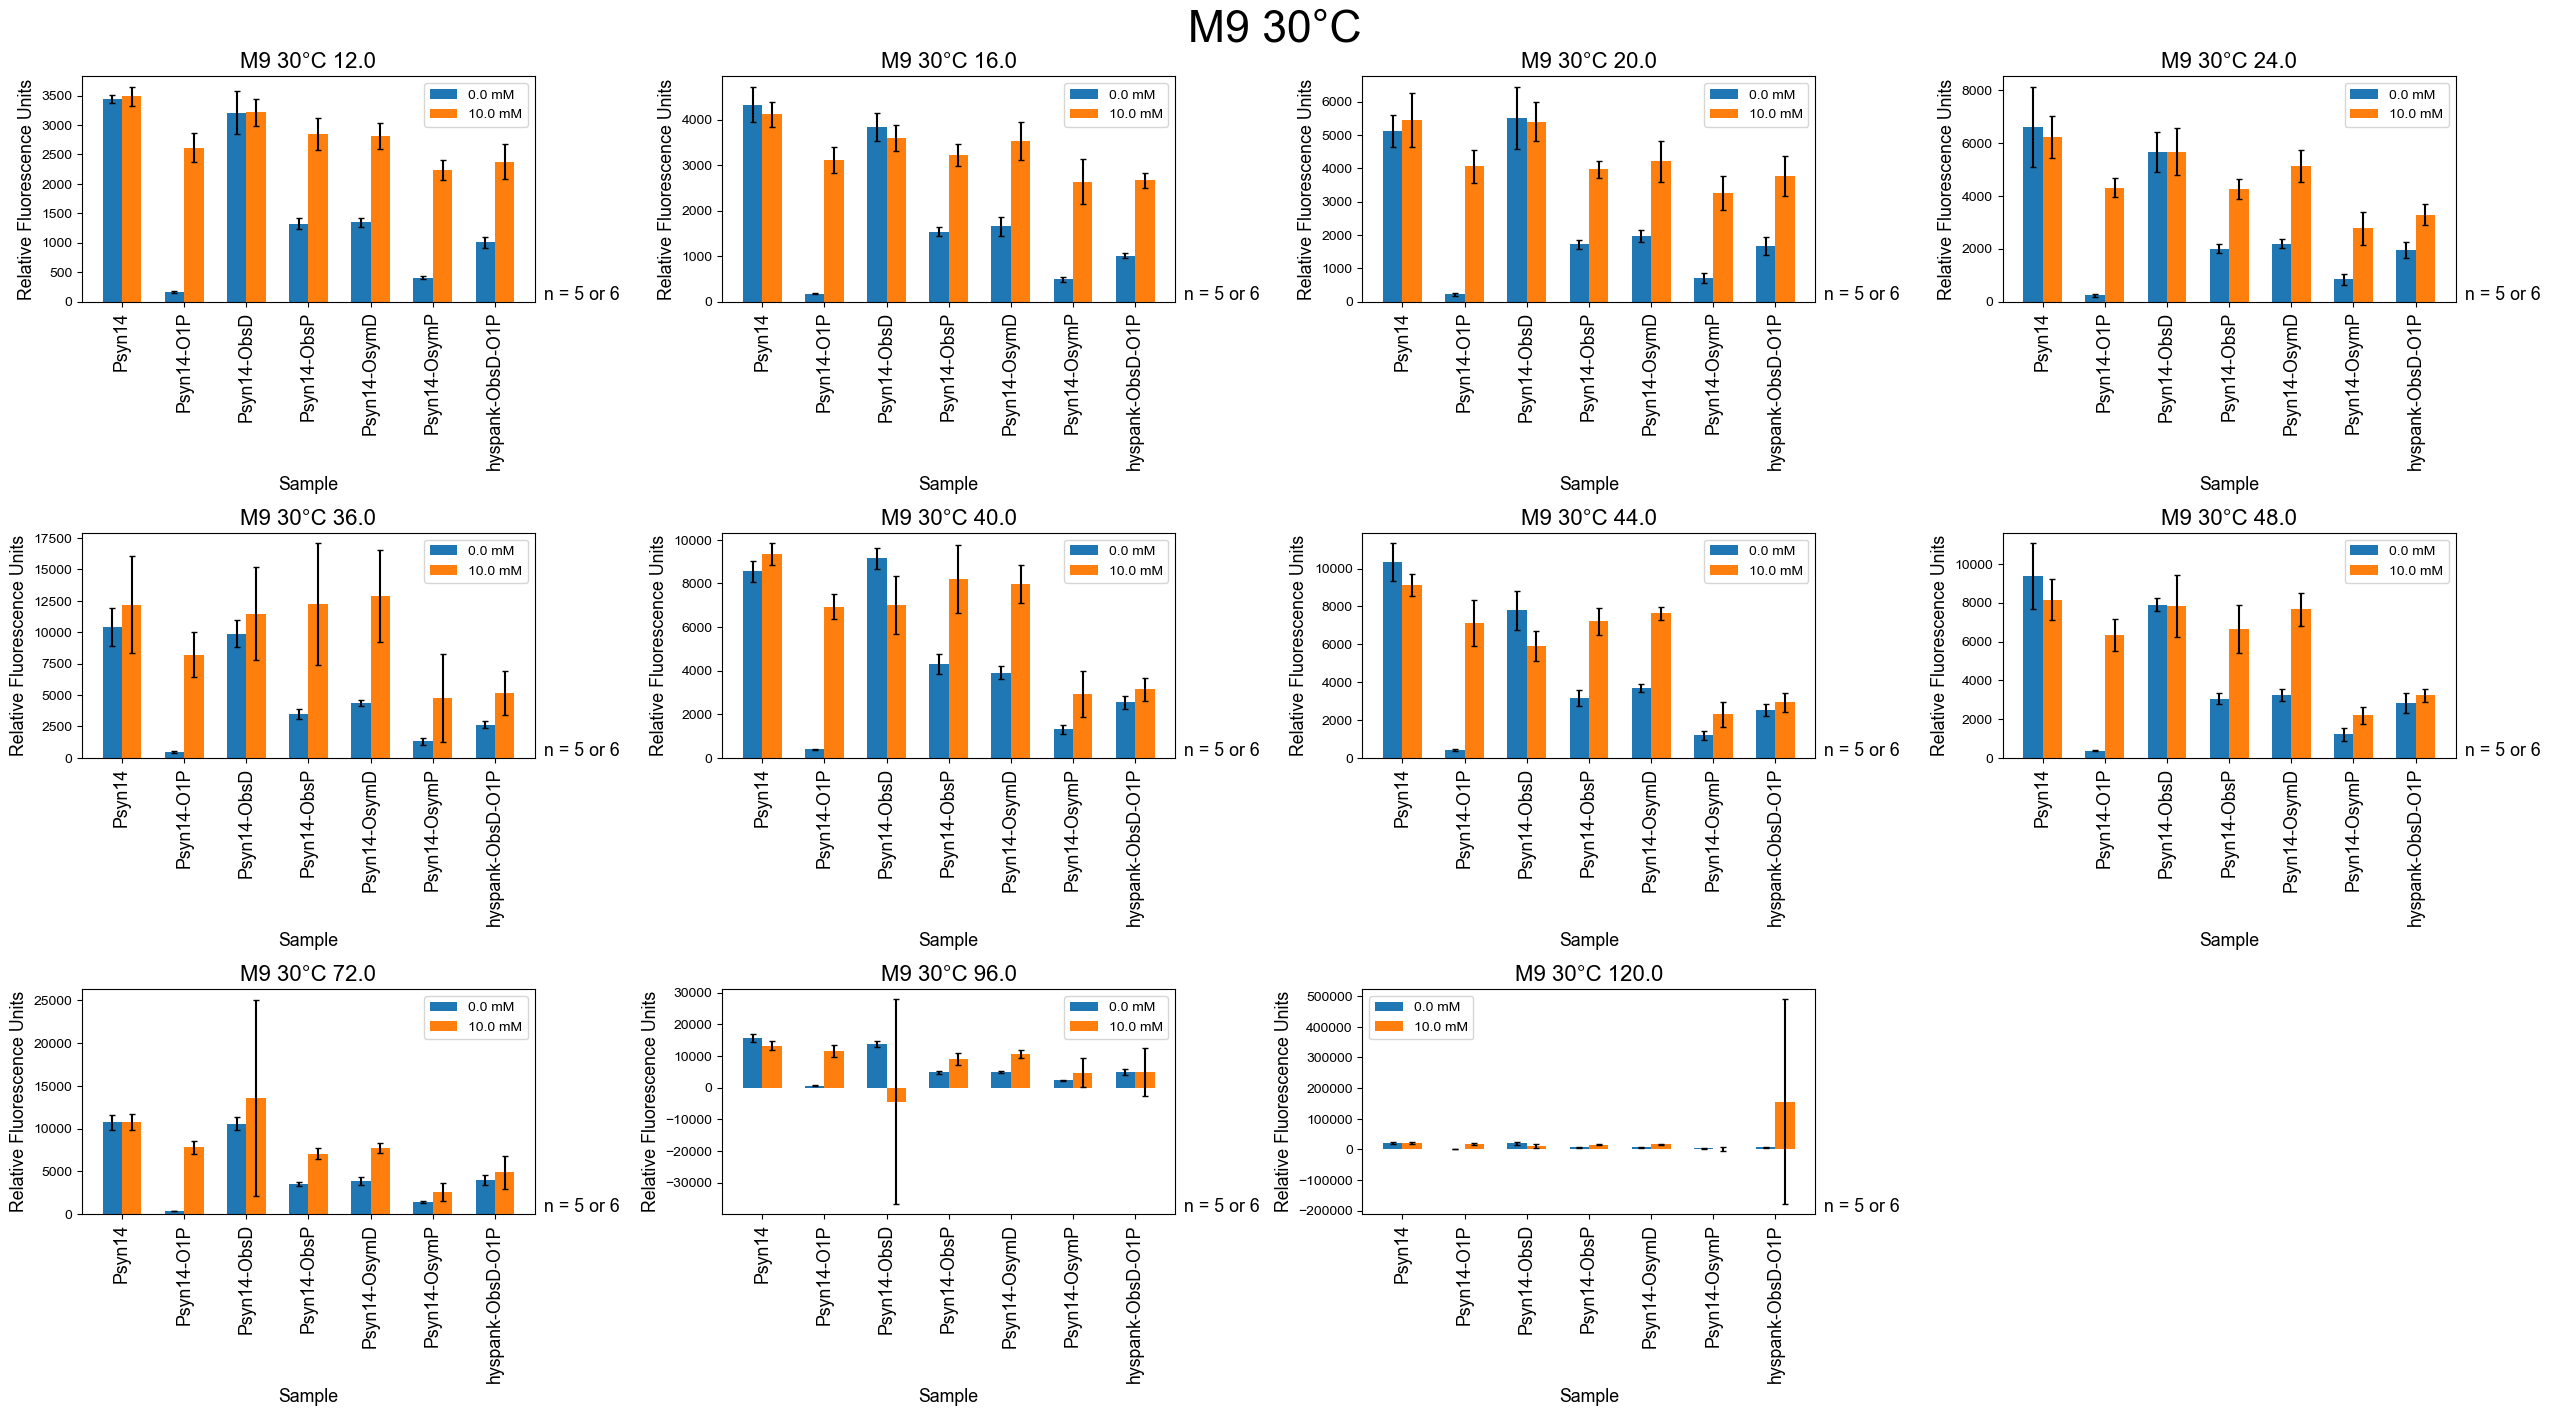

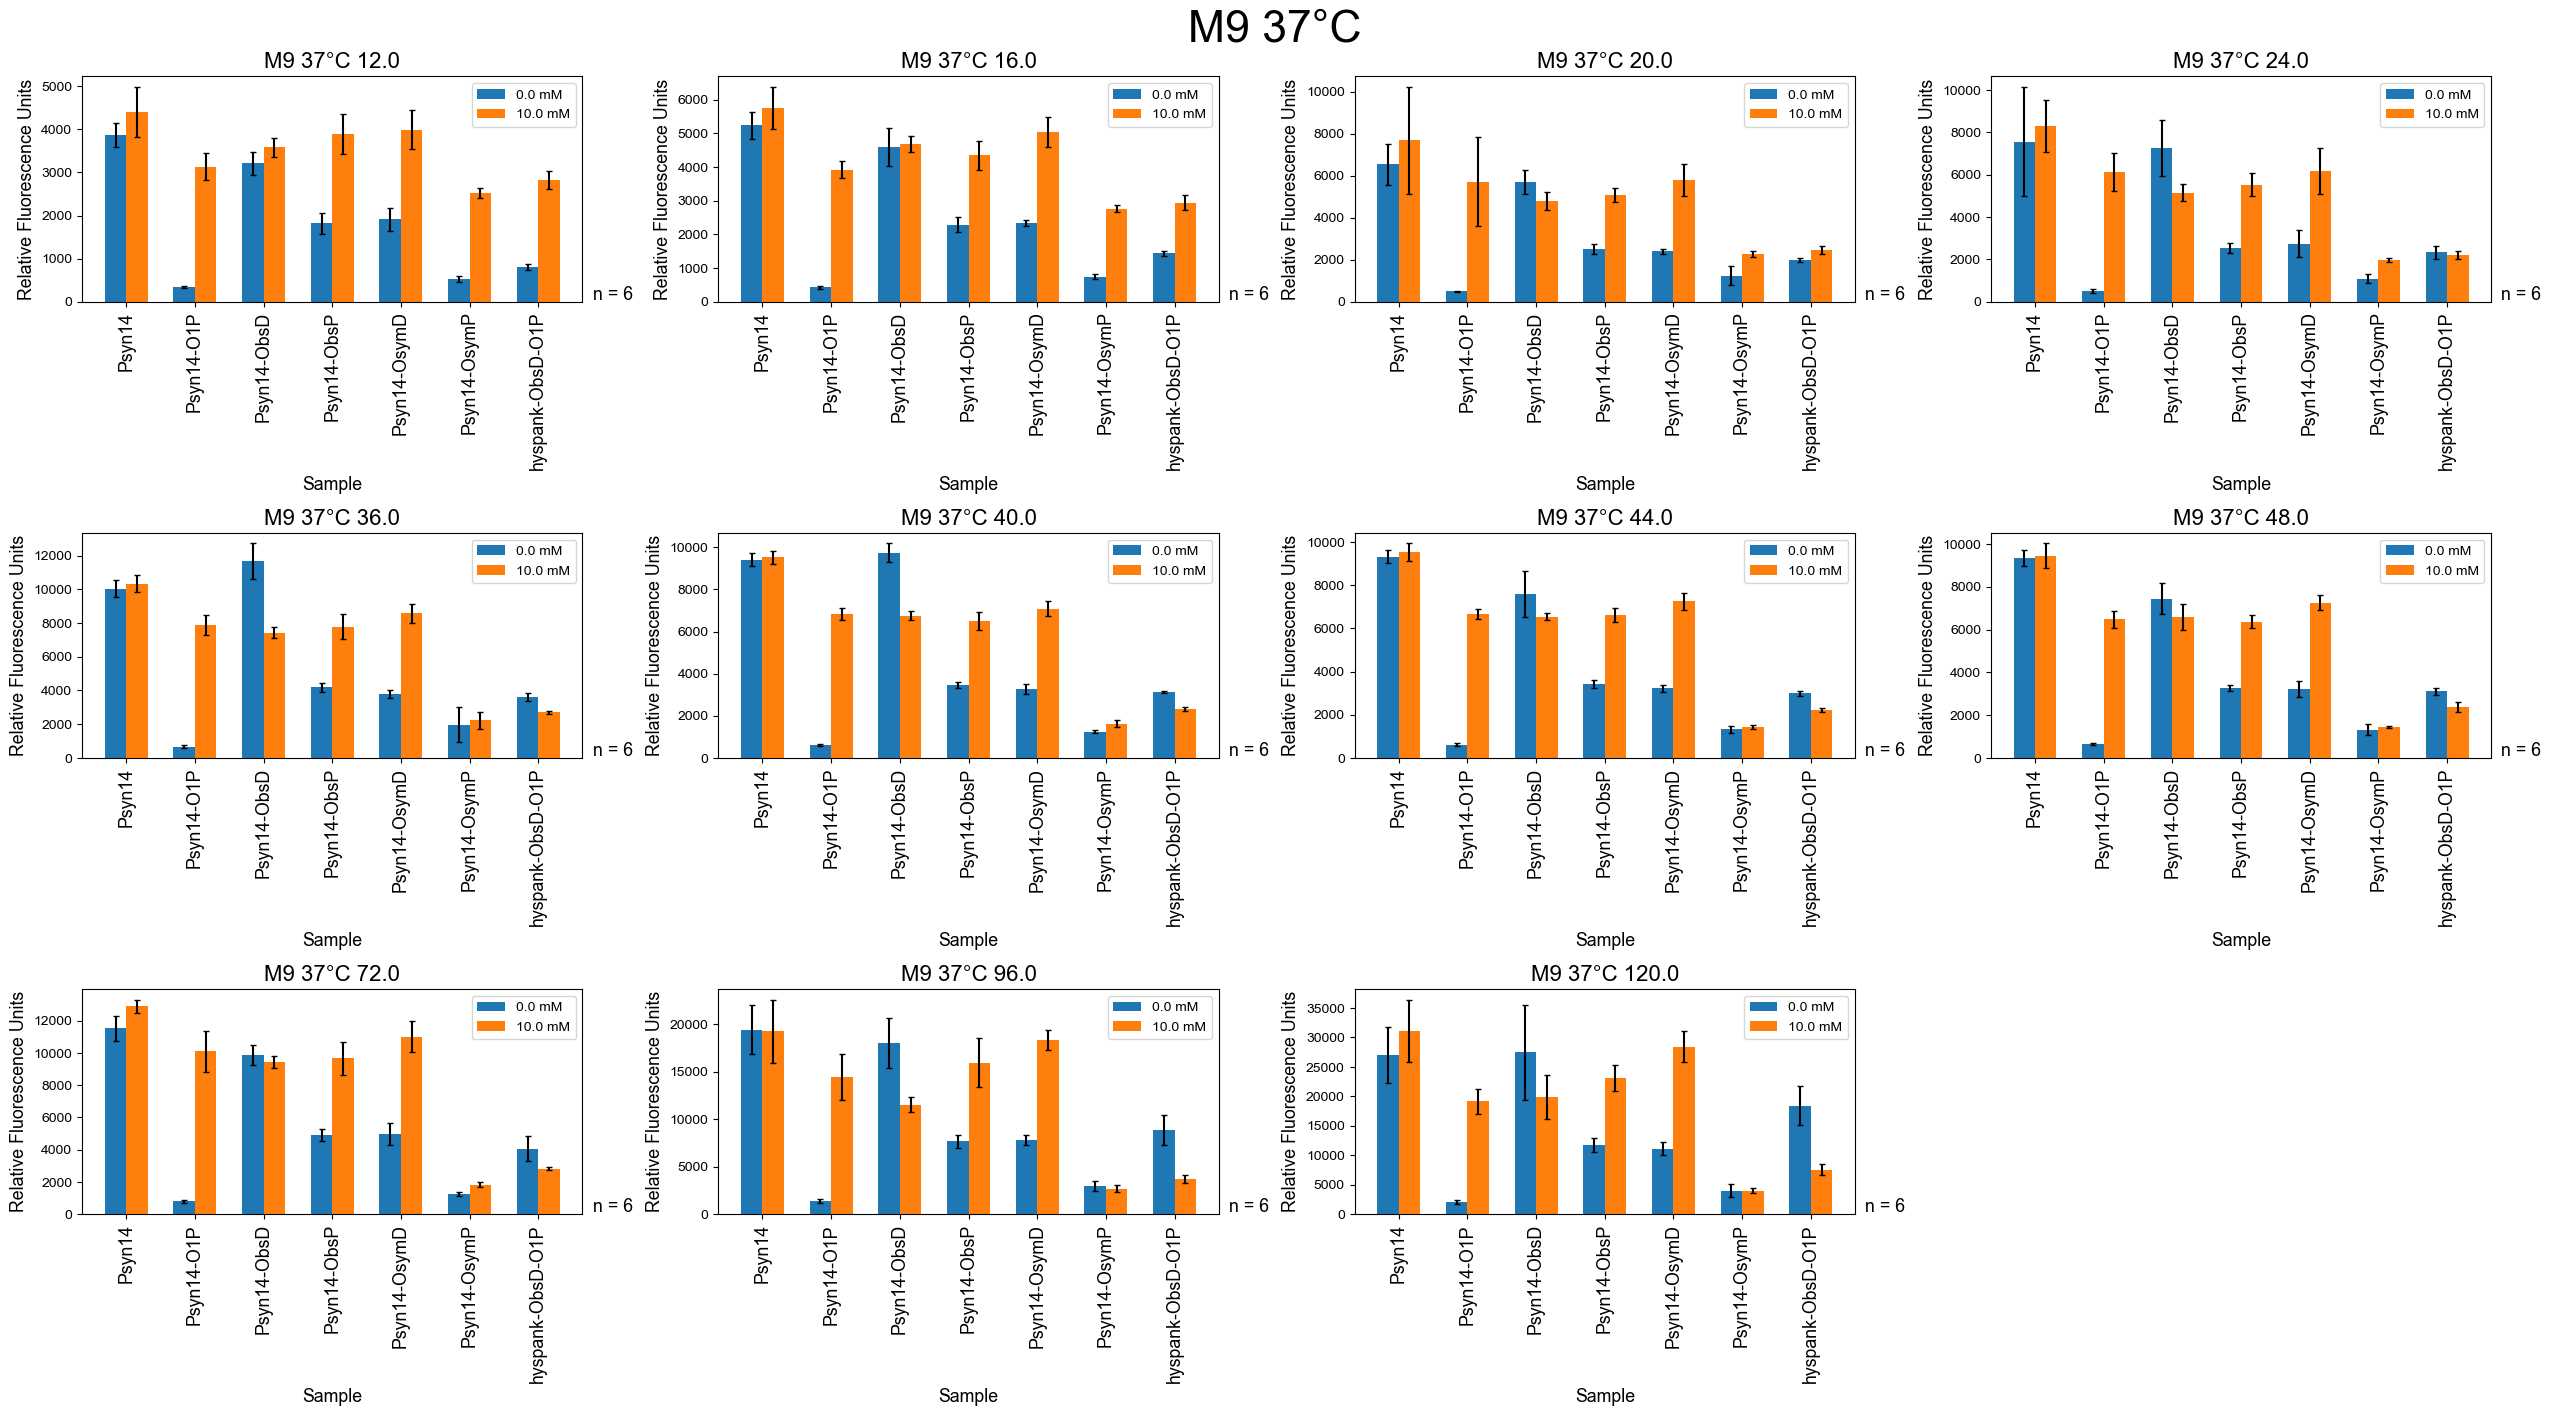

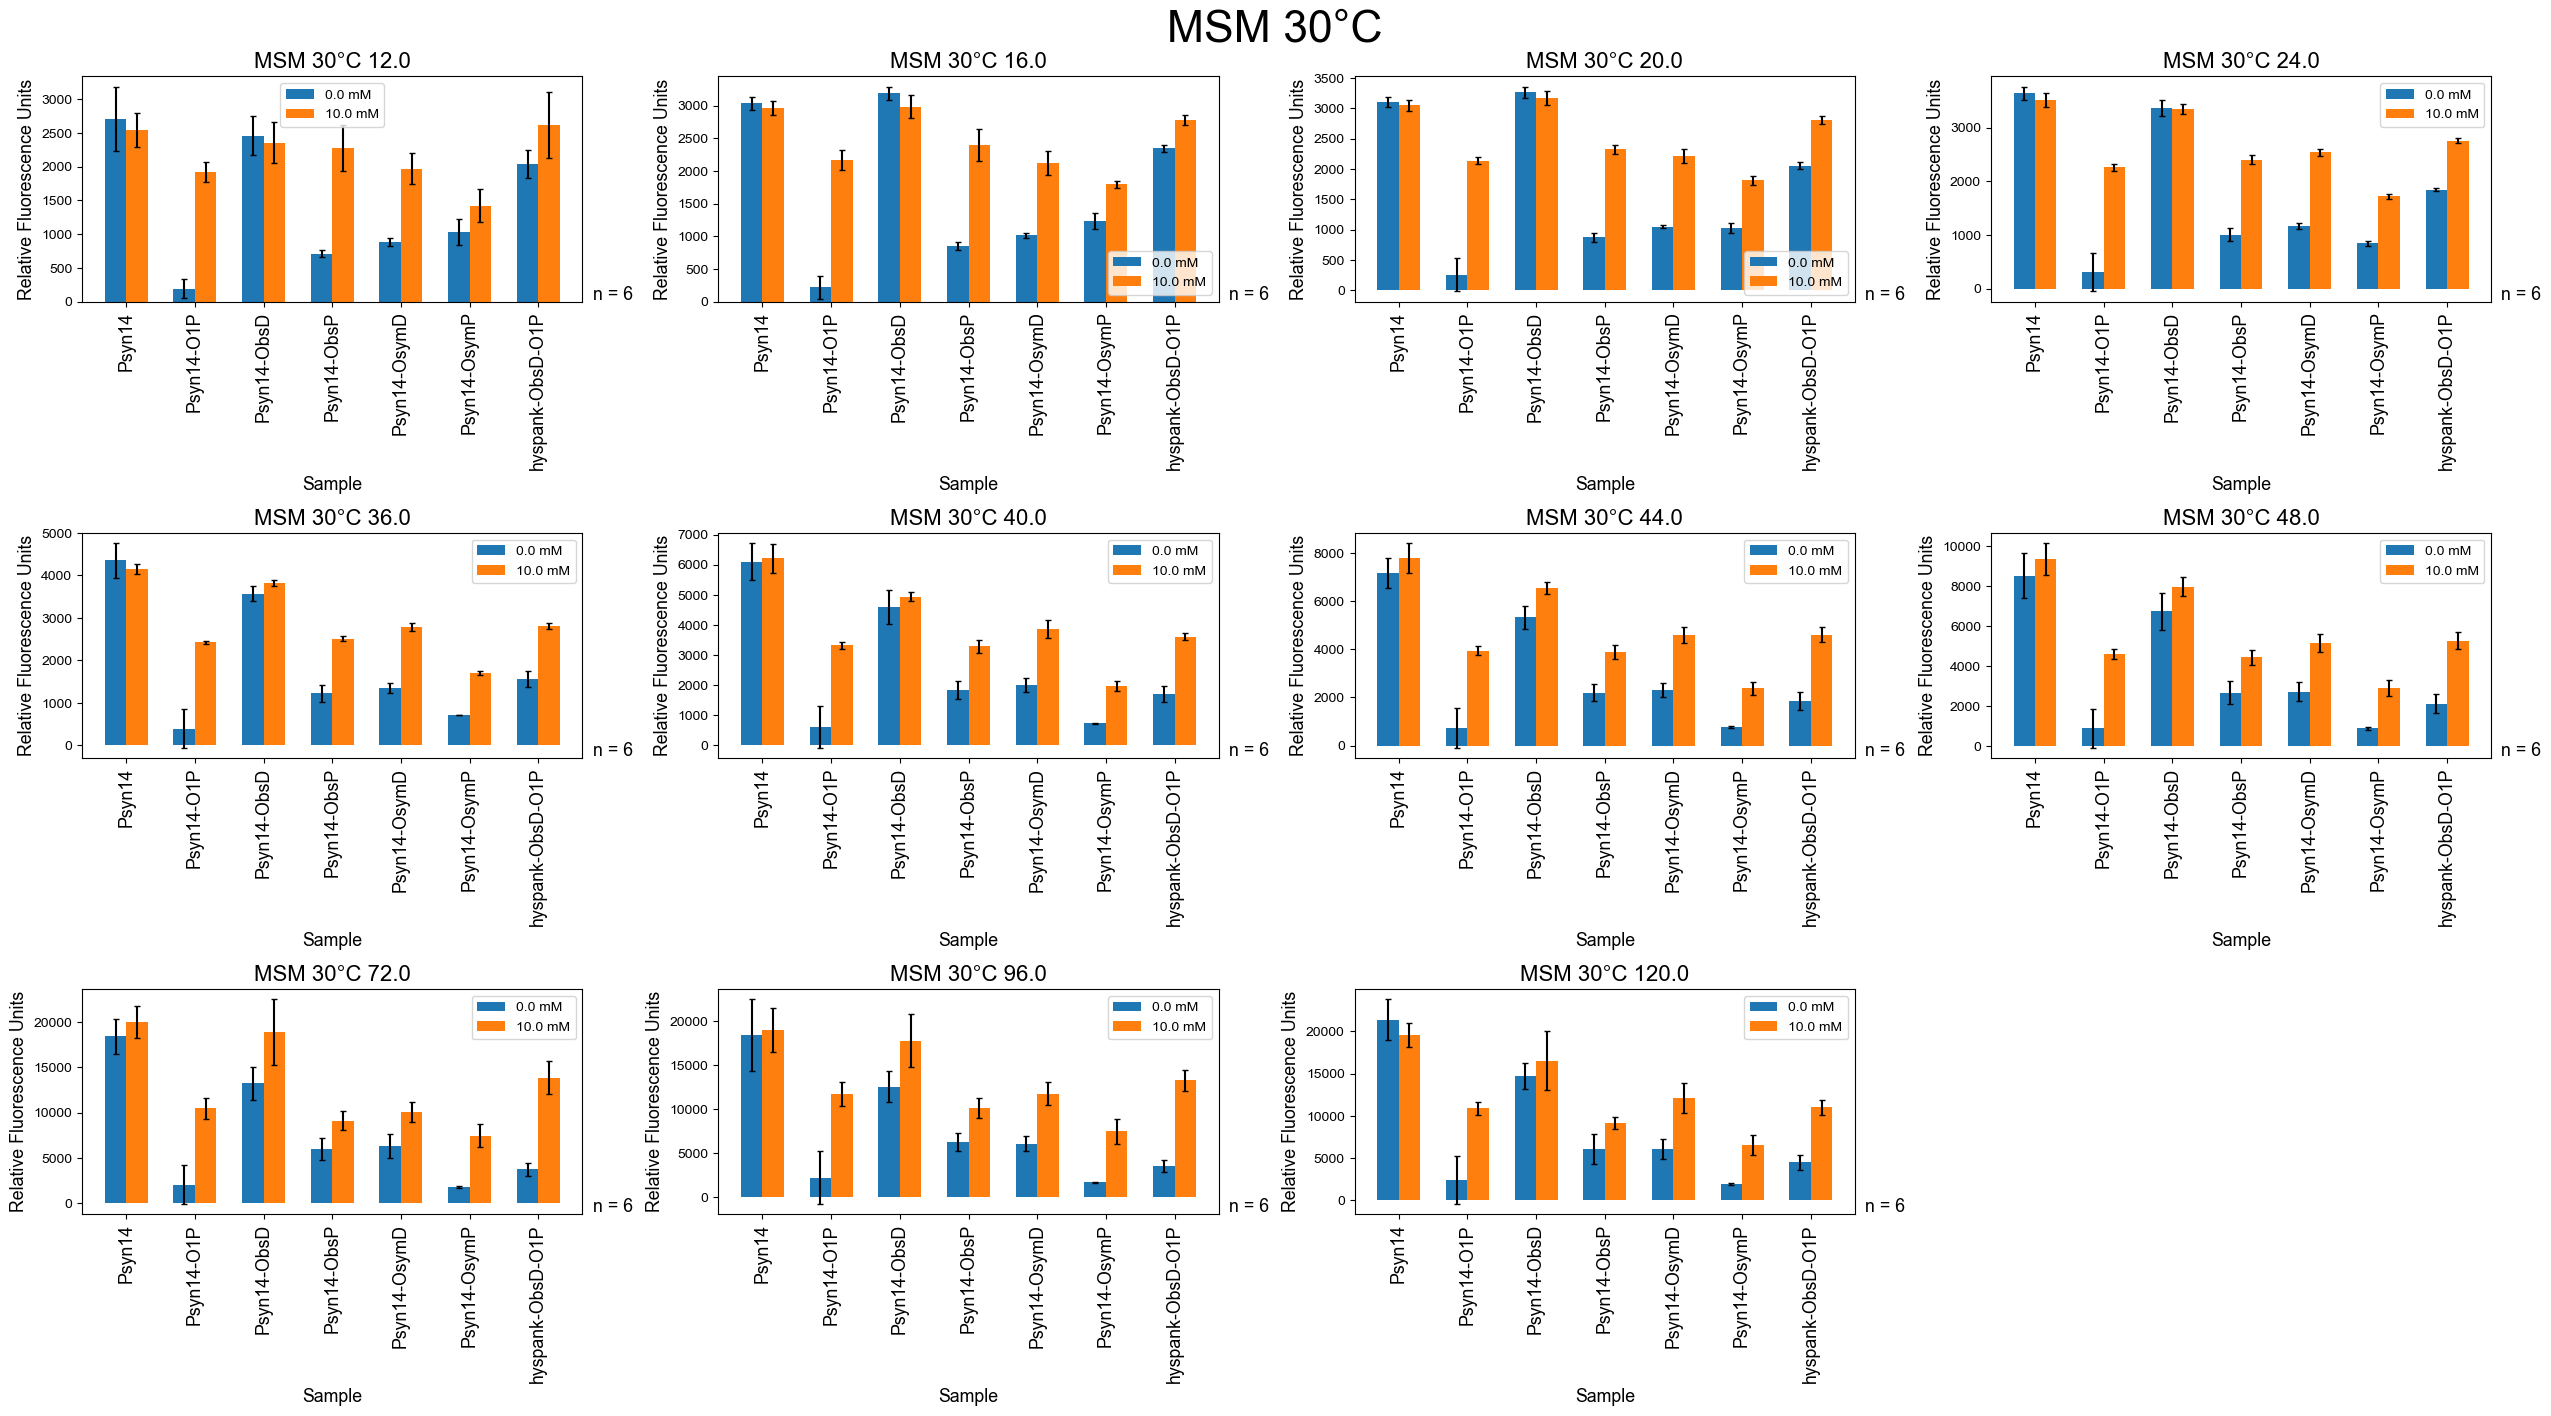

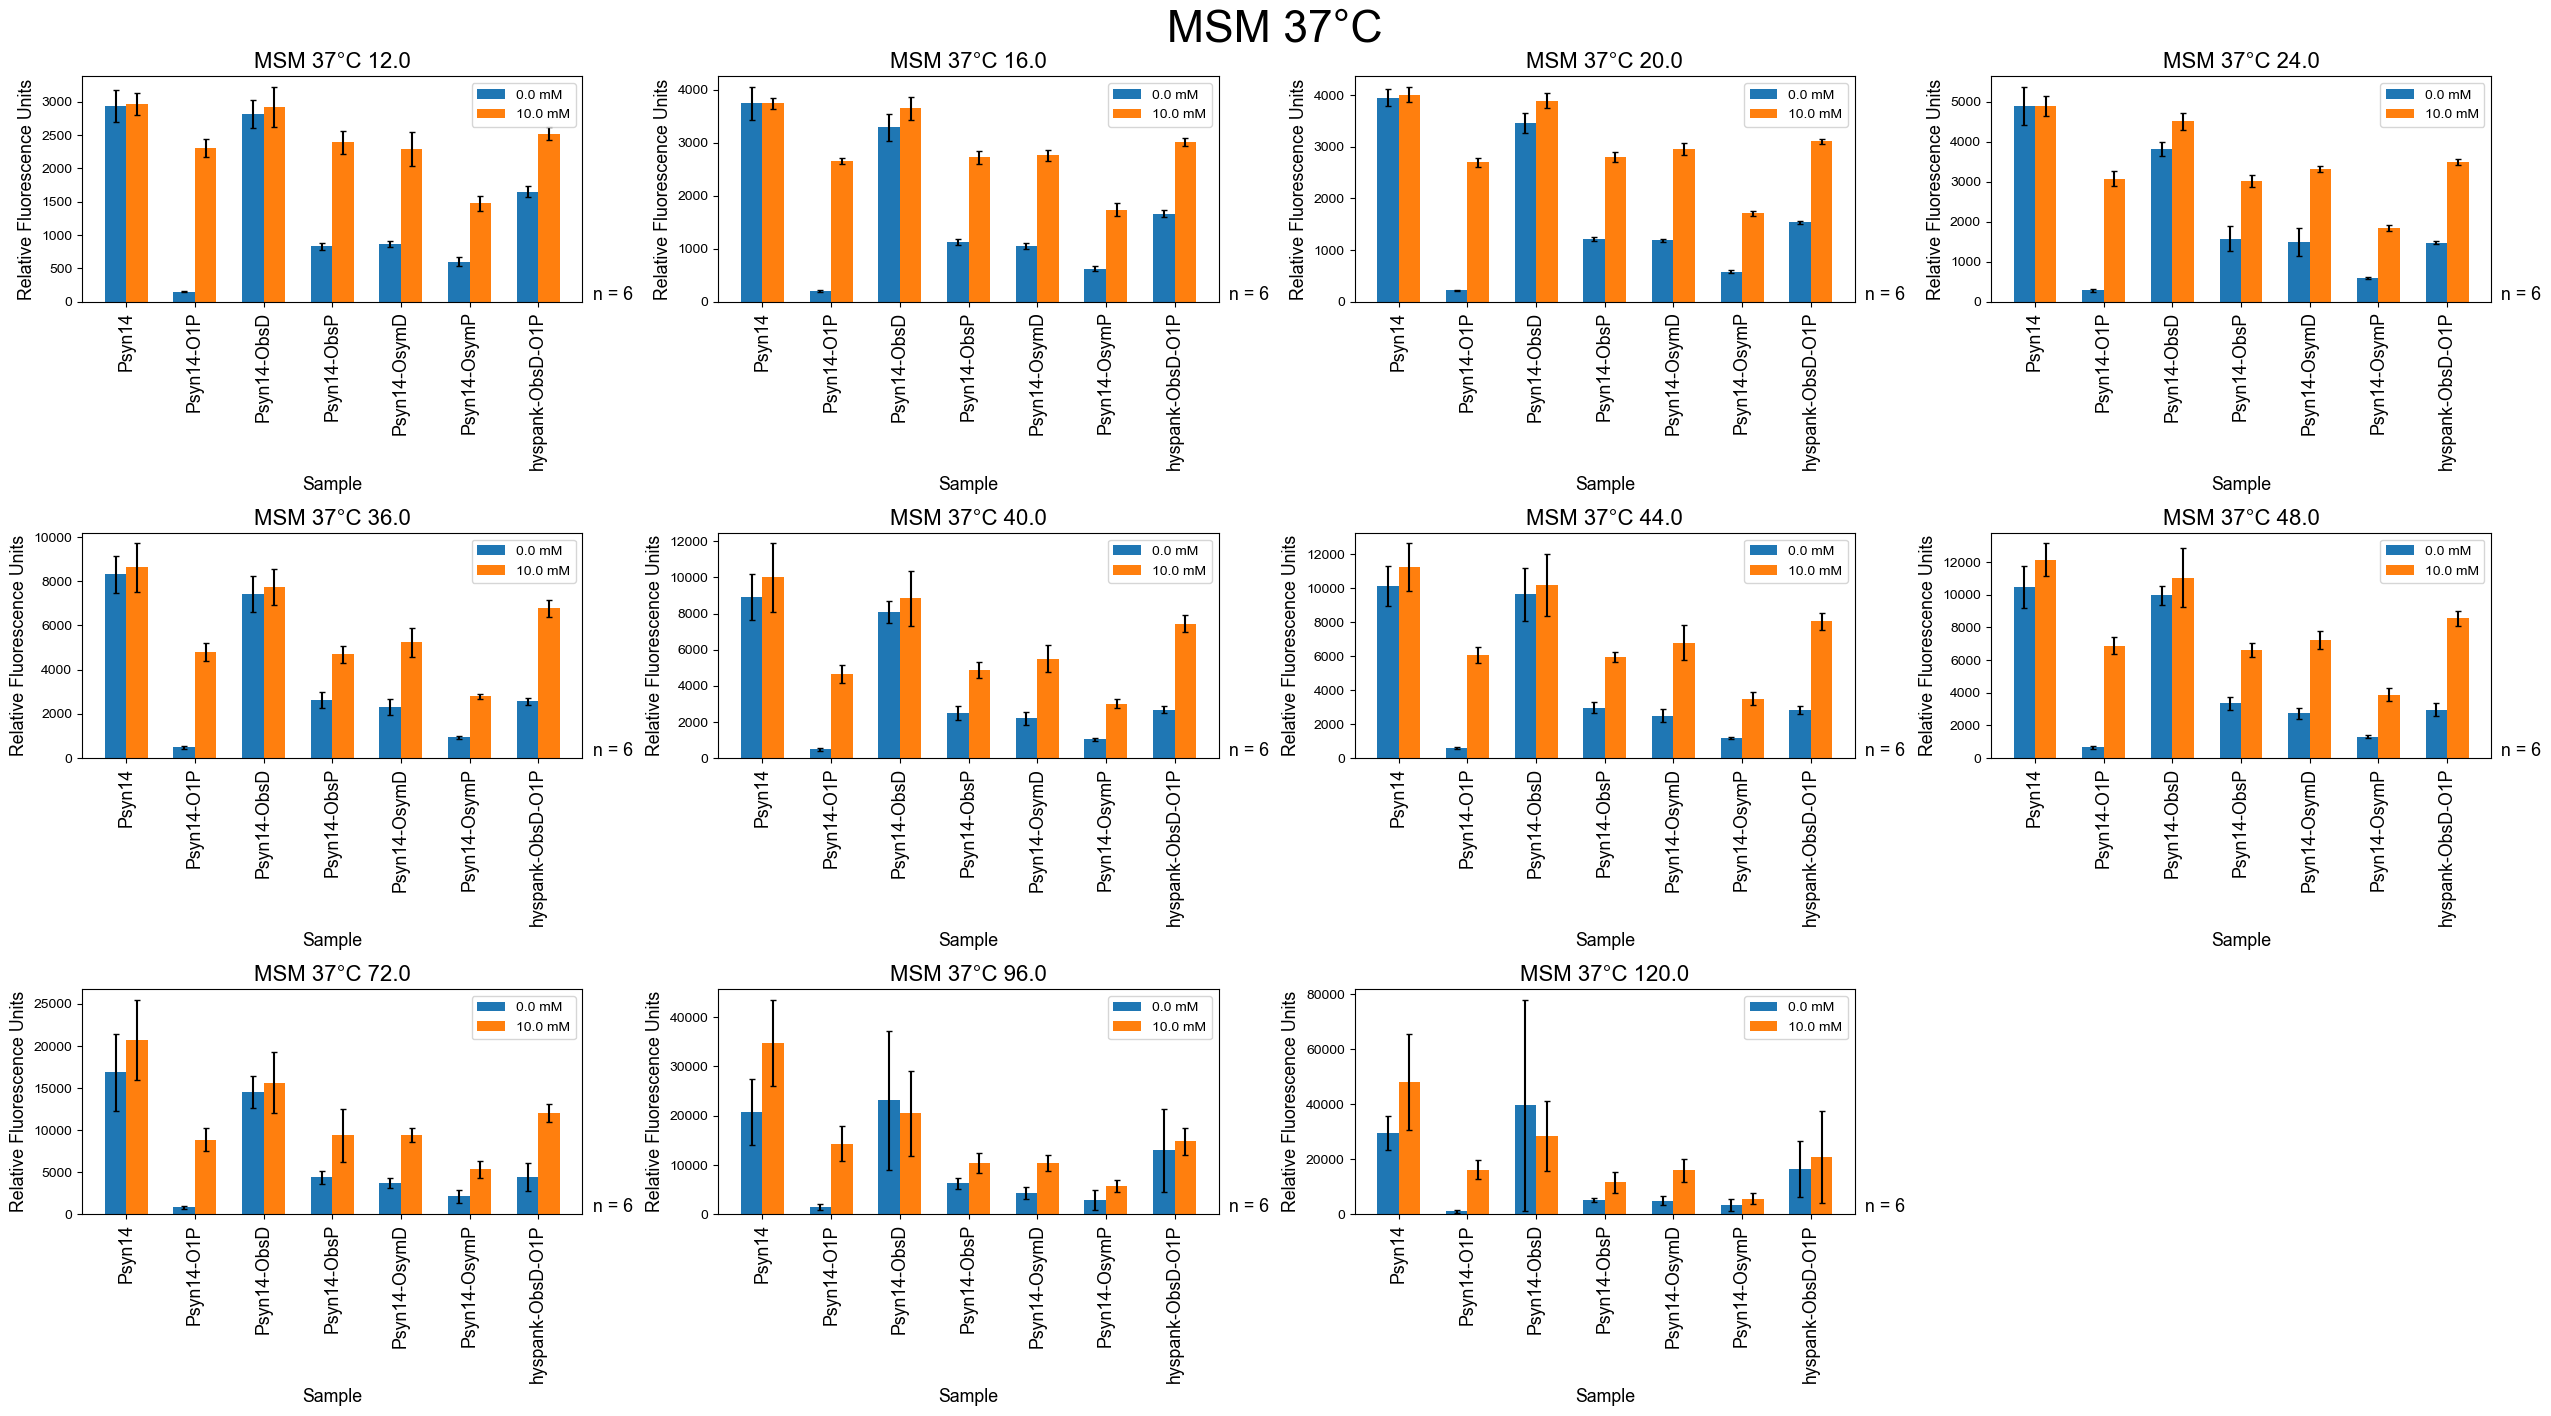

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from matplotlib import ticker as mticker

'''Setting initial parameters for plotting'''

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['errorbar.capsize'] = 2

# columns = df_means.columns
# print(columns)

def subplot_maker(df, dimension, local_constants, plotting_fx, df_control = None, **kwargs):
    
    def subplot_dims(nplots):
        nrows = math.isqrt(nplots)
        ncols = math.ceil(nplots/nrows)
        return nrows, ncols   
    
    nrows, ncols = subplot_dims(len(df[dimension].unique()))
    fontsize = 8+ncols*2
    
    fig = plt.subplots(nrows=nrows, ncols=ncols, figsize = (6.4*ncols,4.8*nrows))

    plotted = {(i,j): False for i in range(nrows) for j in range(ncols)}
    for ((dimvar,idf),(i,j)) in zip(df.groupby(dimension),\
                                   itertools.product(range(nrows),range(ncols))):
#         def time_to_str(num):
#             return str(int(num)) + 'h'
#         if dimension == 'Time':
#             dimvar = time_to_str(dimvar)
            
        local_vars = list(local_constants)
        local_vars.append(dimvar)
        df_ctrl = df_control.copy()
        df_ctrl = df_ctrl.rowtrieve(dimension, dimvar)
        plot_df = pd.concat([df_ctrl, idf])
        
        try:
            ax = fig[1][i,j]
        except IndexError:
            ax = fig[1][j]
        except TypeError:
            ax = fig[1]
        plotting_fx(plot_df, local_vars, subplot_variable = dimension, fontsize = fontsize, fig = fig, ax = ax)

        plotted[(i,j)] = True
        
        try:
            TF = idf['Induction'].apply(lambda x: x.TF).unique()
            plt.suptitle(' '.join((str(constant) for constant in local_constants), TF), size = fontsize*2)
        except:    
            plt.suptitle(' '.join(str(constant) for constant in local_constants), size = fontsize*2)
            
    for plot in plotted:
        if plotted[plot] == False:
            fig[1][plot[0],plot[1]].set_axis_off()

    plt.tight_layout()
    
def bar_plotter(df, local_constants, fontsize = 12, fig = None, ax = None, **kwargs):

    if fig == None and ax == None:
        fig, ax = plt.subplots()
#     df = pd.DataFrame()
    df['Titer'] = df['Induction'].apply(lambda x: x.titer)
    df['Induced'] = df['Induction'].apply(lambda x: x.induced)
    inductions = tuple(df['Titer'].unique())
    width = 1/(len(inductions)+1.2)
    multiplier = 0
    print(df)
    print(df.merge )

    
    '''
    NOTE: needs restructuring for dependence on data from passed df?
    changing
        df_control = df_scheduled.rowtrieve('Induction', control_condition)
        df_scheduled = df_scheduled.loc[~df_scheduled['Induction'].eq(control_condition)]
    lines in barplot_wrapper function appears not to affect output
    
    '''
    for cond in inductions:
        '''Selects data for a specific induction condition'''
        cond_df = df.rowtrieve('Titer', cond)

        '''Dynamically generates xlabels from unique identifier data given from Excel sheet'''
        naming_df = pd.DataFrame()
        for column in cond_df.columns:
            if column not in ['Induction','Mean','StDev','Replicates', 'Titer', 'Induced', 'Induction schedule']\
            and len(cond_df[column].unique()) != 1:
                naming_df[column] = cond_df[column]

        names = []
        for index,row in naming_df.iterrows():
            DR_pair = df.copy()
            for axis in row.axes[0]:
                DR_pair = DR_pair.rowtrieve(axis,row[axis])
            ON = DR_pair.rowtrieve('Induced', True)['Mean']
            OFF = DR_pair.rowtrieve('Induced', False)['Mean']

            dynamic_range = round((ON/OFF).values[0],1)

            ymax = max(ON.values[0],OFF.values[0])

            if ON.values[0] < 100:
                dynamic_range = None

            if 'Plate' in row.index:
                row = row.drop('Plate')
            name = '\n'.join(row)
            names.append((name, dynamic_range, ymax))                   

        '''
        Defines data, errors to be plotted and plots bars for the induction condition.
        Combination of x, width, and multiplier variables ensure correct x-location of each bar.
        '''

        means = tuple(cond_df['Mean'])
        stdevs = tuple(cond_df['StDev'])


        x = np.arange(len(cond_df.index))        
        offset = width*multiplier
        rects = ax.bar(x + offset, means, width, label=cond, yerr=stdevs)
        multiplier += 1       

    if len(df_means['Experiment'].unique()) > 1:
        title = ' '.join(str(constant) for constant in local_constants)

    ax.set_title(title, size = fontsize)    
    ax.set_xlabel('Sample', size = fontsize*0.8)
    ax.set_ylabel('Relative Fluorescence Units', size = fontsize*0.8)
    ax.legend()
    x_locs = x + (len(inductions)-1)*width/2
    ax.set_xticks(x_locs, (x[0] for x in names), rotation = 'vertical', size = fontsize*0.8)

    replicates = ' or '.join(str(number) for number in np.sort(df['Replicates'].unique()))
    ax.text(1.02,0.01,'n = '+ replicates, transform = ax.transAxes, size = fontsize*0.8)
    
def barplot_wrapper(df_means, subplot_variable = None):
    
    if 'Induction schedule' in df_means.columns:
        if subplot_variable == None:
            subplot_variable = 'Induction schedule'
    else:
        if subplot_variable == None:
            subplot_variable = 'Assay'
            
    for local_constants, df in df_means.inverse_groupby(ignore_cols = ['Sample','Induction', 'Assay', 'Induction schedule',\
                                                                        subplot_variable]):
        df['Induced'] = df['Induction'].apply(lambda x: x.induced)
        df_scheduled = df.rowtrieve('Assay','Normalized Fluorescence')
        if subplot_variable == 'Assay':
            df_scheduled = df
            
        df_control = df_scheduled.loc[df_scheduled['Induced'] == False]
        df_scheduled = df_scheduled.loc[df_scheduled['Induced'] == True]
#         df_scheduled = df_scheduled.loc[~df_scheduled['Induction'].eq(control_condition)]

        subplot_maker(df_scheduled, subplot_variable, local_constants, bar_plotter,\
                              df_control = df_control)
        
# barplot_wrapper(df_means)
barplot_wrapper(df_means, subplot_variable = 'Time')

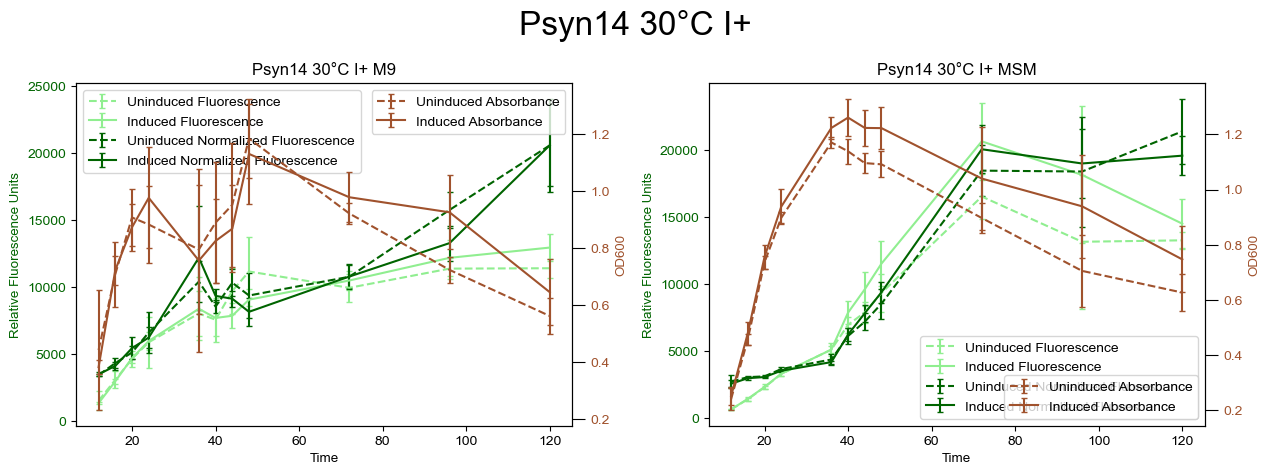

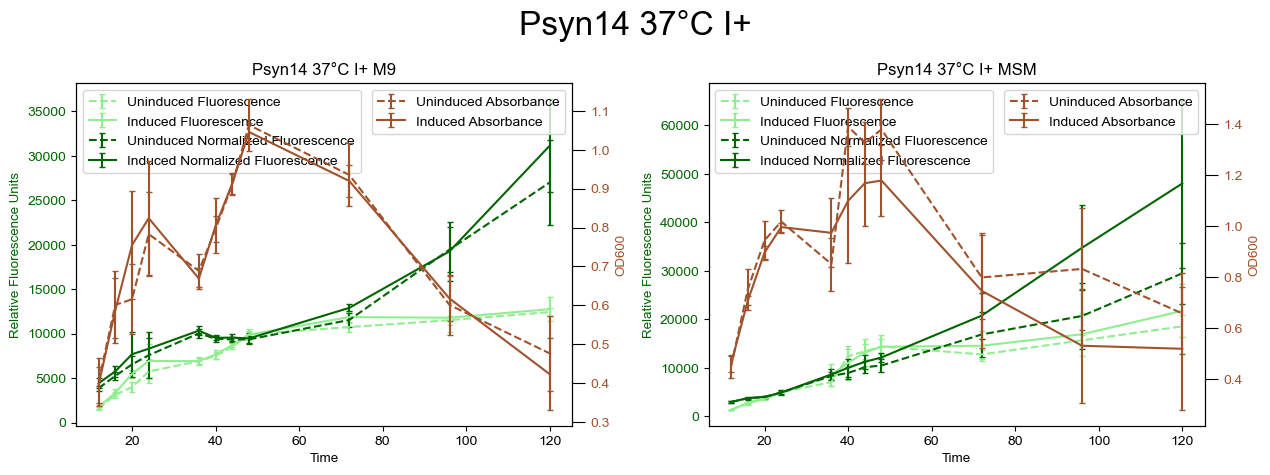

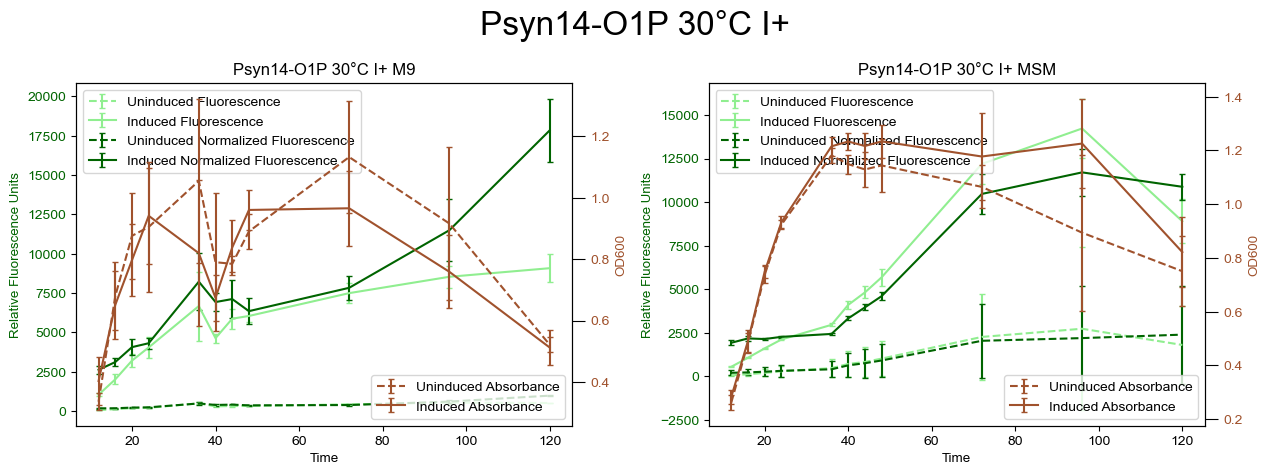

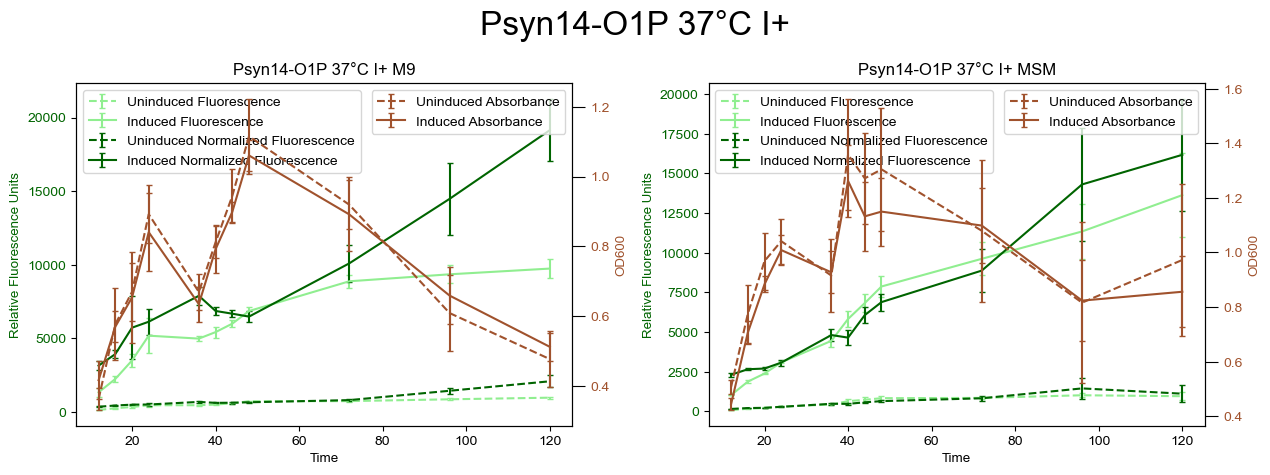

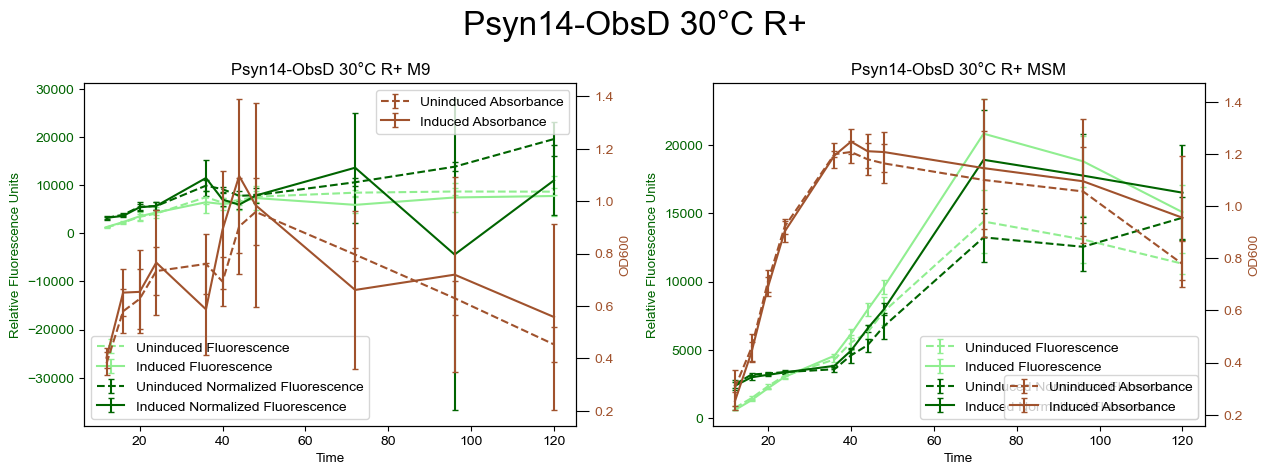

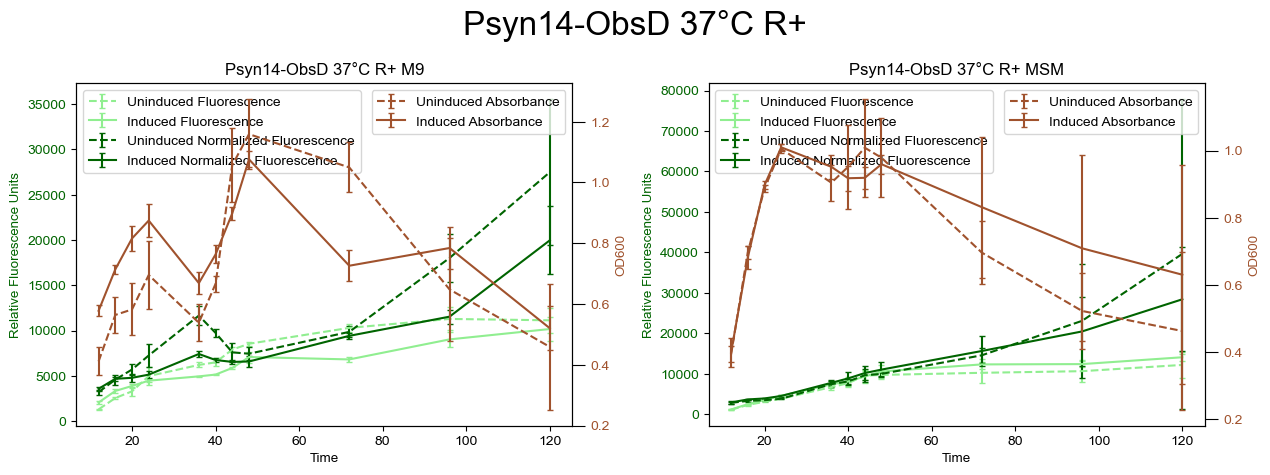

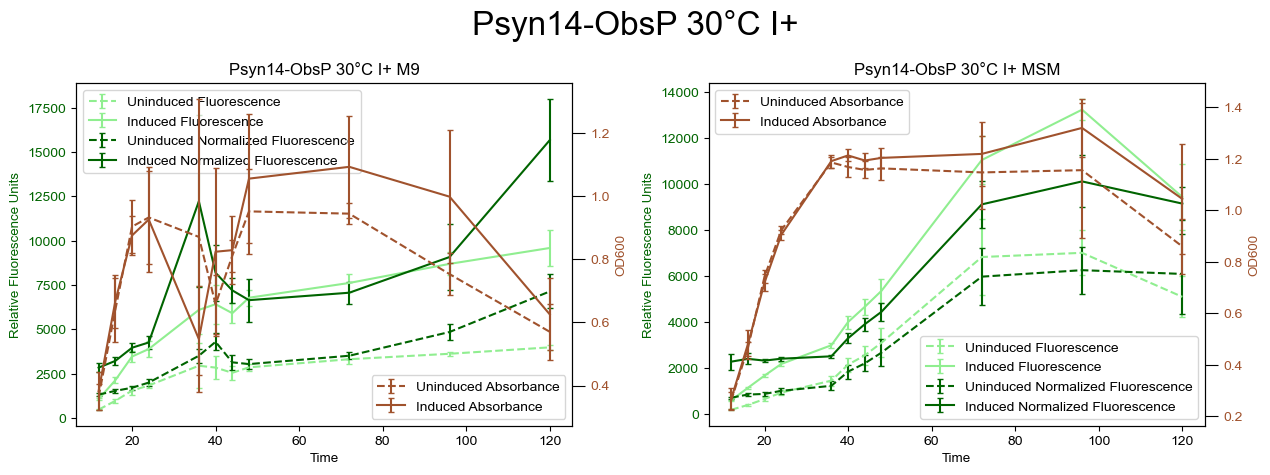

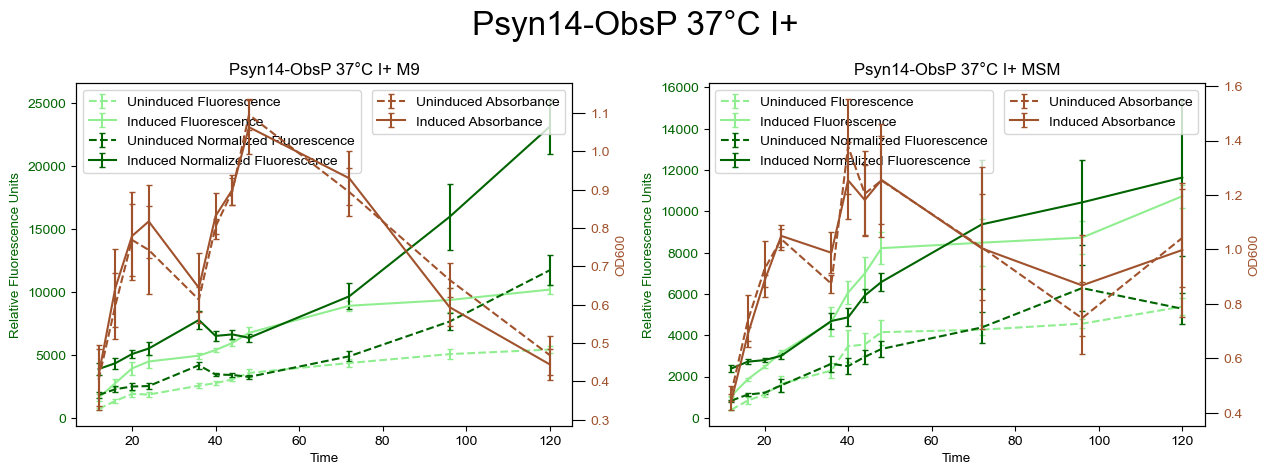

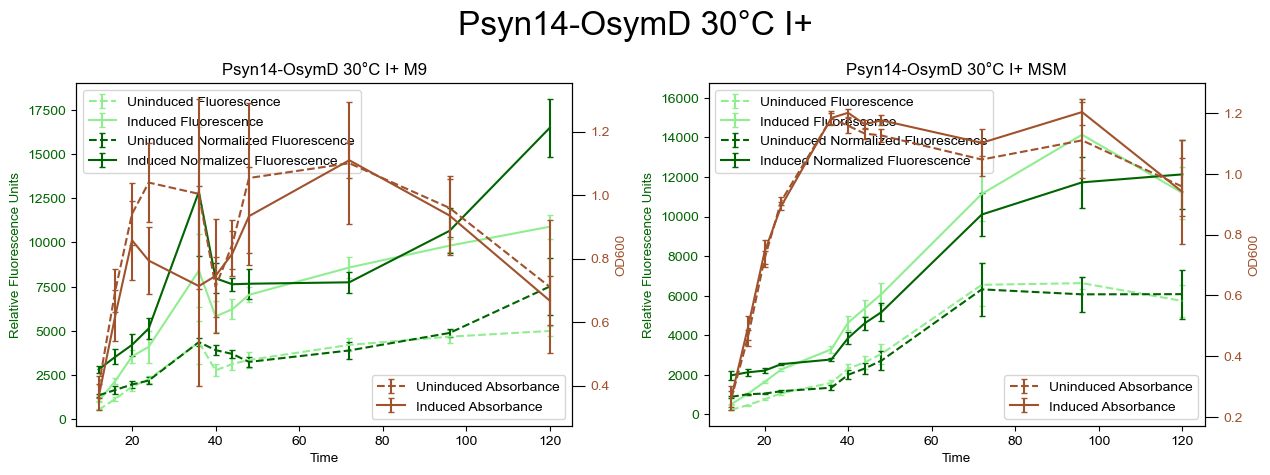

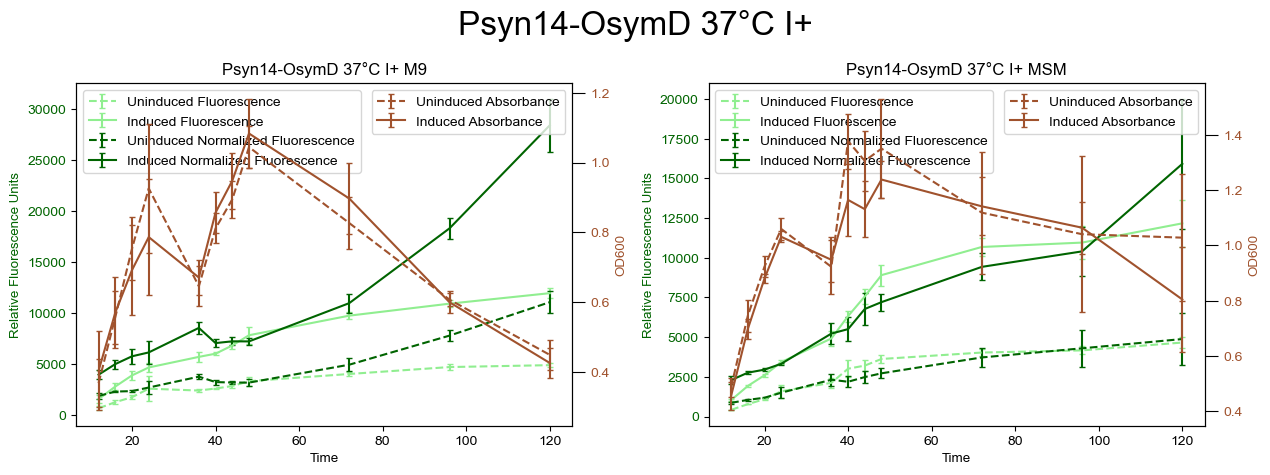

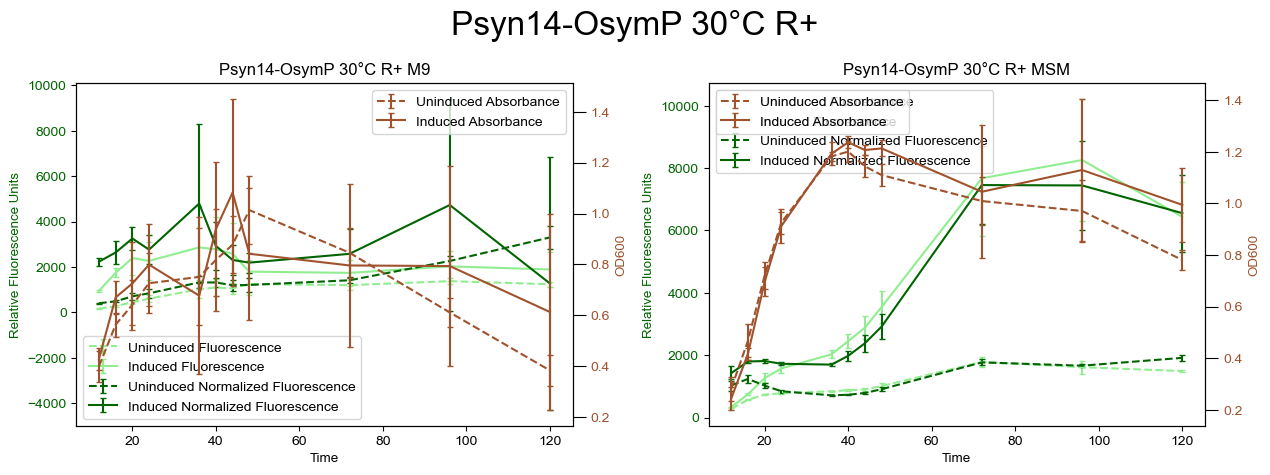

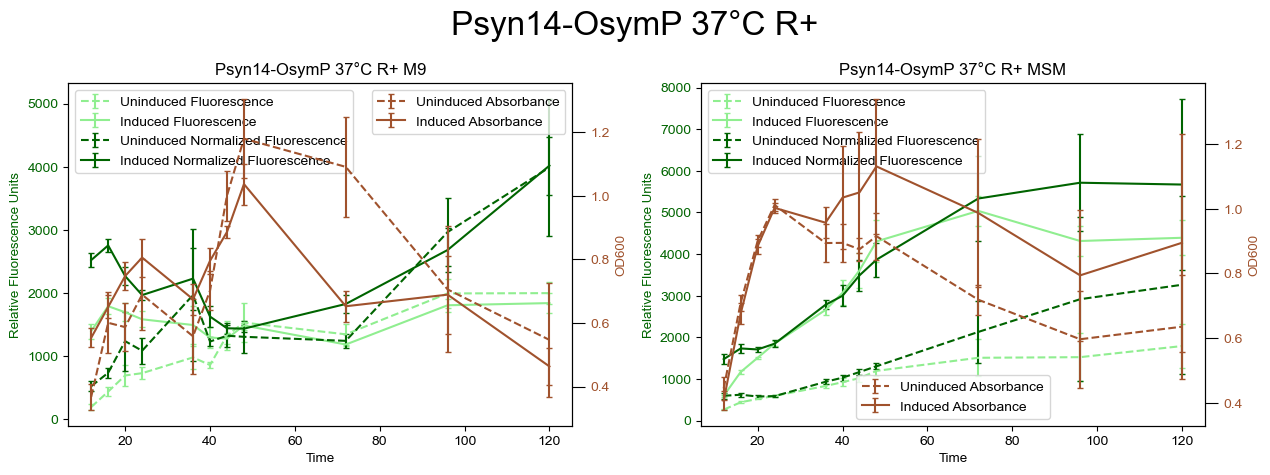

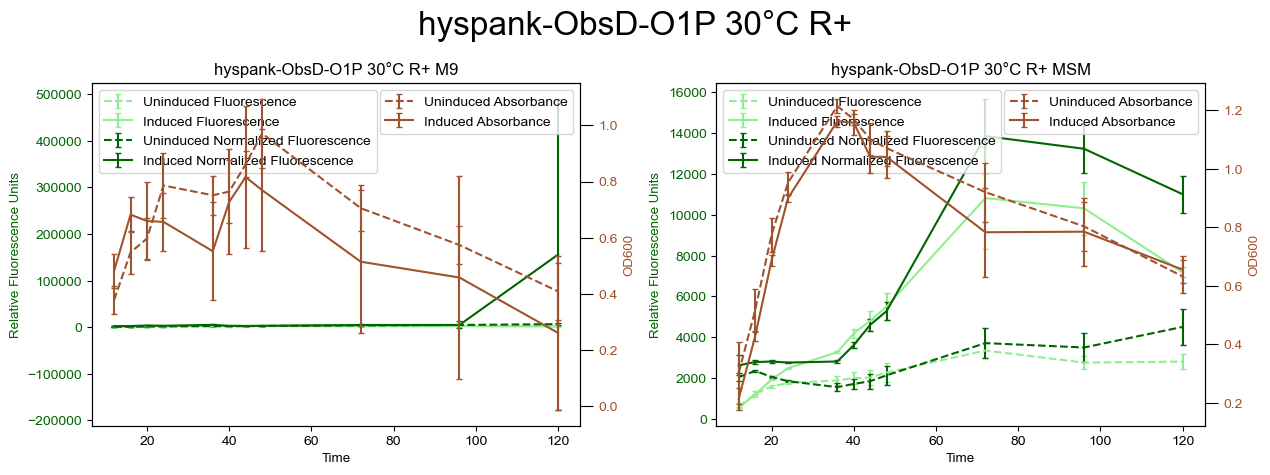

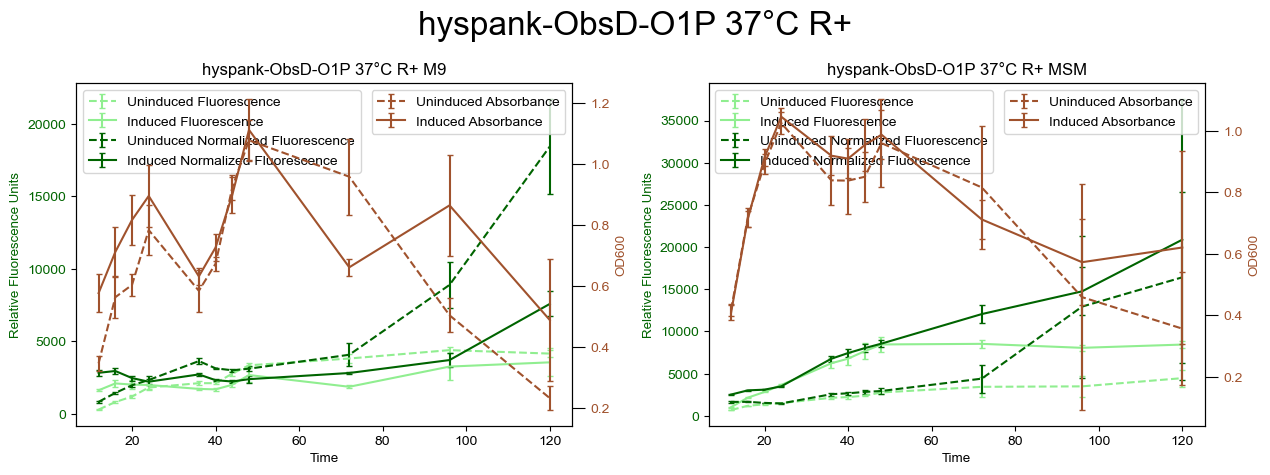

In [96]:
'''
This module analyzes an experiment as a kinetic collection of timepoints, 
with single timepoints constituting their own Excel files.

To work properly, files should be named so as to comply with the time_parser function, i.e.:
The timepoint should be written into the file name as the last string before extension and separated by an underscore.
Acceptable units are 'h' (hours), 'm' (minutes), and 's' (seconds).

e.g.: 20230803_BASF_timepoints_12h
The program would interpret the above as the 12-hour timepoint.
'''


'''
Cleans results file directory to ensure most-recent run of code has produced output figures.
If such directory does not yet exist, makes the directory.
'''
results_location = os.path.join(absolute_path, 'results/', file_target)

if not os.path.exists(results_location):
    os.makedirs(results_location)
if os.path.exists(results_location):
    for file in glob.glob(results_location + '*.png'):
        os.remove(file)




def all_assay_line_plotter(df, variables, induction_variable = 'Induction', fontsize = 12, fig = None, ax = None, **kwargs):
    
    def plotter(df, keys):
        fl_labels = []
        abs_labels = []
    
        for assay, induction in itertools.product(df[keys[0]].unique(),df[keys[1]].unique()):
            ind = 'Induced'
            
            lstyle = '-'
            if '+ 0 mM' in induction or '---' in induction:
                lstyle = '--'
                ind = 'Uninduced'
            
            idf = df.rowtrieve(keys[0],assay).rowtrieve(keys[1], induction)
            if assay == 'Absorbance':
                assaycolor = abs_color
                assayax = ax2
                abs_labels.append(' '.join([ind, 'Absorbance']))
                
            elif assay == 'Fluorescence':   
                assaycolor = 'lightgreen'
                assayax = ax
                fl_labels.append(' '.join([ind, 'Fluorescence']))
                
            elif assay == 'Normalized Fluorescence':    
                assaycolor = fluor_color
                assayax = ax
                fl_labels.append(' '.join([ind, 'Normalized Fluorescence']))
                
            idf.plot(x='Time', y='Mean', yerr = 'StDev', ax = assayax, color = assaycolor, linestyle = lstyle)
        ax.legend(fl_labels)
        ax2.legend(abs_labels)    
    
    if fig == None and ax == None:
        fig, ax = plt.subplots()
    
    abs_color = 'sienna'
    fluor_color = 'darkgreen'
    title = (' ').join(variables)

    inducer_list = []

    for inducer in inducers:
        if df['Induction'].apply(lambda x: inducer in x).any():
            inducer_list.append(inducer)
            TF = IND_translate[inducer]

    if len(inducer_list) == 1:
        pass
    else:
        print(df)
        print(inducer_list)
        raise ValueError

    ax.set_title(title, size = fontsize)
    ax.set_xlabel('Time (h)', size = fontsize*0.8)
    ax.set_ylabel('Relative Fluorescence Units', color = fluor_color, size = fontsize*0.8)
    ax.tick_params(axis='y', labelcolor = fluor_color)

    ax2 = ax.twinx()
    ax2.set_ylabel('OD600', color = abs_color, size = fontsize*0.8)
    ax2.tick_params(axis='y', labelcolor = abs_color, size = fontsize*0.8)

    plotter(df, ['Assay', induction_variable])
        
    
        
'''
This section built for plotting several conditions of an induction v. negative control, 
specifically for growth/fluorescence data.
Define the column in the df used to vary across subplots as 'induction_variable' 
and the control condition as 'control_condition'

'''
subplot_variable = 'Media'

if 'Induction schedule' in df_means.columns:
    induction_variable = 'Induction schedule'
    control_condition = '---'
else:
    induction_variable = 'Induction'
    control_condition = '\+ 0 mM'


# if induction_variable in df_means.columns:
for local_constants, df in df_means.inverse_groupby(ignore_cols = ['Induction', 'Assay', 'Time', subplot_variable]):
    df_scheduled = df.copy()
    df_control = df_scheduled.induction_finder(induction_variable, control_condition)
    df_scheduled = df_scheduled.loc[~df_scheduled[induction_variable].str.contains(control_condition)]
    subplot_maker(df_scheduled, subplot_variable, local_constants, all_assay_line_plotter,\
                      df_control = df_control)

# else:
#     for local_constants, df in df_means.inverse_groupby(ignore_cols = ['Induction', 'Assay', 'Time']):
#         all_assay_line_plotter(df, local_constants)




In [ ]:
      
print(df_means)
constants = list(df_means.columns.values)
constants.remove('Induction')
print(df_means)
print(constants)

for variables, df in df_means.groupby(constants):
    print(df)
for assay in df_means.groupby(['Assay']):
        
    assay_df = assay[1]
    
    varkeys = []
    for column in assay_df:
        if len(assay_df[column].unique()) > 1 and column not in ['Experiment','Induction','Mean','StDev','Replicates','Time']:
            varkeys.append(column)
    combispace = {key:list(assay_df[key].unique()) for key in varkeys}
    
    cmaps_temps = [mpl.colormaps['Blues'], mpl.colormaps['Reds']]
    cmaps_media = [mpl.colormaps['Greys'],mpl.colormaps['Greens']]
    cmaps_loci = [mpl.colormaps['Purples'], mpl.colormaps['Oranges']]
    cmaps_passagetime = [mpl.colormaps['Blues'], mpl.colormaps['Reds']]
    
    dict_cmaps = dict.fromkeys(combispace)
    dict_cmaps['Sample'] = cmaps_loci
    dict_cmaps['Media'] = cmaps_media
    dict_cmaps['Temperature'] = cmaps_temps
    dict_cmaps['Days pre-cultured'] = cmaps_passagetime

    
    for key in combispace:
        other_keys = list(combispace.keys())
        other_keys.remove(key)
        alt_dims = [combispace[other_key] for other_key in other_keys]
        cmaps = dict_cmaps[key]
        
        
        for constants in product(alt_dims[0],alt_dims[1]):
            fig, ax = plt.subplots() 
            plot_df = assay_df.rowtrieve(other_keys[0],constants[0]).rowtrieve(other_keys[1],constants[1]) 
            
            samplist = plot_df[key].unique()
            color_iterator = iter(np.linspace(0.4,0.9,len(plot_df['Induction'].unique())))
            try:
                color_lookup = {samplist[j]: (cmaps[j], copy.deepcopy(color_iterator)) for j in range(len(samplist))}
            except:
                print(key)
            for condition in product(samplist, plot_df['Induction'].unique()):
                lstyle = 'solid'
                if '@ 12h' in condition[1]:
                    lstyle = 'dotted'
                
                line_df = plot_df.rowtrieve(key,condition[0]).rowtrieve('Induction',condition[1]) 
                ax.errorbar(line_df['Time'], line_df['Mean'], label=condition, yerr=line_df['StDev'],\
#                         color = color_lookup[condition[0]][0](next(color_lookup[condition[0]][1])),\
                           linestyle = lstyle)
            
            plot_title = 'Kinetic ' + assay[0] + '\n' + samplist[0] + ' v. ' + samplist[1] \
    + '\n' + constants[0] + ', ' + constants[1] + ' constant'
#             fig.suptitle('Kinetic ' + assay[0], fontweight='bold')
            ax.set_title(plot_title)
            ax.legend()
            if assay[0] == 'Absorbance':
                ax.set_ylabel('OD600')
#                 ax.set_ylim(0,1.6)
            elif 'Fluorescence' in assay[0]:
                ax.set_ylabel('RFU')
#                 ax.set_ylim(0,10000)
            ax.set_xlabel('Time (hours)')
            
            save_title = 'Kinetic ' + assay[0] + samplist[0] + ' v. ' + samplist[1] + constants[0] + ', ' + constants[1] + ' constant'
            
            plt.tight_layout()
            plt.savefig(results_location + save_title + '.png')
            plt.show()

In [8]:
results_location = os.path.join(absolute_path, 'results/', file_target, '')
# print(df_means)
def DR_generator(df_means, ind_states):
    

    for inducer_condition in df_means['Induction'].unique():
        inducer = inducer_condition.split()[-1]
        if inducer not in inducers:
            inducers.append(inducer)
            
    OFF = ind_states[0]
    ON = ind_states[1]
    DR_columns_constant = [e for e in df_means.columns if e not in ('Induction','Mean','StDev','Replicates')]
    
    DR_df = pd.DataFrame()

    for DR_cluster in df_means.groupby(DR_columns_constant):
        if DR_cluster[1]['Assay'].unique() == 'Normalized Fluorescence':
#             print(DR_cluster[1])
            collist = list(DR_cluster[1].columns)
            DR_idf = pd.DataFrame(columns = collist)
            for col in collist:
                if len(DR_cluster[1][col].unique()) == 1:
                    DR_idf[col] = DR_cluster[1][col].unique()
            
            DR_idf['Dynamic Range'] = DR_cluster[1].rowtrieve('Induction', ON)['Mean']\
                                    /DR_cluster[1].rowtrieve('Induction', OFF)['Mean']
            
#             print(DR_idf)
#             print('\n\n\n')
            DR_df = pd.concat([DR_df,DR_idf], ignore_index=True)
            
    DR_columns_constant.remove('Experiment')
    DR_columns_constant.remove('Time')
    
    return DR_df, DR_columns_constant


# DR_df, DR_columns_constant = DR_generator(df_means, ['\+ 0 mM', '\+ 10 mM'])

DR_df, DR_columns_constant = DR_generator(df_means, ['+ 0 mM ribose', '+ 10 mM ribose'])
IDR_df, DR_columns_constant = DR_generator(df_means, ['+ 0 mM ribose', '+ 10 mM ribose @ 12h'])
# print(DR_df)

# ribose_DR_df, DR_columns_constant = DR_generator(df_means, ['+ 0 mM ribose', '+ 10 mM ribose'])
# IPTG_DR_df, DR_columns_constant = DR_generator(df_means, ['+ 0 mM IPTG', '+ 10 mM IPTG'])

print(DR_df.loc[:,['Sample','Dynamic Range']])
# print(IPTG_DR_df)
def DR_plotter(DR_df, induced=False):
    fig, ax = plt.subplots() 

    for DR_cluster in DR_df.groupby(DR_columns_constant):
        line_df = DR_cluster[1]
#         print(DR_cluster[0])
        conds = DR_cluster[0]

        marker = ''
        color = ''
        style = ''

        if conds[0] == 'amyL R+':
            marker = 'o'
        if conds[0] == 'lacA R+':
            marker = '^'


        if conds[1] == 'M9':
            style = 'dashed'
        if conds[1] == 'MSM':
            style = 'solid'

        if conds[2] == '30°C':
            color = 'b'
        if conds[2] == '37°C':
            color = 'r'

        ax.plot(line_df['Time'], line_df['Dynamic Range'], label=DR_cluster[0],\
                marker=marker, color = color, linestyle = style)

    title_append = ''
    if induced == True:
        title_append = ', ON state induced @ 12h'
        
    ax.set_title('Measured dynamic range over time' + title_append)
    ax.set_ylabel('Dynamic range')
    ax.set_xlabel('Time (hours)')
    ax.set_ylim(0,4)

#     ax.legend(loc=(0,-0.55), fontsize = 9)
    
    
    save_title = 'dynamic_range_over_time' + title_append
    plt.savefig(results_location + save_title + '.png')
    plt.show()
DR_plotter(DR_df)
DR_plotter(IDR_df, induced = True)

ValueError: list.remove(x): x not in list

In [57]:
'''
The following variables define functional classfication parameters as shown on expression plots
'''
NF_DR_mult = 0.2 # max percent difference between states to classify as non-functional; corresponds to DR = (1+x) and DR = 1/(1+x)
SR_val = 0.3 # max relative value to classify as super-repressor
SR_tighten = 0.3 # value between 0 and 1 that tightens the flanks of the super-repressor window. 0 disables.

'''
This module defines a function that generates pretty scatterplots from a pandas dataframe 
containing x- and y-data in columns labeled 'Expression (-)' and 'Expression (+)', respectively,
with standard deviations in columns labeled 'SD (-)' and 'SD (+)'
'''

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from adjustText import adjust_text

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

df_means['Time'] = df_means.get('Time', df_means['Experiment'].apply(time_parser))    
results_location = os.path.join(absolute_path, 'results/', file_target)

def pretty_plotterator(df, tf = None, draw_classes = True, show_SD = True, plot_DRs = True, global_window = True, plot_PC = True,\
                       annotate = True, plot_DR_guides = True, DRs_to_plot = [0.25, 0.5, 1, 2, 4],\
                       size = 3, title = 'Experiment Title',\
                       xdata = None, ydata = None, xSD = None, ySD = None,\
                       xPC = None, yPC = None, xSD_PC = None, ySD_PC = None, \
                       paramA = NF_DR_mult, paramB = SR_val, paramC = SR_tighten):

    title = ' '.join(x for x in title)


    'initializing and labeling axes'
    fig = plt.figure(figsize=(6,5))

    ax1 = fig.add_subplot()
    ax1.set_xlabel('Uninduced\nNormalized RFU')
    ax1.set_ylabel('Induced\nNormalized RFU')
    ax1.set_title(title + '\n' + tf + ' Kinetic Phenotypes', weight = 'bold')
    
    values = [val for sublist in [xdata.values, ydata.values] for val in sublist]
    xylim = max(values)*1.1
    
    if plot_PC == True:
        PC_values = [val for sublist in [xPC.values, yPC.values] for val in sublist]
        plot_values = [val for sublist in [values, PC_values] for val in sublist]
        xylim = max(plot_values)*1.1

    if isinstance(global_window, bool):
        if global_window == True:
            xylim = global_xylim
    elif isinstance(global_window, int):
        xylim = global_window    

    ax1.set_xlim([0,xylim])
    ax1.set_ylim([0,xylim]) 
    
    '''Cannibalized code used to draw the background (blue-white-red) diagonal gradient'''
    def gradient_image(ax, cmap_range=(0, 1), **kwargs):
        X = np.array([[0, 1],
                      [1, 2]])
        a, b = cmap_range
        X = a + (b - a) / X.max() * X
        im = ax.imshow(X, interpolation='lanczos', clim=(0,1),
                       aspect='auto', **kwargs)
        return im
    
    gradient_image(ax1, extent=(0, xylim, 0, xylim),
                   cmap=plt.cm.bwr, # fyi, 'bwr' here defines the blue-white-red color gradient used
                   cmap_range=(0.3, 0.7), alpha=0.7) #messing with these variables shifts range of gradient and its opacity
    
    '''Adds y = mx lines of constant dynamic range for m in DRs_to_plot'''  
    if plot_DR_guides == True:
        for DR in DRs_to_plot:
            xDR = np.linspace(0, int(xylim), 100)
            yDR = xDR*DR

            ax1.plot(xDR, yDR, linewidth=1, ls = (0, (5,5)), color = 'lightgray', zorder = 1, label = 'DR = ' + str(DR))
            
#             DR_loc = (1,1*DR)
#             DR_loc = tuple(i/max(DR_loc) for i in DR_loc)
#             ax1.text(DR_loc[0],DR_loc[1], 'DR = ' + str(DR), ha='center', transform=ax1.transAxes)
            
    """Ugly hardcoding to draw functional classification zones on plot based on varables defined above"""
    if draw_classes:
        fill_intensity = 1 #how opaque drawn polygons representing classes are; recommend value = 1 ; max value 2
        
        ax1.fill([paramB/(1+paramA),1/(1+paramA),1,1,paramB], [paramB,1,1,1/(1+paramA),paramB/(1+paramA)],
                 color = 'lightgray', alpha = fill_intensity*0.5, transform = ax1.transAxes)  
        ax1.fill([0,0,paramB*1/(1+paramA),paramB,paramB*(1-paramC)], [0,paramB*(1-paramC),paramB,paramB*1/(1+paramA),0],
                 color = 'wheat', alpha = fill_intensity*0.5, transform = ax1.transAxes)
        ax1.fill([paramB*(1-paramC),paramB,1,1], [0,paramB*1/(1+paramA),1/(1+paramA),0],
                 color = 'red', alpha = fill_intensity*0.01, transform = ax1.transAxes)
        ax1.fill([0,0,1/(1+paramA),paramB*1/(1+paramA)], [paramB*(1-paramC),1,1,paramB],
                 color = 'blue', alpha = fill_intensity*0.01, transform = ax1.transAxes)

    '''~actual plotting~'''
    # The x and y data to plot
    y = ydata.values
    x = xdata.values
    xpc = xPC.values
    ypc = yPC.values

    '''A function to build a set of gradient-colored line segments for 2D plotting'''
    def gradient_line(x, y, gradient, ax, indscheduled = False):
        segments_x = np.r_[x[0], x[1:-1].repeat(2), x[-1]].reshape(-1, 2)
        segments_y = np.r_[y[0], y[1:-1].repeat(2), y[-1]].reshape(-1, 2)


        linecolors = [gradient(0.4+0.6*list(x).index(x_)/len(x)) for x_ in x[1:]]
        pointcolors = [gradient(0.4+0.6*list(x).index(x_)/len(x)) for x_ in x]

        segments = np.dstack((segments_x,segments_y))
        
        if indscheduled == True:
            induction_times = ['0h','12h','24h']
            schedule = df['Induction schedule'].unique()[0]

            for i in range(len(schedule)):
                if schedule[i] == '+':
                    if induction_times[i] == '0h':
                        pointcolors[0] = 'darkred'
                    else:
                        pointcolors[timepoints.index(induction_times[i])+1] = 'darkred'
                        linecolors[timepoints.index(induction_times[i])] = 'r'
                        
        lines = ax.add_collection(LineCollection(segments, colors=linecolors, zorder = 3, linewidth = 2,\
#                                                  clip_on = False\
                                                ))
        points = ax.scatter(x, y, s=8, color = pointcolors, zorder=3,\
#                             clip_on = False\
                           )

    if 'Induction schedule' in df.columns:
        gradient_line(x, y, mpl.colormaps['Greys'], indscheduled = True)       
    else:
        gradient_line(x, y, mpl.colormaps['YlOrBr'], ax1)
    if plot_PC == True:
        gradient_line(xpc, ypc, mpl.colormaps['YlGn'], ax1)
    
                 
    
    '''Maybe for creating a legend?'''
#     xleg = np.array([0.8,1,1,1,0.9])*xylim*1.1
#     yleg = np.array([0.1,0.2,0.3,0.4,0.5])*xylim
#     gradient_line(xleg, yleg, mpl.colormaps['YlOrBr'], ax1)
    
    '''Annotating timepoints'''
    
    timepoints = [str(int(round(x,0))) + 'h' for x in df['Time'].unique()]
    
    if annotate == True:
        for i, txt in enumerate(timepoints):
            if i not in [1,2,5,6]:
                time_labels = ax1.annotate(txt, (x[i],y[i]), xytext = (-2,2),\
                                           textcoords = 'offset points', ha = 'right', style = 'italic')
                if plot_DRs == True:
                    DR_labels = ax1.annotate(str(round(y[i]/x[i],1)), (x[i],y[i]), xytext = (2,2),\
                                             textcoords = 'offset points', weight = 'bold')
                if plot_PC == True:
                    PC_time_labels = ax1.annotate(txt, (xpc[i],ypc[i]), xytext = (-2,2), textcoords = 'offset points',\
                                                  ha = 'right', style = 'italic', color = 'darkgreen')
                    if plot_DRs == True:
                        PC_DR_labels = ax1.annotate(str(round(ypc[i]/xpc[i],1)), (xpc[i],ypc[i]), xytext = (2,2),\
                                                    textcoords = 'offset points', weight = 'bold', color = 'darkgreen')

    '''plotting errorbars'''
    if show_SD == True:
        ax1.errorbar(xdata, ydata, xerr=xSD, yerr=ySD, fmt=',', ecolor='lightslategray', elinewidth=1, capsize=1)
        if plot_PC == True:
            ax1.errorbar(xPC, yPC, xerr=xSD_PC, yerr=ySD_PC, fmt=',', ecolor='lightslategray', elinewidth=1, capsize=1)
    
            
    ax1.set_aspect('equal', adjustable='box')
    
    plt.savefig(results_location + title + '.png')


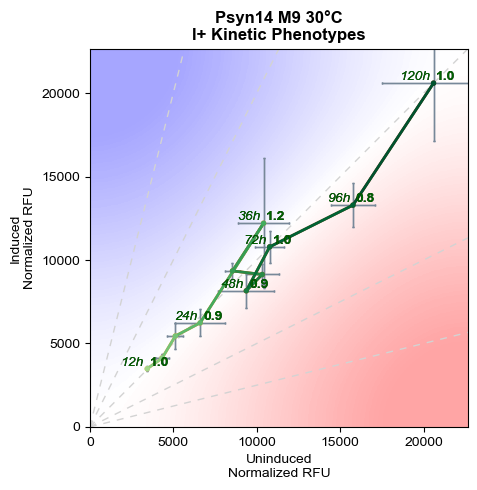

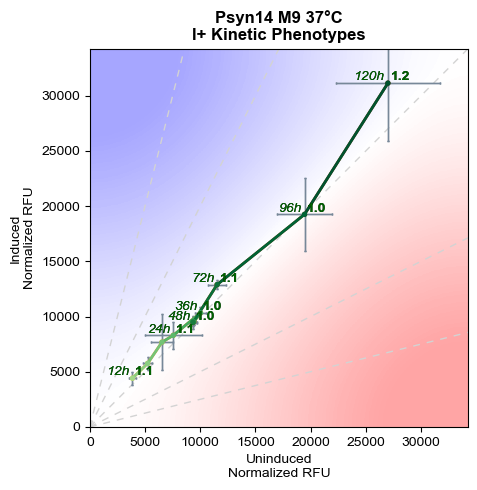

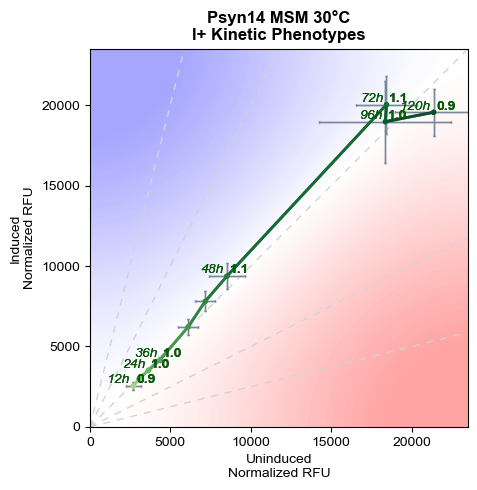

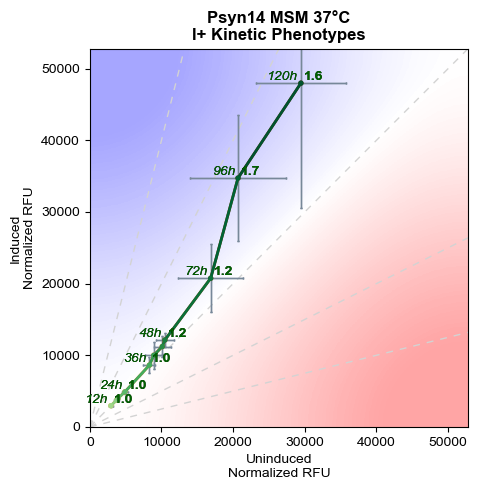

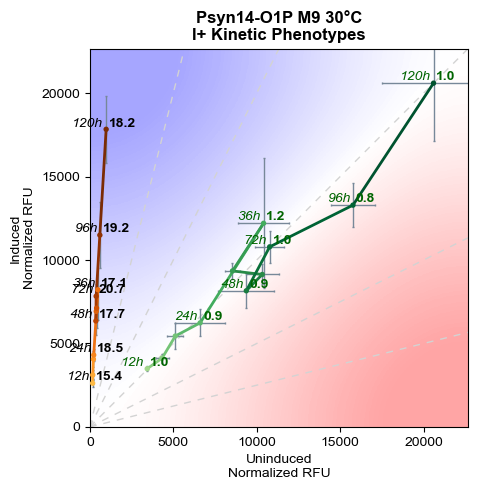

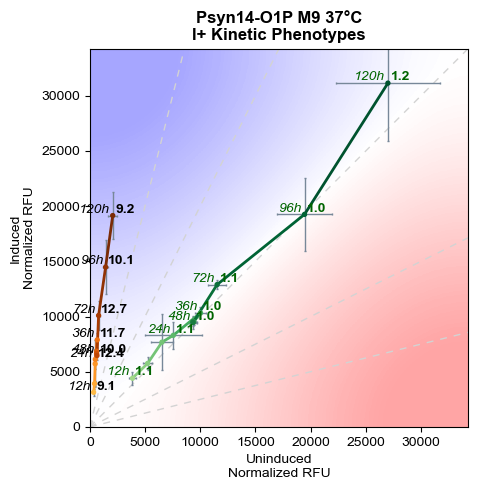

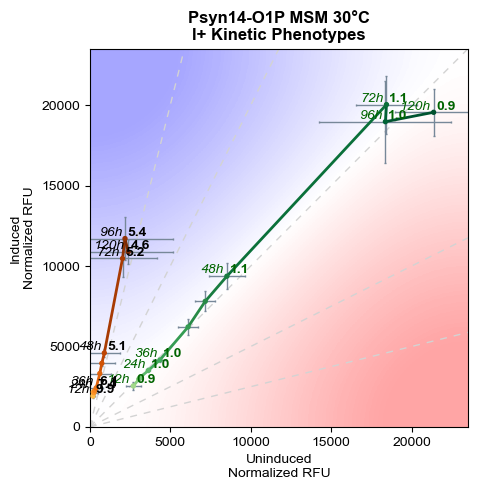

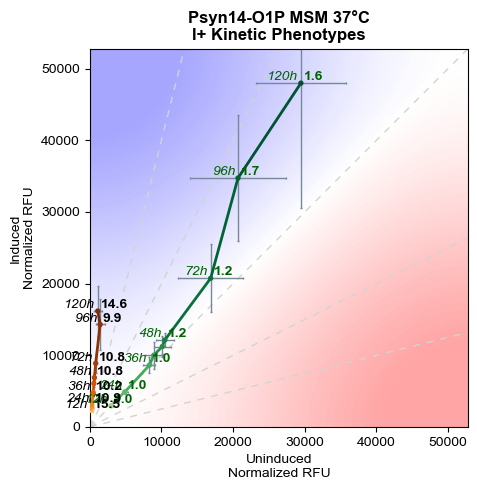

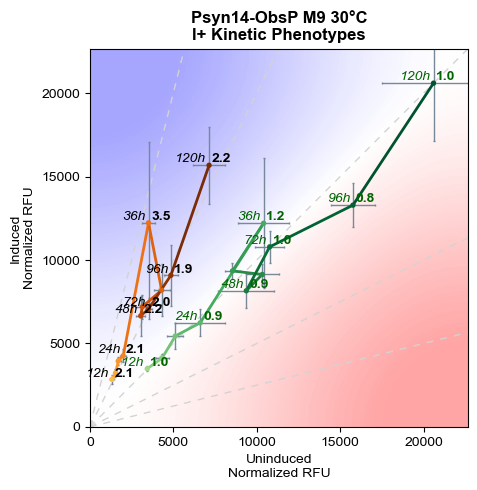

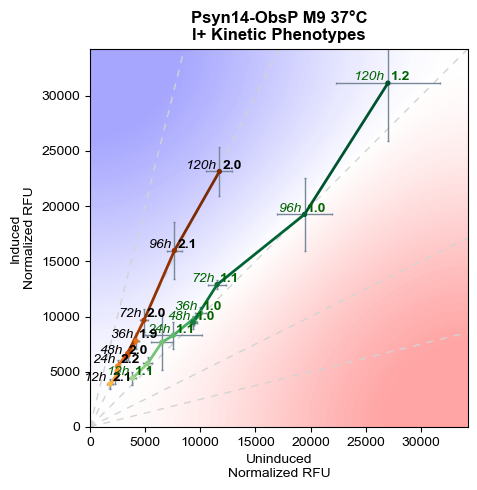

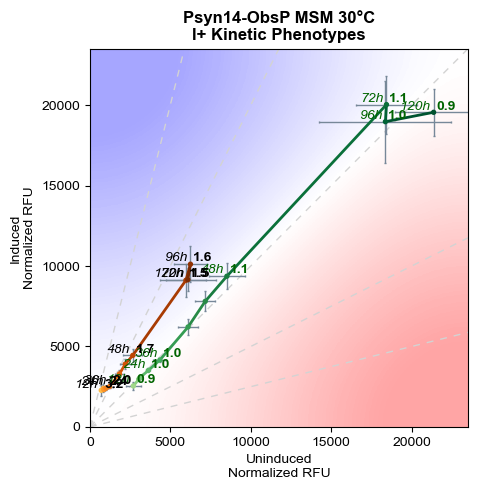

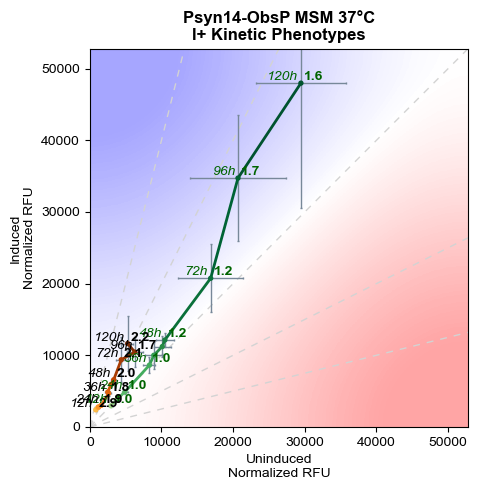

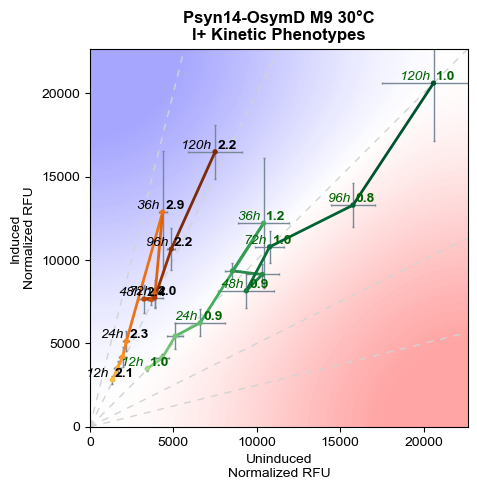

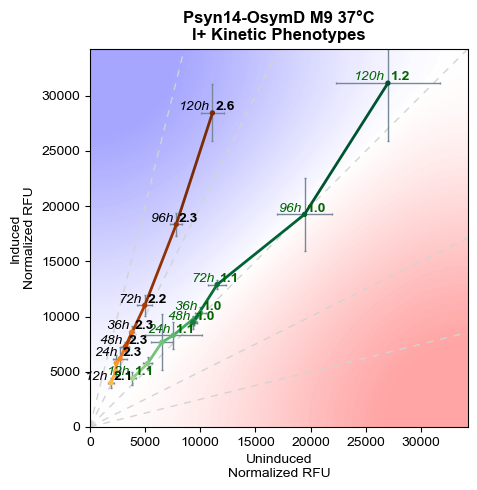

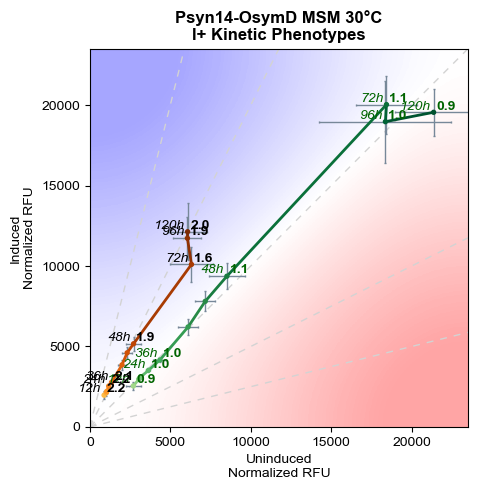

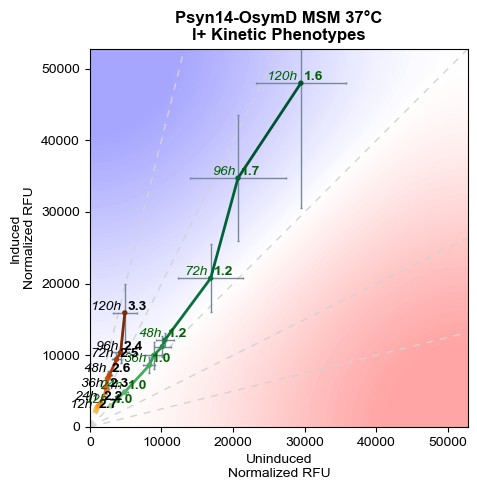

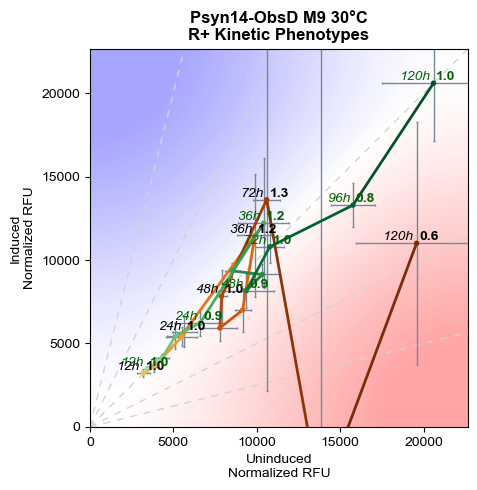

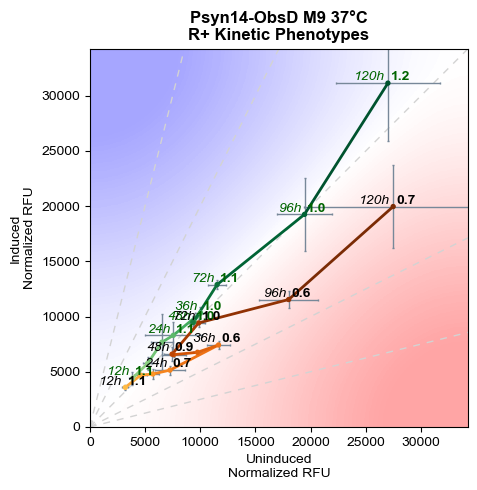

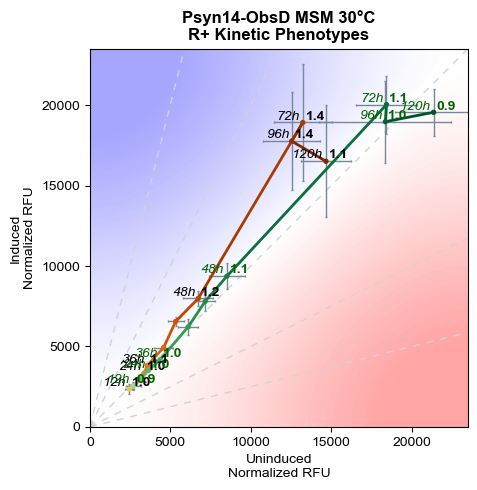

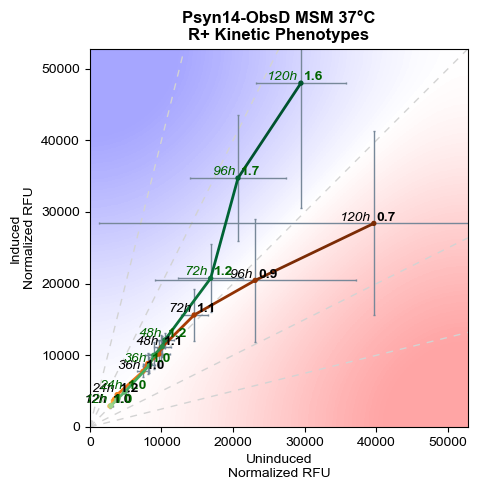

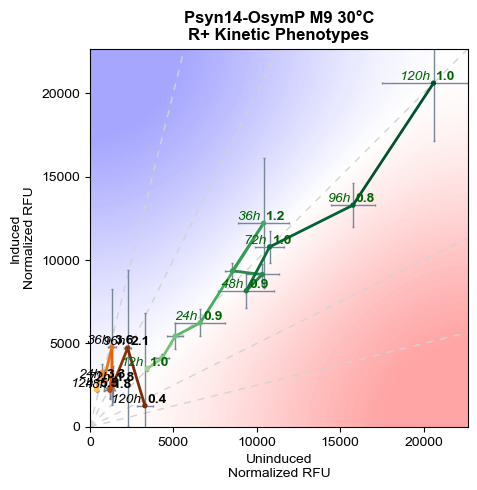

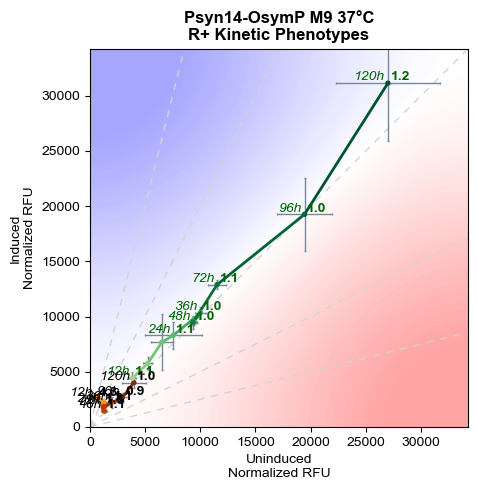

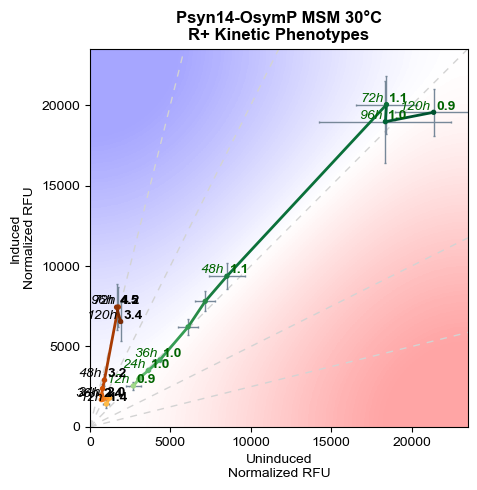

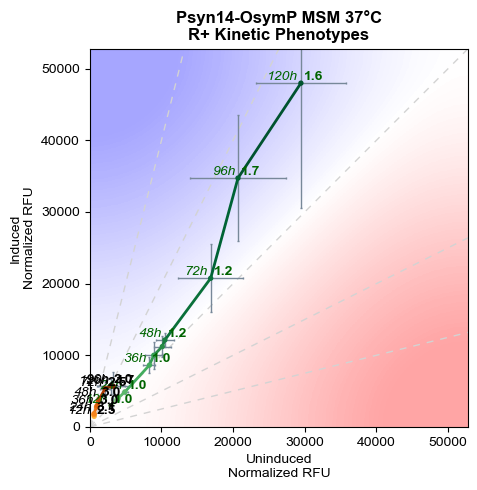

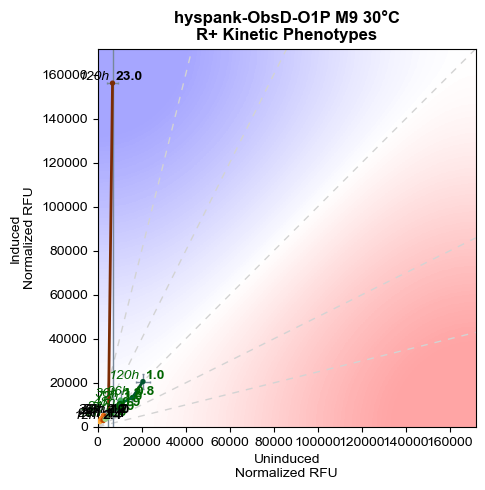

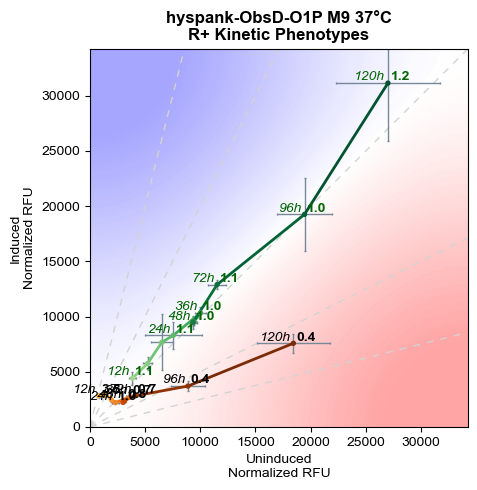

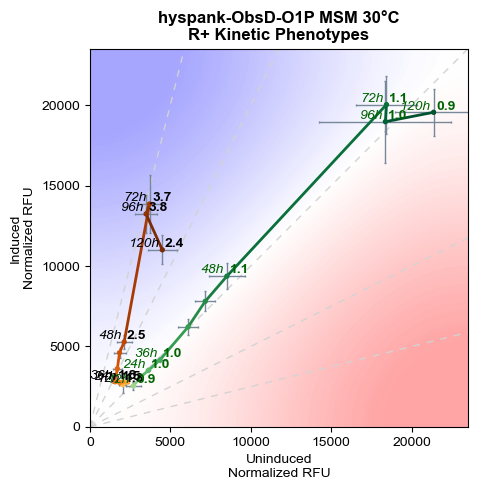

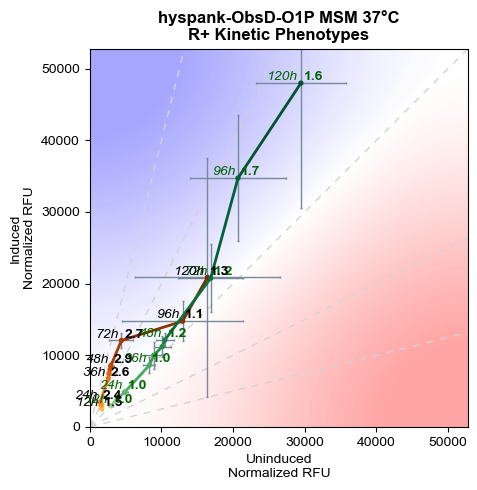

In [58]:
norm_FL = df_means.rowtrieve('Assay','Normalized Fluorescence')
global_xylim = max(norm_FL['Mean'].values)*1.1

pos_control = norm_FL.rowtrieve('Sample', 'Psyn14').induction_finder('Induction', 'IPTG')

for inducer in inducers:
    inducer_df = norm_FL.induction_finder('Induction',inducer)
    TF = IND_translate[inducer]
    grouping_keys = ['Sample','Media','Temperature']
    
    if 'Induction schedule' in inducer_df.columns:
        inducer_df = inducer_df.loc[inducer_df['Sample'] != 'Psyn14']
        grouping_keys.append('Induction schedule')

    for df_tuple in inducer_df.groupby(grouping_keys):
        df = df_tuple[1]
        
        cond_pos_control = pos_control
        PC_keys = grouping_keys.copy()
        PC_keys.remove('Sample')
        
        if 'Induction schedule' in df.columns:
            PC_keys.remove('Induction schedule')
        
        for cond, col in zip(df_tuple[0][1:], PC_keys):
            cond_pos_control = cond_pos_control.rowtrieve(col,cond)
            
        OFF_PC = cond_pos_control.induction_finder('Induction', '\+ 0 mM')
        ON_PC = cond_pos_control.induction_finder('Induction', '\+ 10 mM')
        
        OFF = df.induction_finder('Induction', '\+ 0 mM')
        ON = df.induction_finder('Induction', '\+ 10 mM')
        ON = ON.loc[~ON['Induction'].str.contains('@ 12h')]
        
        if 'Induction schedule' in df.columns:
            
            cond_OFF = inducer_df.copy()
            OFF_keys = grouping_keys.copy()
            remove_index = grouping_keys.index('Induction schedule')
            OFF_keys.remove('Induction schedule')
            OFF_values = list(df_tuple[0])
            OFF_values.pop(remove_index)
            
            
            for i in range(len(OFF_keys)):
                cond_OFF = cond_OFF.rowtrieve(OFF_keys[i],OFF_values[i])
        
            OFF_PC = cond_pos_control.rowtrieve('Induction schedule', '---')
            ON_PC = cond_pos_control.loc[cond_pos_control['Induction schedule'] != '---']   
            
            OFF = cond_OFF.rowtrieve('Induction schedule', '---')
            ON = df.loc[df['Induction schedule'] != '---']   
            
        pretty_plotterator(df_tuple[1], tf = TF,\
                       xdata = OFF['Mean'], ydata = ON['Mean'], xSD = OFF['StDev'], ySD = ON['StDev'],\
                           xPC = OFF_PC['Mean'], yPC = ON_PC['Mean'], xSD_PC = OFF_PC['StDev'], ySD_PC = ON_PC['StDev'],\
                       title = df_tuple[0], annotate = True, draw_classes = False, global_window = False,\
                               plot_PC = True, plot_DRs = True)
        plt.tight_layout()
        plt.show()

In [ ]:
'''
This module analyzes an experiment as a kinetic collection of timepoints, 
with single timepoints constituting their own Excel files.

To work properly, files should be named so as to comply with the time_parser function, i.e.:
The timepoint should be written into the file name as the last string before extension and separated by an underscore.
Acceptable units are 'h' (hours), 'm' (minutes), and 's' (seconds).

e.g.: 20230803_BASF_timepoints_12h
The program would interpret the above as the 12-hour timepoint.
'''

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from matplotlib import ticker as mticker
import matplotlib as mpl
import copy
import itertools
from itertools import product

'''Setting initial parameters for plotting'''

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['errorbar.capsize'] = 2

'''
Cleans results file directory to ensure most-recent run of code has produced output figures.
If such directory does not yet exist, makes the directory.
'''
results_location = os.path.join(absolute_path, 'results/', file_target)

if not os.path.exists(results_location):
    os.makedirs(results_location)
if os.path.exists(results_location):
    for file in glob.glob(results_location + '*.png'):
        os.remove(file)

def time_parser(string):
    return_value = None
    try:
        return_value = string.hour + string.minute/60 + string.second/3600
        
    except:
        splitstring = string.split('_')[-1]
        unit = splitstring.lstrip('0123456789')
        value = splitstring[:-len(unit)]

        if unit == 'h':
            return_value = float(value)
        if unit == 'm':
            return_value = float(value)/60
        if unit == 's':
            return_value = float(value)/3600
        
    return return_value

IND_translate = {'ribose': 'R+', 'IPTG': 'I+'}

inducers = []
for inducer_condition in df_means['Induction'].unique():
    inducer = inducer_condition.split()[-1]
    if inducer not in inducers:
        inducers.append(inducer)
# print(inducers)

df_means['Time'] = df_means.get('Time', df_means['Experiment'].apply(time_parser))    
cmaps = [mpl.colormaps['Blues'], mpl.colormaps['Reds'], mpl.colormaps['Greens'],mpl.colormaps['Greys']]
results_location = os.path.join(absolute_path, 'results/', file_target, '')
        
# print(df_means)

promoter = 'Psyn14'

expt_df = df_means.loc[df_means['Sample'] != promoter]
PC_df = df_means.loc[df_means['Sample'] == promoter]

for inducer in inducers:
    inducer_df = expt_df.loc[expt_df['Induction'].str.contains(inducer)]
    TF = IND_translate[inducer]
    
#     print(inducer_df)
    varkeys = []
    for column in inducer_df:
        if len(inducer_df[column].unique()) > 1 and column not in ['Experiment','Induction','Mean','StDev','Replicates','Time', 'Induction schedule']:
            varkeys.append(column)
            
    for assay in inducer_df.groupby(varkeys):
        assay_df = assay[1]
#         print(assay_df)
        
        xdata = assay_df['Time']
        ydata = assay_df['Mean']
        stdev = assay_df['StDev']
        
        fig, ax = plt.subplots() 
        ax.errorbar(xdata, ydata,yerr=stdev)
        plt.show()
# #                         color = color_lookup[condition[0]][0](next(color_lookup[condition[0]][1])),\

#     combispace = {key:list(assay_df[key].unique()) for key in varkeys}
    
#     cmaps_temps = [mpl.colormaps['Blues'], mpl.colormaps['Reds']]
#     cmaps_media = [mpl.colormaps['Greys'],mpl.colormaps['Greens']]
#     cmaps_loci = [mpl.colormaps['Purples'], mpl.colormaps['Oranges']]
#     cmaps_passagetime = [mpl.colormaps['Blues'], mpl.colormaps['Reds']]
    
#     dict_cmaps = dict.fromkeys(combispace)
#     dict_cmaps['Sample'] = cmaps_loci
#     dict_cmaps['Media'] = cmaps_media
#     dict_cmaps['Plate'] = cmaps_temps
#     dict_cmaps['Days pre-cultured'] = cmaps_passagetime

    
#     for key in combispace:
#         other_keys = list(combispace.keys())
#         other_keys.remove(key)
#         alt_dims = [combispace[other_key] for other_key in other_keys]
#         cmaps = dict_cmaps[key]
        
        
#         for constants in product(alt_dims[0],alt_dims[1]):
#             fig, ax = plt.subplots() 
#             plot_df = assay_df.rowtrieve(other_keys[0],constants[0]).rowtrieve(other_keys[1],constants[1]) 
            
#             samplist = plot_df[key].unique()
#             color_iterator = iter(np.linspace(0.4,0.9,len(plot_df['Induction'].unique())))
#             try:
#                 color_lookup = {samplist[j]: (cmaps[j], copy.deepcopy(color_iterator)) for j in range(len(samplist))}
#             except:
#                 print(key)
#             for condition in product(samplist, plot_df['Induction'].unique()):
#                 lstyle = 'solid'
#                 if '@ 12h' in condition[1]:
#                     lstyle = 'dotted'
                
#                 line_df = plot_df.rowtrieve(key,condition[0]).rowtrieve('Induction',condition[1]) 
#                 ax.errorbar(line_df['Time'], line_df['Mean'], label=condition, yerr=line_df['StDev'],\
# #                         color = color_lookup[condition[0]][0](next(color_lookup[condition[0]][1])),\
#                            linestyle = lstyle)
#             if len(samplist) > 1:
#                 comparison = samplist[0] + ' v. ' + samplist[1]
#             else:
#                 comparison = ''
#             plot_title = 'Kinetic ' + assay[0] + '\n' + comparison \
#     + '\n' + constants[0] + ', ' + constants[1] + ' constant'
# #             fig.suptitle('Kinetic ' + assay[0], fontweight='bold')
#             ax.set_title(plot_title)
#             ax.legend()
#             if assay[0] == 'Absorbance':
#                 ax.set_ylabel('OD600')
# #                 ax.set_ylim(0,1.6)
#             elif 'Fluorescence' in assay[0]:
#                 ax.set_ylabel('RFU')
# #                 ax.set_ylim(0,10000)
#             ax.set_xlabel('Time (hours)')
            
#             save_title = 'Kinetic ' + assay[0] + comparison + constants[0] + ', ' + constants[1] + ' constant'
            
#             plt.tight_layout()
#             plt.savefig(results_location + save_title + '.png')
#             plt.show()

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy

cmaps = [mpl.colormaps['Reds'], mpl.colormaps['Blues'], mpl.colormaps['Greens'],mpl.colormaps['Greys']]

fig,ax = plt.subplots()

samplist = ['a','b','c','d']
values = [1,2,3,4,5]

color_iterator = iter(np.linspace(0,1,len(values)))
color_lookup = {samplist[j]: (cmaps[j], copy.deepcopy(color_iterator)) for j in range(len(samplist))}

for samp in samplist:
    print(samp)
    for val in values:
        x = np.random.rand(4,1)
        y = np.random.rand(4,1)
        ax.plot(x,y, color = color_lookup[samp][0](next(color_lookup[samp][1])))


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

# The x and y data to plot
y = np.array([1,2,17,20,16,3,5])
x = np.arange(len(y))
gradient = mpl.colormaps['Greys']

# Threshold above which the line should be red
threshold = 15

# Create line segments: 1--2, 2--17, 17--20, 20--16, 16--3, etc.
segments_x = np.r_[x[0], x[1:-1].repeat(2), x[-1]].reshape(-1, 2)
segments_y = np.r_[y[0], y[1:-1].repeat(2), y[-1]].reshape(-1, 2)
print(segments_x)
print(segments_y)

# Assign colors to the line segments
color_iterator = iter(np.linspace(0.4,0.9,len(y)))
color_lookup = {samplist[j]: (cmaps[j], copy.deepcopy(color_iterator)) for j in range(len(samplist))}

linecolors = [gradient(0.3+list(x).index(x_)/len(x)) for x_ in x]

print((list(x).index(x_)/len(x)) for x_ in x)

# Stamp x,y coordinates of the segments into the proper format for the
# LineCollection
segments = [list(zip(x_, y_)) for x_, y_ in zip(segments_x, segments_y)]
print(segments)
# Create figure
plt.figure()
ax = plt.axes()

# Add a collection of lines
ax.add_collection(LineCollection(segments, colors=linecolors))

# Set x and y limits... sadly this is not done automatically for line
# collections
ax.set_xlim(0, 8)
ax.set_ylim(0, 21)

In [ ]:
blah = 'foo'

print(''.join([x for x in blah]))

In [ ]:
mpl.colormaps['Blues'](10000)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection

x = np.arange(100)
# Here are many sets of y to plot vs. x
ys = x[:50, np.newaxis] + x[np.newaxis, :]

segs = np.zeros((50, 100, 2))
segs[:, :, 1] = ys
segs[:, :, 0] = x

print(segs)

# Mask some values to test masked array support:
segs = np.ma.masked_where((segs > 50) & (segs < 60), segs)

# We need to set the plot limits, they will not autoscale
fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ys.min(), ys.max())

# *colors* is sequence of rgba tuples.
# *linestyle* is a string or dash tuple. Legal string values are
# solid|dashed|dashdot|dotted.  The dash tuple is (offset, onoffseq) where
# onoffseq is an even length tuple of on and off ink in points.  If linestyle
# is omitted, 'solid' is used.
# See `matplotlib.collections.LineCollection` for more information.
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

line_segments = LineCollection(segs, linewidths=(0.5, 1, 1.5, 2),
                               colors=colors, linestyle='solid')
ax.add_collection(line_segments)
ax.set_title('Line collection with masked arrays')
plt.show()

In [ ]:
legend_segments = [[(1,0),(1,1)],[(1,1),(1,2)],[(1,2),(1,3)],[(1,3),(1,4)]]
scale_f = 1000
legend_segments = [[(a*scale_f,b*scale_f*0.1) for sublist in legend_segments for (a,b) in sublist]]
print(legend_segments)

In [ ]:
# print(df_reps)
df_reps.rowtrieve('Sample','Psyn14').rowtrieve('Media', 'MSM').rowtrieve('Temperature', '30°C').rowtrieve('Well','D12')

In [ ]:
# Python3 code to demonstrate
# convert dictionary string to dictionary
# using eval()
 
# initializing string
test_string = '{"Nikhil" : 1, "Akshat" : 2, "Akash" : 3}'
 
# printing original string
print("The original string : " + str(test_string))
 
# using eval()
# convert dictionary string to dictionary
res = eval(test_string)
 
# print result
print("The converted dictionary : " + str(res))

In [ ]:
res['Nikhil']

In [1]:
v

In [177]:
'''
The following variables define functional classfication parameters as shown on expression plots
'''
NF_DR_mult = 0.2 # max percent difference between states to classify as non-functional; corresponds to DR = (1+x) and DR = 1/(1+x)
SR_val = 0.3 # max relative value to classify as super-repressor
SR_tighten = 0.3 # value between 0 and 1 that tightens the flanks of the super-repressor window. 0 disables.

'''
This module defines a function that generates pretty scatterplots from a pandas dataframe 
containing x- and y-data in columns labeled 'Expression (-)' and 'Expression (+)', respectively,
with standard deviations in columns labeled 'SD (-)' and 'SD (+)'
'''

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from adjustText import adjust_text

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

df_means['Time'] = df_means.get('Time', df_means['Experiment'].apply(time_parser))    

def pretty_plotterator(df, tf = None, draw_classes = True, show_SD = True, plot_DRs = True, global_window = True, plot_PC = True,\
                       DRs_to_plot = [0.25, 0.5, 1, 2, 4], size = 3, title = 'Experiment Title',\
                       xdata = None, ydata = None, xSD = None, ySD = None,\
                       xPC = None, yPC = None, xSD_PC = None, ySD_PC = None, \
                       paramA = NF_DR_mult, paramB = SR_val, paramC = SR_tighten):

    title = ' '.join(x for x in title)
    fill_intensity = 1 #how opaque drawn polygons representing classes are; recommend value = 1 ; max value 2


    'initializing and labeling axes'
    fig = plt.figure(figsize=(6,5))

    ax1 = fig.add_subplot()
    ax1.set_xlabel('Uninduced\nNormalized RFU')
    ax1.set_ylabel('Induced\nNormalized RFU')
    ax1.set_title(title + '\n' + tf + ' Kinetic Phenotypes', weight = 'bold')


    '''Cannibalized code used to draw the background (blue-white-red) diagonal gradient'''
    def gradient_image(ax, cmap_range=(0, 1), **kwargs):
        X = np.array([[0, 1],
                      [1, 2]])
        a, b = cmap_range
        X = a + (b - a) / X.max() * X
        im = ax.imshow(X, interpolation='lanczos', clim=(0,1),
                       aspect='auto', **kwargs)
        return im
    
    values = [val for sublist in [xdata.values, ydata.values] for val in sublist]
    xylim = max(values)*1.1
    
    if plot_PC == True:
        PC_values = [val for sublist in [xPC.values, yPC.values] for val in sublist]
        plot_values = [val for sublist in [values, PC_values] for val in sublist]
        xylim = max(plot_values)*1.1
    
    if global_window == True:
        xylim = global_xylim
    
    gradient_image(ax1, extent=(0, xylim, 0, xylim),
                   cmap=plt.cm.bwr, # fyi, 'bwr' here defines the blue-white-red color gradient used
                   cmap_range=(0.3, 0.7), alpha=0.7) #messing with these variables shifts range of gradient and its opacity
    
    '''Adds y = mx lines of constant dynamic range for m in DRs_to_plot'''
    if plot_DRs == True:
        for DR in DRs_to_plot:
            xDR = np.linspace(0, int(xylim), 100)
            yDR = xDR*DR

            ax1.plot(xDR, yDR, linewidth=1, ls = (0, (5,5)), color = 'lightgray', zorder = 1, label = 'DR = ' + str(DR))
            
#             DR_loc = (1,1*DR)
#             DR_loc = tuple(i/max(DR_loc) for i in DR_loc)
#             ax1.text(DR_loc[0],DR_loc[1], 'DR = ' + str(DR), ha='center', transform=ax1.transAxes)
    """Ugly hardcoding to draw functional classification zones on plot based on varables defined above"""
    if draw_classes:
        ax1.fill([paramB/(1+paramA),1/(1+paramA),1,1,paramB], [paramB,1,1,1/(1+paramA),paramB/(1+paramA)],
                 color = 'lightgray', alpha = fill_intensity*0.5, transform = ax1.transAxes)  
        ax1.fill([0,0,paramB*1/(1+paramA),paramB,paramB*(1-paramC)], [0,paramB*(1-paramC),paramB,paramB*1/(1+paramA),0],
                 color = 'wheat', alpha = fill_intensity*0.5, transform = ax1.transAxes)
        ax1.fill([paramB*(1-paramC),paramB,1,1], [0,paramB*1/(1+paramA),1/(1+paramA),0],
                 color = 'red', alpha = fill_intensity*0.01, transform = ax1.transAxes)
        ax1.fill([0,0,1/(1+paramA),paramB*1/(1+paramA)], [paramB*(1-paramC),1,1,paramB],
                 color = 'blue', alpha = fill_intensity*0.01, transform = ax1.transAxes)

    '''~actual plotting~'''

    # The x and y data to plot
    y = ydata.values
    x = xdata.values
    xpc = xPC.values
    ypc = yPC.values

    def gradient_line(x,y,gradient):
        segments_x = np.r_[x[0], x[1:-1].repeat(2), x[-1]].reshape(-1, 2)
        segments_y = np.r_[y[0], y[1:-1].repeat(2), y[-1]].reshape(-1, 2)


        linecolors = [gradient(0.4+0.6*list(x).index(x_)/len(x)) for x_ in x[1:]]
        pointcolors = [gradient(0.4+0.6*list(x).index(x_)/len(x)) for x_ in x]

        segments = np.dstack((segments_x,segments_y))
        
        return segments, linecolors, pointcolors
    
    d_segments, d_linecolors, d_pointcolors = gradient_line(x, y, mpl.colormaps['YlOrBr'])
    PC_segments, PC_linecolors, PC_pointcolors = gradient_line(xpc, ypc, mpl.colormaps['YlGn'])
    
    
    
    timepoints = [str(int(round(x,0))) + 'h' for x in df['Time'].unique()]
#     print(timepoints)
    if 'Induction schedule' in df.columns:
        d_segments, d_linecolors, d_pointcolors = gradient_line(x, y, mpl.colormaps['Greys'])
        
        induction_times = ['0h','12h','24h']
        schedule = df['Induction schedule'].unique()[0]
        
        for i in range(len(schedule)):
            if schedule[i] == '+':
                if induction_times[i] == '0h':
                    d_pointcolors[0] = 'darkred'
                else:
                    d_pointcolors[timepoints.index(induction_times[i])+1] = 'darkred'
                    d_linecolors[timepoints.index(induction_times[i])] = 'r'
                    
#                     print(timepoints.index(induction_times[i]))
#         print(schedule)
    
    '''Maybe for creating a legend?'''
#     [(np.dstack((x_, y_)) for x_, y_ in zip(segments_x, segments_y))]
#     print(segments)
#     print(np.shape(segments))

#     legend_segments = [[(1,0),(1,1)],[(1,1),(1,2)],[(1,2),(1,3)],[(1,3),(1,4)]]
#     scale_f = xylim
#     legend_segments = np.array([[(a*scale_f,b*scale_f*0.1) for (a,b) in sublist] for sublist in legend_segments])
#     print(legend_segments)
    
#     segments = np.append(segments, legend_segments, axis=0)
#     segments = np.concatenate((segments, legend_segments), axis=0)
    
#     print(np.shape(segments))

    ax1.set_xlim([0,xylim])
    ax1.set_ylim([0,xylim])
    
    ax1.add_collection(LineCollection(d_segments, colors=d_linecolors, zorder = 3, linewidth = 2))
    ax1.scatter(xdata, ydata, s=8, color = d_pointcolors, zorder=3)
    
    if plot_PC == True:
        ax1.add_collection(LineCollection(PC_segments, colors=PC_linecolors, zorder = 3, linewidth = 2))
        ax1.scatter(xPC, yPC, s=8, color = PC_pointcolors, zorder=3)
    
    for i, txt in enumerate(timepoints):
        time_labels = ax1.annotate(txt, (x[i],y[i]), xytext = (-2,2), textcoords = 'offset points', ha = 'right', style = 'italic')
        DR_labels = []
#         adjust_text([ax1.text(x[i],y[i], txt)])
        if plot_DRs == True:
            DR_labels = ax1.annotate(str(round(y[i]/x[i],1)), (x[i],y[i]), xytext = (2,2), textcoords = 'offset points', weight = 'bold')
#         labels = time_labels
#         for x in DR_labels:
#             labels.append(x)
#         print(labels)
#         adjust_text(labels)
        if plot_PC == True:
            PC_time_labels = [ax1.annotate(txt, (xpc[i],ypc[i]), xytext = (-2,2), textcoords = 'offset points', ha = 'right', style = 'italic')]
            if plot_DRs == True:
                PC_DR_labels = [ax1.annotate(str(round(ypc[i]/xpc[i],1)), (xpc[i],ypc[i]), xytext = (2,2), textcoords = 'offset points', weight = 'bold')]

    '''plotting errorbars'''
    if show_SD == True:
        ax1.errorbar(xdata, ydata, xerr=xSD, yerr=ySD, fmt=',', ecolor='lightslategray', elinewidth=1, capsize=1)
        if plot_PC == True:
            ax1.errorbar(xPC, yPC, xerr=xSD_PC, yerr=ySD_PC, fmt=',', ecolor='lightslategray', elinewidth=1, capsize=1)
    

            
            
    ax1.set_aspect('equal', adjustable='box')
    plt.savefig(results_location + title + '.png')


In [262]:
sscript_translate = {'O1P': 'O\u00b9P', 'ObsP': 'O\u1d47\u02e2P', 'OsymP': 'OsymP'}



print(sscript_translate['ObsP'])

print("x\u00b9 + y\u00b2 = 2")  

OᵇˢP
x¹ + y² = 2


In [288]:
print(isinstance(False, int))

True


In [18]:
import re
for file in sorted(glob.glob(data_location + '*.xls*'), key = lambda x: int(re.sub('\D', '', x))):
    if '.xlsx' in file and file_target in file:
        print(re.sub('\D', '', file))

320230928112712
320230928112716
320230928112720
320230928112724
320230928112736
320230928112740
320230928112744
320230928112748
320230928112772
320230928112796
3202309281127120


In [15]:
re.sub('\D', '', 'aas30dsa20')


print(sorted([1,2,10,12,20,4]))

[1, 2, 4, 10, 12, 20]


In [26]:
print(df_means.sort_values('Time'))

              Sample       Induction Media Temperature   Plate  \
0       Psyn14-OsymP  + 10 mM ribose   MSM        30°C  Plate2   
0   hyspank-ObsD-O1P  + 10 mM ribose   MSM        30°C  Plate2   
0         Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3   
0       Psyn14-OsymD     + 0 mM IPTG    M9        37°C  Plate7   
0       Psyn14-OsymP  + 10 mM ribose   MSM        30°C  Plate2   
..               ...             ...   ...         ...     ...   
0        Psyn14-ObsP     + 0 mM IPTG    M9        37°C  Plate7   
0   hyspank-ObsD-O1P   + 0 mM ribose   MSM        37°C  Plate6   
0        Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3   
0        Psyn14-ObsP     + 0 mM IPTG   MSM        37°C  Plate8   
0             Psyn14     + 0 mM IPTG    M9        30°C  Plate3   

                      Assay                                Experiment  \
0   Normalized Fluorescence   20230928_▲11-▲27_kinetic_timepoints_12h   
0              Fluorescence   20230928_▲11-▲27_kinetic_timepo

['hha']
[False]
it's colon time, baby
None
['3600s']
[False]
it's colon time, baby
1.0
['3600m']
[False]
it's colon time, baby
60.0
['wefadf_3600h']
[False]
it's colon time, baby
3600.0
['12', '13', '14']
[False, False, False]
it's colon time, baby
None


In [104]:

    
# for group in df_means.groupby(['Temperature','Assay','Time']):
#     print(group[1])

In-group variables:
['Sample', 'Induction', 'Media', 'Temperature']


Out-of-group variables:
['Assay', 'Time']


             Sample       Induction Media Temperature   Plate       Assay  \
0            Psyn14     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0            Psyn14    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0        Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0        Psyn14-O1P    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0       Psyn14-ObsD   + 0 mM ribose    M9        30°C  Plate1  Absorbance   
0       Psyn14-ObsD  + 10 mM ribose    M9        30°C  Plate1  Absorbance   
0       Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0       Psyn14-ObsP    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0      Psyn14-OsymD     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0      Psyn14-OsymD    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0      Psyn14-OsymP   + 0 mM ribose    

             Sample       Induction Media Temperature   Plate  \
0            Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0            Psyn14    + 10 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3   
0        Psyn14-O1P    + 10 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsD   + 0 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsD  + 10 mM ribose    M9        30°C  Plate1   
0       Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3   
0       Psyn14-ObsP    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD     + 0 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymD    + 10 mM IPTG    M9        30°C  Plate3   
0      Psyn14-OsymP   + 0 mM ribose    M9        30°C  Plate1   
0      Psyn14-OsymP  + 10 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P   + 0 mM ribose    M9        30°C  Plate1   
0  hyspank-ObsD-O1P  + 10 mM ribose    M9        30°C  Plate1   
0            Psyn14     +

In [106]:
def inverse_column_groupby(df, ignore_cols, redundant_cols = ['Plate','Experiment'],\
                       always_ignore_cols = ['Mean','StDev','Replicates']):
    column_list = []
    for column in df.columns:
        if column not in list(x for x in (ignore_cols + redundant_cols + always_ignore_cols)) and len(df[column].unique()) != 1:
            column_list.append(column)

    return df.groupby(column_list)

group_vars = ['Sample','Induction','Media','Temperature']
for group in inverse_column_groupby(df_means, group_vars):
    print(group[1])
    

             Sample       Induction Media Temperature   Plate       Assay  \
0            Psyn14     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0            Psyn14    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0        Psyn14-O1P     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0        Psyn14-O1P    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0       Psyn14-ObsD   + 0 mM ribose    M9        30°C  Plate1  Absorbance   
0       Psyn14-ObsD  + 10 mM ribose    M9        30°C  Plate1  Absorbance   
0       Psyn14-ObsP     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0       Psyn14-ObsP    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0      Psyn14-OsymD     + 0 mM IPTG    M9        30°C  Plate3  Absorbance   
0      Psyn14-OsymD    + 10 mM IPTG    M9        30°C  Plate3  Absorbance   
0      Psyn14-OsymP   + 0 mM ribose    M9        30°C  Plate1  Absorbance   
0      Psyn14-OsymP  + 10 mM ribose    M9        30°C  Plate1  Absorbance   

+ 0 mM IPTG
+ 10 mM IPTG


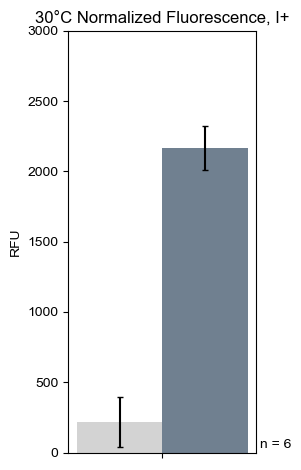

+ 0 mM IPTG
+ 10 mM IPTG


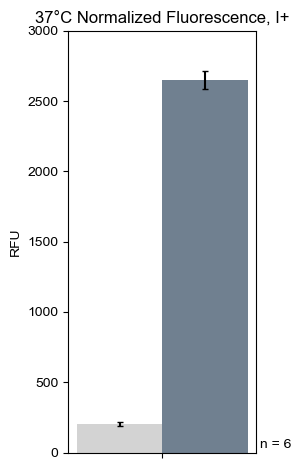

+ 0 mM ribose
+ 10 mM ribose


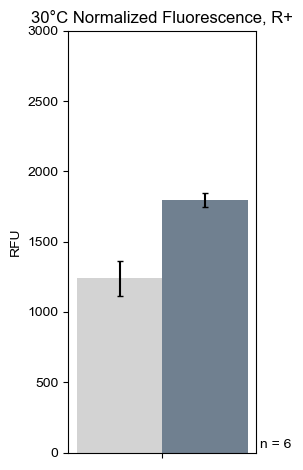

+ 0 mM ribose
+ 10 mM ribose


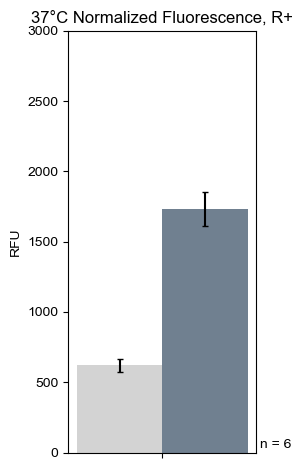

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from matplotlib import ticker as mticker

'''Setting initial parameters for plotting'''

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['errorbar.capsize'] = 2

cleaning_table = {key: False for key in df_means['Experiment'].unique()}

# print(df_means)
thisdf = df_means.rowtrieve('Time', 16.0).rowtrieve('Assay', 'Normalized Fluorescence').rowtrieve('Media', 'MSM')
# print(thisdf)

for inducer in inducers:

    inducer_df = thisdf.loc[thisdf['Induction'].str.contains(inducer)]
    TF = IND_translate[inducer]

    if inducer == 'IPTG':
        inducer_df = inducer_df.rowtrieve('Sample', 'Psyn14-O1P')
        
    if inducer == 'ribose':
        inducer_df = inducer_df.rowtrieve('Sample', 'Psyn14-OsymP')
    '''Iterates by assay type and plate to plot double-bar graphs'''
    for group in inducer_df.groupby(['Assay', 'Temperature', 'Experiment']):
        
        results_location = os.path.join(absolute_path, 'results/', group[0][2], '')
        
        '''
        Cleans results file directory to ensure most-recent run of code has produced output figures.
        If such directory does not yet exist, makes the directory.
        '''
        if not os.path.exists(results_location):
            os.makedirs(results_location)
        if os.path.exists(results_location) and cleaning_table[group[0][2]] == False and TF in file:
            for file in glob.glob(results_location + '*.png'):
                os.remove(file)
            cleaning_table[group[0][2]] = True
            
        labels = group[0]
        df = group[1]
        
        inductions = tuple(df['Induction'].unique())
        width = 1/(len(inductions)+1.2)
        multiplier = 0

        fig, ax = plt.subplots() 

        for cond in inductions:
            '''Selects data for a specific induction condition'''
            cond_df = df.rowtrieve('Induction', cond)
#             print(cond_df)
            
            '''Dynamically generates xlabels from unique identifier data given from Excel sheet'''
            naming_df = pd.DataFrame()
            for column in cond_df.columns:
                if column not in ['Mean','StDev','Replicates'] and len(cond_df[column].unique()) != 1:
                    naming_df[column] = cond_df[column]
                    
            names = []
            
#             print(naming_df)
            for index,row in naming_df.iterrows():
                DR_pair = df.copy()
                for axis in row.axes[0]:
                    DR_pair = DR_pair.rowtrieve(axis,row[axis])
                
                ON = DR_pair.induction_finder('Induction', '\+ 10 mM')['Mean']
                OFF = DR_pair.induction_finder('Induction', '\+ 0 mM')['Mean']
                dynamic_range = round((ON/OFF).values[0],1)
                
                ymax = max(ON.values[0],OFF.values[0])
                
                if DR_pair.induction_finder('Induction', '\+ 10 mM')['Mean'].values[0] < 100:
                    dynamic_range = None
                    
                if 'Plate' in row.index:
                    row = row.drop('Plate')
                name = '\n'.join(row)
                names.append((name, dynamic_range, ymax))                   
            
            '''
            Defines data, errors to be plotted and plots bars for the induction condition.
            Combination of x, width, and multiplier variables ensure correct x-location of each bar.
            '''
#             def color_maker(df):
#                 df['Color'] = None
#                 for index in df.index:
#                     print(index)
#                     if '+ 0 mM' in df.iloc[index]['Induction'] and df.iloc[index]['Media'] == 'M9':
#                         df.iloc[index]['Color'] = 'b'
#                         print(df.iloc[index]['Color'])
                        
#                 return df['Color']
                    
 #             cond_df['Color'] = color_maker(cond_df)
#             print(cond_df)

            means = tuple(cond_df['Mean'])
            stdevs = tuple(cond_df['StDev'])
            

            x = np.arange(len(cond_df.index))        
            offset = width*multiplier
            print(cond)
            if '+ 10 mM' in cond:
#                 print('ONNNN')
                rects = ax.bar(x + offset, means, width, label=cond, yerr=stdevs, color = 'slategray')
            elif '+ 0 mM' in cond:
#                 print('OFF')
                rects = ax.bar(x + offset, means, width, label=cond, yerr=stdevs, color = 'lightgray')    
            multiplier += 1       

        if len(thisdf['Experiment'].unique()) > 1:
            title = ' '.join([group[0][1], group[0][0] + ',', TF + ',', group[0][2].split('_')[-1]])

        else:
            title = ' '.join([group[0][1], group[0][0] + ',', TF])

        ax.set_title(title)

        if group[0][0] == 'Absorbance':
            ax.set_ylabel('OD600')
        elif 'Fluorescence' in group[0][0]:
            ax.set_ylabel('RFU')

#         ax.legend()
        x_locs = x + (len(inductions)-1)*width/2
        ax.set_xticks(x_locs, (x[0] for x in names), rotation = 'vertical')
        
        if group[0][0] == 'Normalized Fluorescence':
            for x_pos, label in zip(x_locs,names):
                ax.text(x_pos,1.02, label[1], ha='center', transform=ax.get_xaxis_transform(), fontstyle = 'italic')
                ax.set_title(title, y=1.0, pad=20)
                
            ax.set_ylim(0,3000)
            
        replicates = ' or '.join(str(number) for number in np.sort(df['Replicates'].unique()))
        ax.text(1.02,0.01,'n = '+ replicates, transform = ax.transAxes)
        
        fig.set_figwidth(width*10)
        plt.tight_layout()
        plt.savefig(results_location + title + '.png')
        plt.show()
    
    

In [131]:
'''
The following variables define functional classfication parameters as shown on expression plots
'''
NF_DR_mult = 0.2 # max percent difference between states to classify as non-functional; corresponds to DR = (1+x) and DR = 1/(1+x)
SR_val = 0.3 # max relative value to classify as super-repressor
SR_tighten = 0.3 # value between 0 and 1 that tightens the flanks of the super-repressor window. 0 disables.

'''
This module defines a function that generates pretty scatterplots from a pandas dataframe 
containing x- and y-data in columns labeled 'Expression (-)' and 'Expression (+)', respectively,
with standard deviations in columns labeled 'SD (-)' and 'SD (+)'
'''

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from adjustText import adjust_text

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

df_means['Time'] = df_means.get('Time', df_means['Experiment'].apply(time_parser))    

def pretty_plotterator(df, tf = None, draw_classes = True, show_SD = True, plot_DRs = True, global_window = True, plot_PC = True,\
                       annotate = True, plot_DR_guides = True, DRs_to_plot = [0.25, 0.5, 1, 2, 4],\
                       size = 3, title = 'Experiment Title',\
                       xdata = None, ydata = None, xSD = None, ySD = None,\
                       xPC = None, yPC = None, xSD_PC = None, ySD_PC = None, \
                       paramA = NF_DR_mult, paramB = SR_val, paramC = SR_tighten):

    title = ' '.join(x for x in title)
    fill_intensity = 1 #how opaque drawn polygons representing classes are; recommend value = 1 ; max value 2


    'initializing and labeling axes'
    fig = plt.figure(figsize=(6,5))

    ax1 = fig.add_subplot()
    ax1.set_xlabel('Uninduced\nNormalized RFU')
    ax1.set_ylabel('Induced\nNormalized RFU')
    ax1.set_title(tf + '-mediated Kinetic Phenotypes', weight = 'bold')


    '''Cannibalized code used to draw the background (blue-white-red) diagonal gradient'''
    def gradient_image(ax, cmap_range=(0, 1), **kwargs):
        X = np.array([[0, 1],
                      [1, 2]])
        a, b = cmap_range
        X = a + (b - a) / X.max() * X
        im = ax.imshow(X, interpolation='lanczos', clim=(0,1),
                       aspect='auto', **kwargs)
        return im
    
    values = [val for sublist in [xdata.values, ydata.values] for val in sublist]
    xylim = max(values)*1.1
    
    if plot_PC == True:
        PC_values = [val for sublist in [xPC.values, yPC.values] for val in sublist]
        plot_values = [val for sublist in [values, PC_values] for val in sublist]
        xylim = max(plot_values)*1.1
    
#     print(xylim)
#     print(type(global_window))

    if isinstance(global_window, bool):
        if global_window == True:
            xylim = global_xylim
    elif isinstance(global_window,int):
        xylim = global_window    
    
    gradient_image(ax1, extent=(0, xylim, 0, xylim),
                   cmap=plt.cm.bwr, # fyi, 'bwr' here defines the blue-white-red color gradient used
                   cmap_range=(0.3, 0.7), alpha=0.7) #messing with these variables shifts range of gradient and its opacity
    
    """Ugly hardcoding to draw functional classification zones on plot based on varables defined above"""
    if draw_classes:
        ax1.fill([paramB/(1+paramA),1/(1+paramA),1,1,paramB], [paramB,1,1,1/(1+paramA),paramB/(1+paramA)],
                 color = 'lightgray', alpha = fill_intensity*0.5, transform = ax1.transAxes)  
        ax1.fill([0,0,paramB*1/(1+paramA),paramB,paramB*(1-paramC)], [0,paramB*(1-paramC),paramB,paramB*1/(1+paramA),0],
                 color = 'wheat', alpha = fill_intensity*0.5, transform = ax1.transAxes)
        ax1.fill([paramB*(1-paramC),paramB,1,1], [0,paramB*1/(1+paramA),1/(1+paramA),0],
                 color = 'red', alpha = fill_intensity*0.01, transform = ax1.transAxes)
        ax1.fill([0,0,1/(1+paramA),paramB*1/(1+paramA)], [paramB*(1-paramC),1,1,paramB],
                 color = 'blue', alpha = fill_intensity*0.01, transform = ax1.transAxes)

    '''~actual plotting~'''

    # The x and y data to plot
    y = ydata.values
    x = xdata.values
    xpc = xPC.values
    ypc = yPC.values

    def gradient_line(x,y,gradient):
        segments_x = np.r_[x[0], x[1:-1].repeat(2), x[-1]].reshape(-1, 2)
        segments_y = np.r_[y[0], y[1:-1].repeat(2), y[-1]].reshape(-1, 2)


        linecolors = [gradient(0.4+0.6*list(x).index(x_)/len(x)) for x_ in x[1:]]
        pointcolors = [gradient(0.4+0.6*list(x).index(x_)/len(x)) for x_ in x]

        segments = np.dstack((segments_x,segments_y))
        
        return segments, linecolors, pointcolors
    
    d_segments, d_linecolors, d_pointcolors = gradient_line(x, y, mpl.colormaps['YlOrBr'])
    PC_segments, PC_linecolors, PC_pointcolors = gradient_line(xpc, ypc, mpl.colormaps['YlGn'])
    
    
    
    timepoints = [str(int(round(x,0))) + 'h' for x in df['Time'].unique()[:j]]
#     print(timepoints)
    if 'Induction schedule' in df.columns:
        d_segments, d_linecolors, d_pointcolors = gradient_line(x, y, mpl.colormaps['Greys'])
        
        induction_times = ['0h','12h','24h']
        schedule = df['Induction schedule'].unique()[0]
        
        for i in range(len(schedule)):
            if schedule[i] == '+':
                if induction_times[i] == '0h':
                    d_pointcolors[0] = 'darkred'
                else:
                    d_pointcolors[timepoints.index(induction_times[i])+1] = 'darkred'
                    d_linecolors[timepoints.index(induction_times[i])] = 'r'
                    
#                     print(timepoints.index(induction_times[i]))
#         print(schedule)
    
    '''Maybe for creating a legend?'''
#     [(np.dstack((x_, y_)) for x_, y_ in zip(segments_x, segments_y))]
#     print(segments)
#     print(np.shape(segments))

#     legend_segments = [[(1,0),(1,1)],[(1,1),(1,2)],[(1,2),(1,3)],[(1,3),(1,4)]]
#     scale_f = xylim
#     legend_segments = np.array([[(a*scale_f,b*scale_f*0.1) for (a,b) in sublist] for sublist in legend_segments])
#     print(legend_segments)
    
#     segments = np.append(segments, legend_segments, axis=0)
#     segments = np.concatenate((segments, legend_segments), axis=0)
    
#     print(np.shape(segments))

    ax1.add_collection(LineCollection(d_segments, colors=d_linecolors, zorder = 3, linewidth = 2))
    if plot_PC == True:
        ax1.add_collection(LineCollection(PC_segments, colors=PC_linecolors, zorder = 3, linewidth = 2))
    
      
    ax1.scatter(xdata, ydata, s=8, color = d_pointcolors, zorder=3)
    ax1.set_xlim([0,xylim])
    ax1.set_ylim([0,xylim]) 
    
    if plot_PC == True:
        ax1.scatter(xPC, yPC, s=8, color = PC_pointcolors, zorder=3)
        
        
    if annotate == True:
        for i, txt in enumerate(timepoints):
            if i+1 == (len(timepoints)):
                time_labels = ax1.annotate(txt, (x[i],y[i]), xytext = (-2,2), textcoords = 'offset points', ha = 'right', style = 'italic')
        #         time_labels = [ax1.annotate(txt, (x[i],y[i]), style = 'italic')]
                DR_labels = []
        #         adjust_text([ax1.text(x[i],y[i], txt)])
                if plot_DRs == True:
                    DR_labels = ax1.annotate(str(round(y[i]/x[i],1)), (x[i],y[i]), xytext = (2,2), textcoords = 'offset points', weight = 'bold')
        #             DR_labels = [ax1.annotate(str(round(y[i]/x[i],1)), (x[i],y[i]), weight = 'bold')]
        #         labels = time_labels
        #         for x in DR_labels:
        #             labels.append(x)
        #         print(labels)
                if plot_PC == True:
                    PC_time_labels = [ax1.annotate(txt, (xpc[i],ypc[i]), xytext = (-2,2), textcoords = 'offset points', ha = 'right', style = 'italic')]
                    if plot_DRs == True:
                        PC_DR_labels = [ax1.annotate(str(round(ypc[i]/xpc[i],1)), (xpc[i],ypc[i]), xytext = (2,2), textcoords = 'offset points', weight = 'bold')]

    '''plotting errorbars'''
    if show_SD == True:
        ax1.errorbar(xdata, ydata, xerr=xSD, yerr=ySD, fmt=',', ecolor='lightslategray', elinewidth=1, capsize=1)
        if plot_PC == True:
            ax1.errorbar(xPC, yPC, xerr=xSD_PC, yerr=ySD_PC, fmt=',', ecolor='lightslategray', elinewidth=1, capsize=1)
    
    if plot_DR_guides == True:
        for DR in DRs_to_plot:
            xDR = np.linspace(0, int(xylim), 100)
            yDR = xDR*DR

            ax1.plot(xDR, yDR, linewidth=1, ls = (0, (5,5)), color = 'lightgray', zorder = 1, label = 'DR = ' + str(DR))
            
            DR_loc = (1,1*DR)
            DR_loc = tuple(i/max(DR_loc) for i in DR_loc)
#             ax1.text(DR_loc[0],DR_loc[1], 'DR = ' + str(DR), ha='center', transform=ax1.transAxes)
            
            
    ax1.set_aspect('equal', adjustable='box')
#     adjust_text(labels, force_test = (100,100))
    
    plt.savefig(results_location + title + '.png')


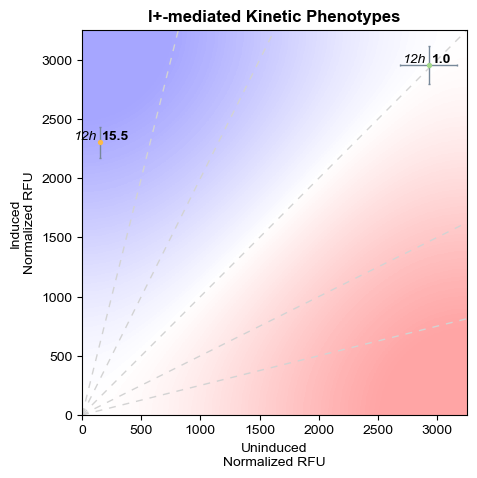

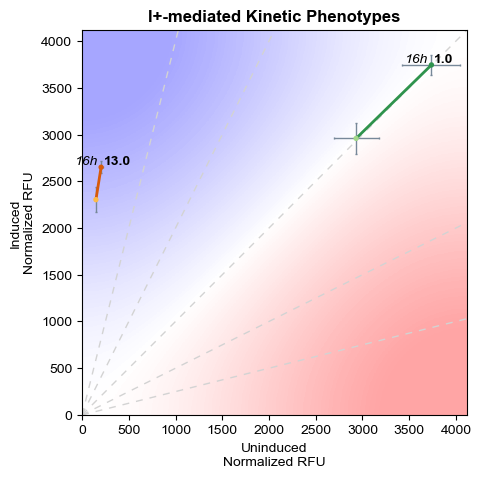

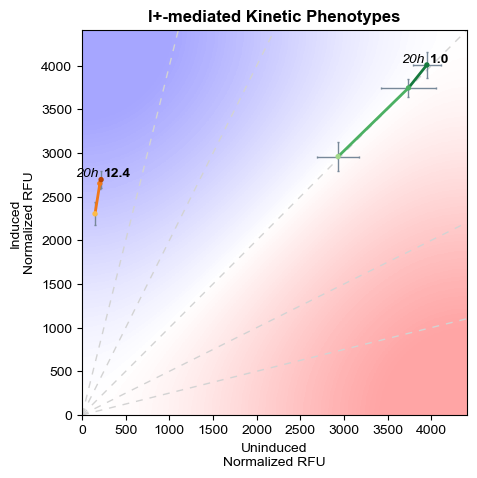

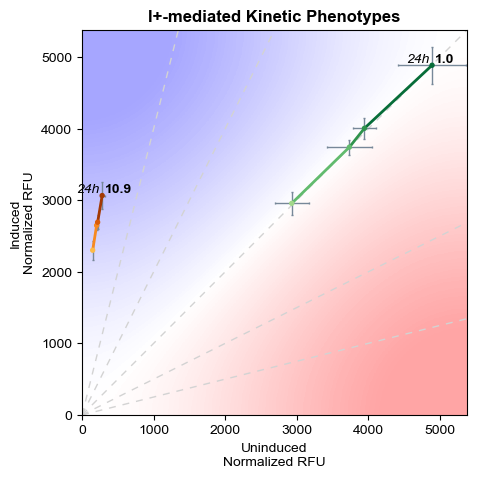

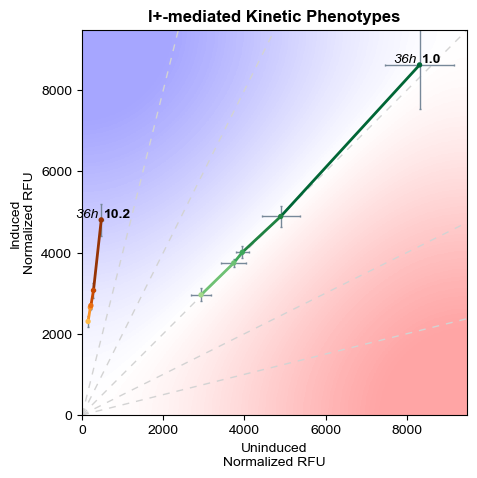

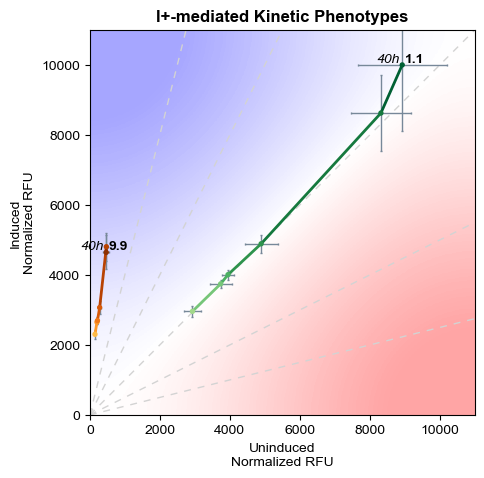

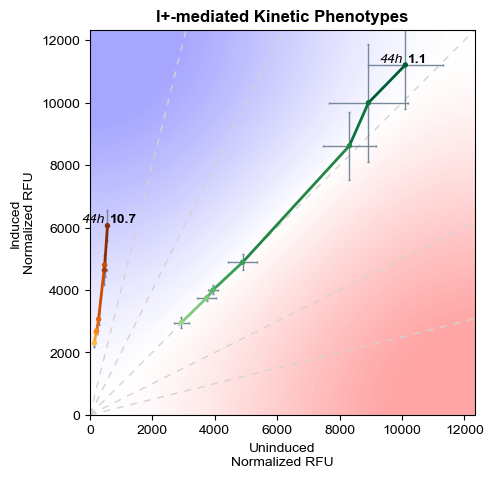

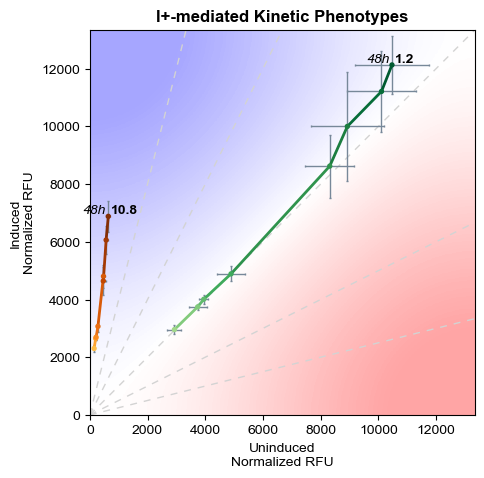

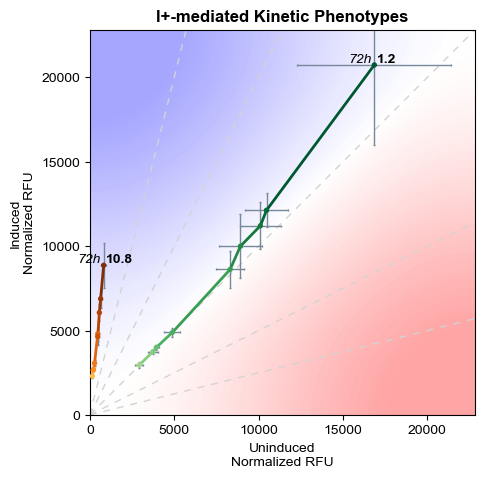

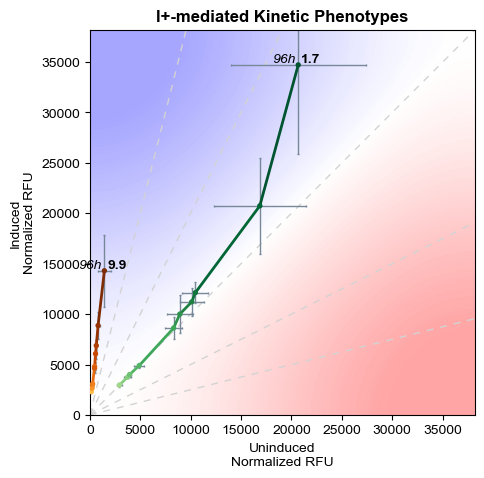

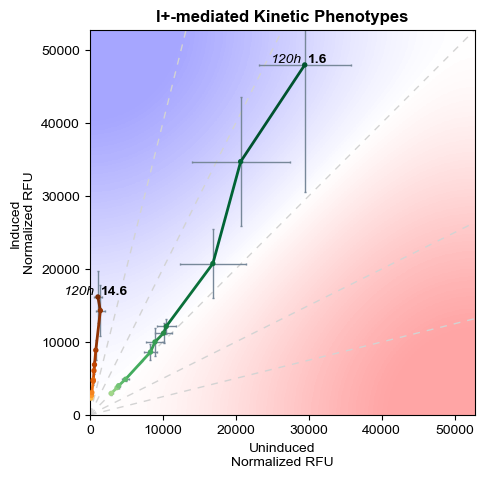

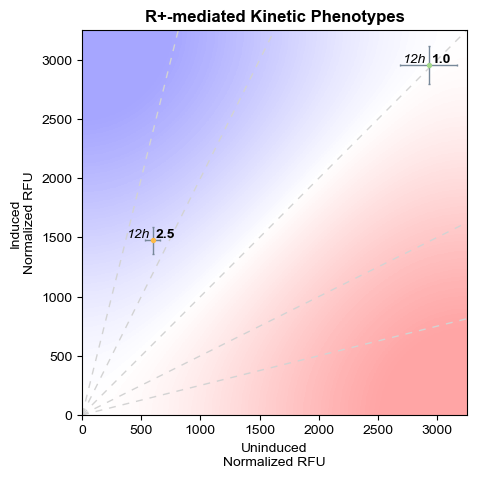

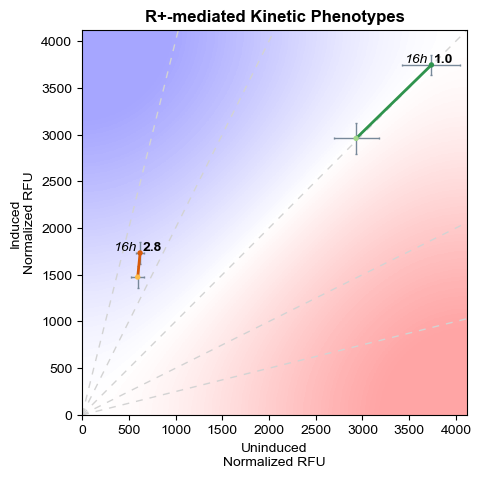

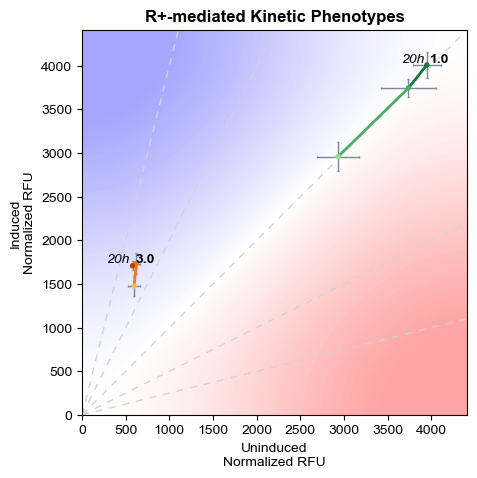

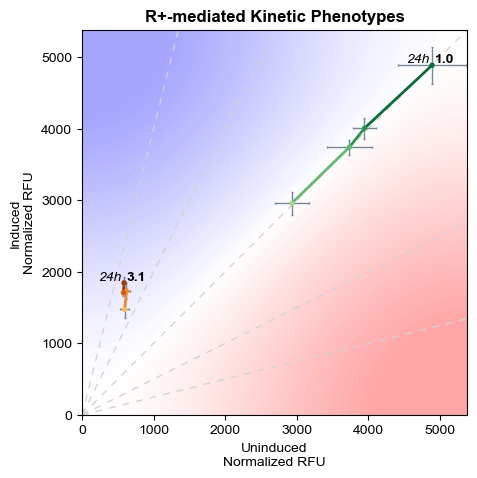

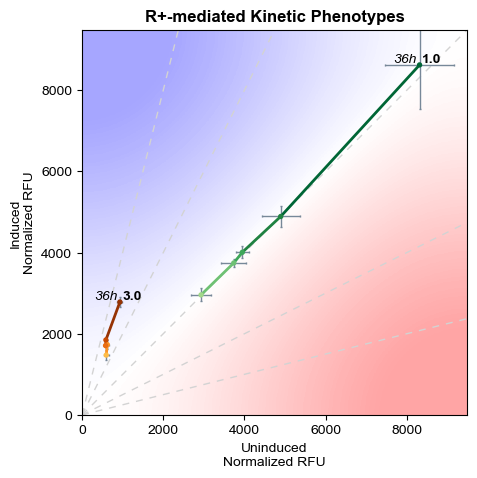

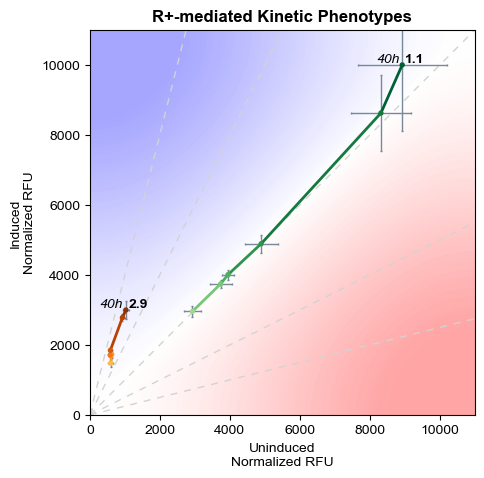

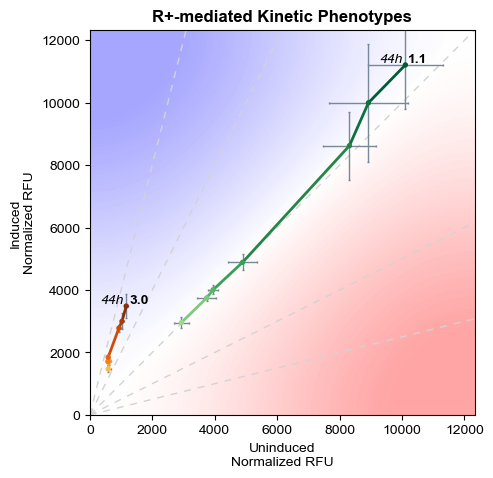

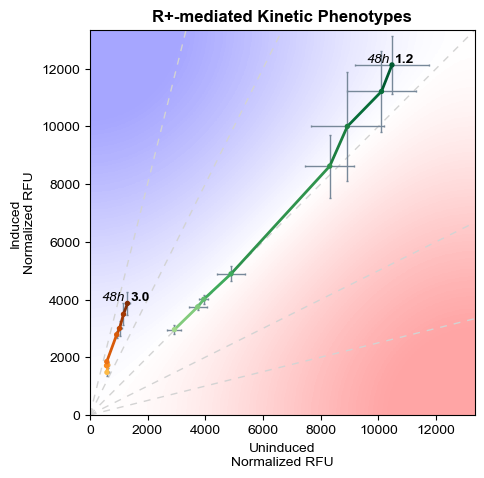

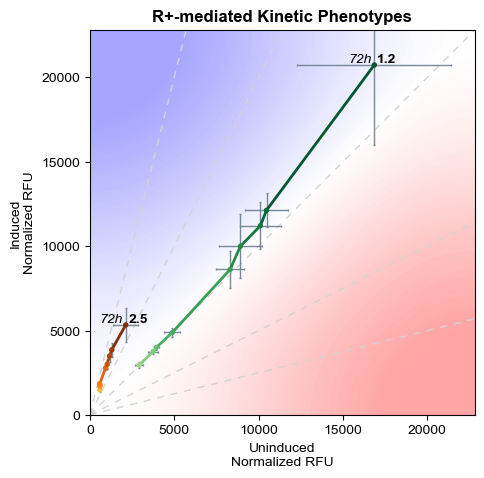

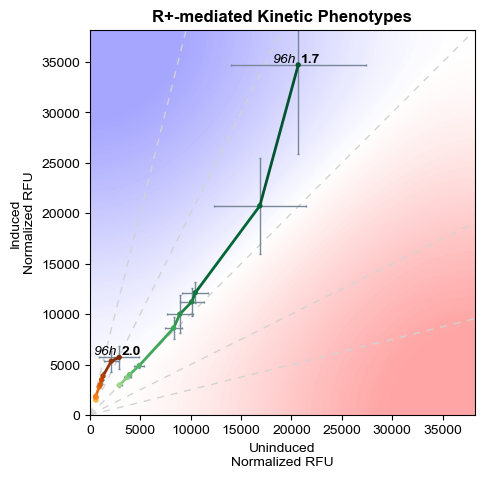

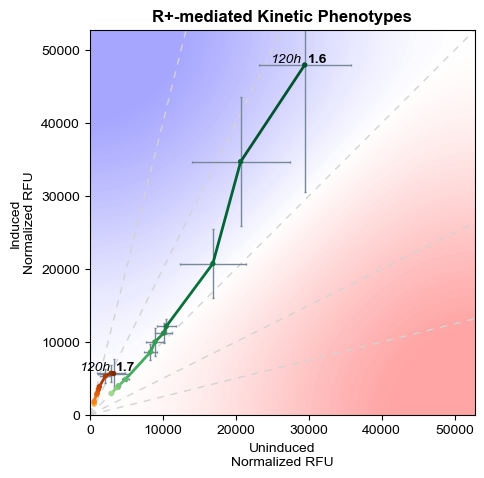

In [134]:
norm_FL = df_means.rowtrieve('Assay','Normalized Fluorescence').rowtrieve('Media','MSM').rowtrieve('Temperature','37°C')
global_xylim = max(norm_FL['Mean'].values)*1.1

pos_control = norm_FL.rowtrieve('Sample', 'Psyn14').induction_finder('Induction', 'IPTG')

for inducer in inducers:
    inducer_df = norm_FL.induction_finder('Induction',inducer)
    TF = IND_translate[inducer]
    grouping_keys = ['Sample','Media','Temperature']
    
    if inducer == 'IPTG':
        inducer_df = inducer_df.rowtrieve('Sample', 'Psyn14-O1P')
        
    if inducer == 'ribose':
        inducer_df = inducer_df.rowtrieve('Sample', 'Psyn14-OsymP')
        
    if 'Induction schedule' in inducer_df.columns:
        inducer_df = inducer_df.loc[inducer_df['Sample'] != 'Psyn14']
        grouping_keys.append('Induction schedule')

    for df_tuple in inducer_df.groupby(grouping_keys):
        df = df_tuple[1]
        
        cond_pos_control = pos_control
        PC_keys = grouping_keys.copy()
        PC_keys.remove('Sample')
        
        if 'Induction schedule' in df.columns:
            PC_keys.remove('Induction schedule')
        
        for cond, col in zip(df_tuple[0][1:], PC_keys):
            cond_pos_control = cond_pos_control.rowtrieve(col,cond)
            
        OFF_PC = cond_pos_control.induction_finder('Induction', '\+ 0 mM')
        ON_PC = cond_pos_control.induction_finder('Induction', '\+ 10 mM')
        
        OFF = df.induction_finder('Induction', '\+ 0 mM')
        ON = df.induction_finder('Induction', '\+ 10 mM')
        ON = ON.loc[~ON['Induction'].str.contains('@ 12h')]
        
        if 'Induction schedule' in df.columns:
            
            cond_OFF = inducer_df.copy()
            OFF_keys = grouping_keys.copy()
            remove_index = grouping_keys.index('Induction schedule')
            OFF_keys.remove('Induction schedule')
            OFF_values = list(df_tuple[0])
            OFF_values.pop(remove_index)
            
            
            for i in range(len(OFF_keys)):
                cond_OFF = cond_OFF.rowtrieve(OFF_keys[i],OFF_values[i])
        
            OFF_PC = cond_pos_control.rowtrieve('Induction schedule', '---')
            ON_PC = cond_pos_control.loc[cond_pos_control['Induction schedule'] != '---']   
            
            OFF = cond_OFF.rowtrieve('Induction schedule', '---')
            ON = df.loc[df['Induction schedule'] != '---']   
            
        for k in range(len(OFF)):
            j = k+1
            pretty_plotterator(df_tuple[1], tf = TF,\
                       xdata = OFF['Mean'][:j], ydata = ON['Mean'][:j], xSD = OFF['StDev'][:j], ySD = ON['StDev'][:j],\
                           xPC = OFF_PC['Mean'][:j], yPC = ON_PC['Mean'][:j], xSD_PC = OFF_PC['StDev'][:j], ySD_PC = ON_PC['StDev'][:j],\
                       title = df_tuple[0], annotate = True, draw_classes = False, global_window = False,\
                               plot_PC = True, plot_DRs = True)

#         plt.tight_layout()
        plt.show()

In [22]:
df_means.groupby(by=['Sample','Temperature','Induction','Media','Time']).mean()

C:\Users\sgowland3\AppData\Local\Temp\ipykernel_12700\3117437230.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_means.groupby(by=['Sample','Temperature','Induction','Media','Time']).mean()


Mean  \
Sample           Temperature Induction      Media Time                 
Psyn14           30°C        + 0 mM IPTG    M9    12.0   1652.002098   
                                                  16.0   2469.816844   
                                                  20.0   3254.874877   
                                                  24.0   4165.240921   
                                                  36.0   6148.800859   
...                                                              ...   
hyspank-ObsD-O1P 37°C        + 10 mM ribose MSM   44.0   5231.139691   
                                                  48.0   5673.714751   
                                                  72.0   6863.741706   
                                                  96.0   7604.069762   
                                                  120.0  9774.689627   

                                                               StDev  \
Sample           Temperature Induction      Media Time                 
Psyn14           30°C        + 0 mM IPTG    M9    12.0    258.394842   
                                                  16.0    346.278486   
                                                  20.0    368.036566   
                                                  24.0   1133.516126   
                                                  36.0   1064.043090   
...                                                              ...   
hyspank-ObsD-O1P 37°C        + 10 mM ribose MSM   44.0    463.298250   
                                                  48.0    443.207566   
                                                  72.0    501.295756   
                                                  96.0   1070.348765   
                                                  120.0  5712.203844   

                                                         Replicates  
Sample           Temperature Induction      Media Time               
Psyn14           30°C        + 0 mM IPTG    M9    12.0          5.0  
                                                  16.0          5.0  
                                                  20.0          5.0  
                                                  24.0          5.0  
                                                  36.0          5.0  
...                                                             ...  
hyspank-ObsD-O1P 37°C        + 10 mM ribose MSM   44.0          6.0  
                                                  48.0          6.0  
                                                  72.0          6.0  
                                                  96.0          6.0  
                                                  120.0         6.0  

[616 rows x 3 columns]

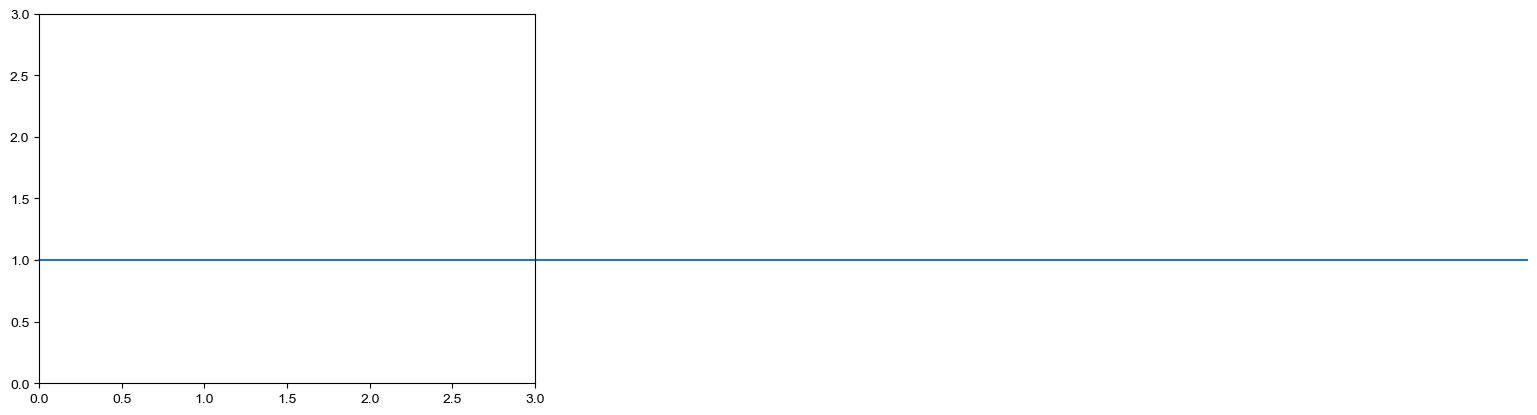

In [99]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(10)
y = np.ones_like(x)
plt.plot(x,y)[0].set_clip_on(False) # returns a sequence of line objects

plt.axis([0,3,0,3])
plt.show()

In [139]:
# print(list(IND_translate[key] for key in IND_translate.keys()))
print(df_means)

          Sample       Induction Media Induction schedule  I1   I2   I3  \
0         Psyn14    + 10 mM IPTG    M9                +--  0h  12h  24h   
0         Psyn14    + 10 mM IPTG    M9                +--  0h  12h  24h   
0         Psyn14    + 10 mM IPTG    M9                +--  0h  12h  24h   
0         Psyn14    + 10 mM IPTG    M9                ---  0h  12h  24h   
0         Psyn14    + 10 mM IPTG    M9                ---  0h  12h  24h   
..           ...             ...   ...                ...  ..  ...  ...   
0   Psyn14-OsymP  + 10 mM ribose   MSM                --+  0h  12h  24h   
0   Psyn14-OsymP  + 10 mM ribose   MSM                --+  0h  12h  24h   
0   Psyn14-OsymP  + 10 mM ribose   MSM                ---  0h  12h  24h   
0   Psyn14-OsymP  + 10 mM ribose   MSM                ---  0h  12h  24h   
0   Psyn14-OsymP  + 10 mM ribose   MSM                ---  0h  12h  24h   

   Temperature   Plate                    Assay  \
0         30°C  Plate2               Absorbance 

Figure(1280x1920)
[[<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]]


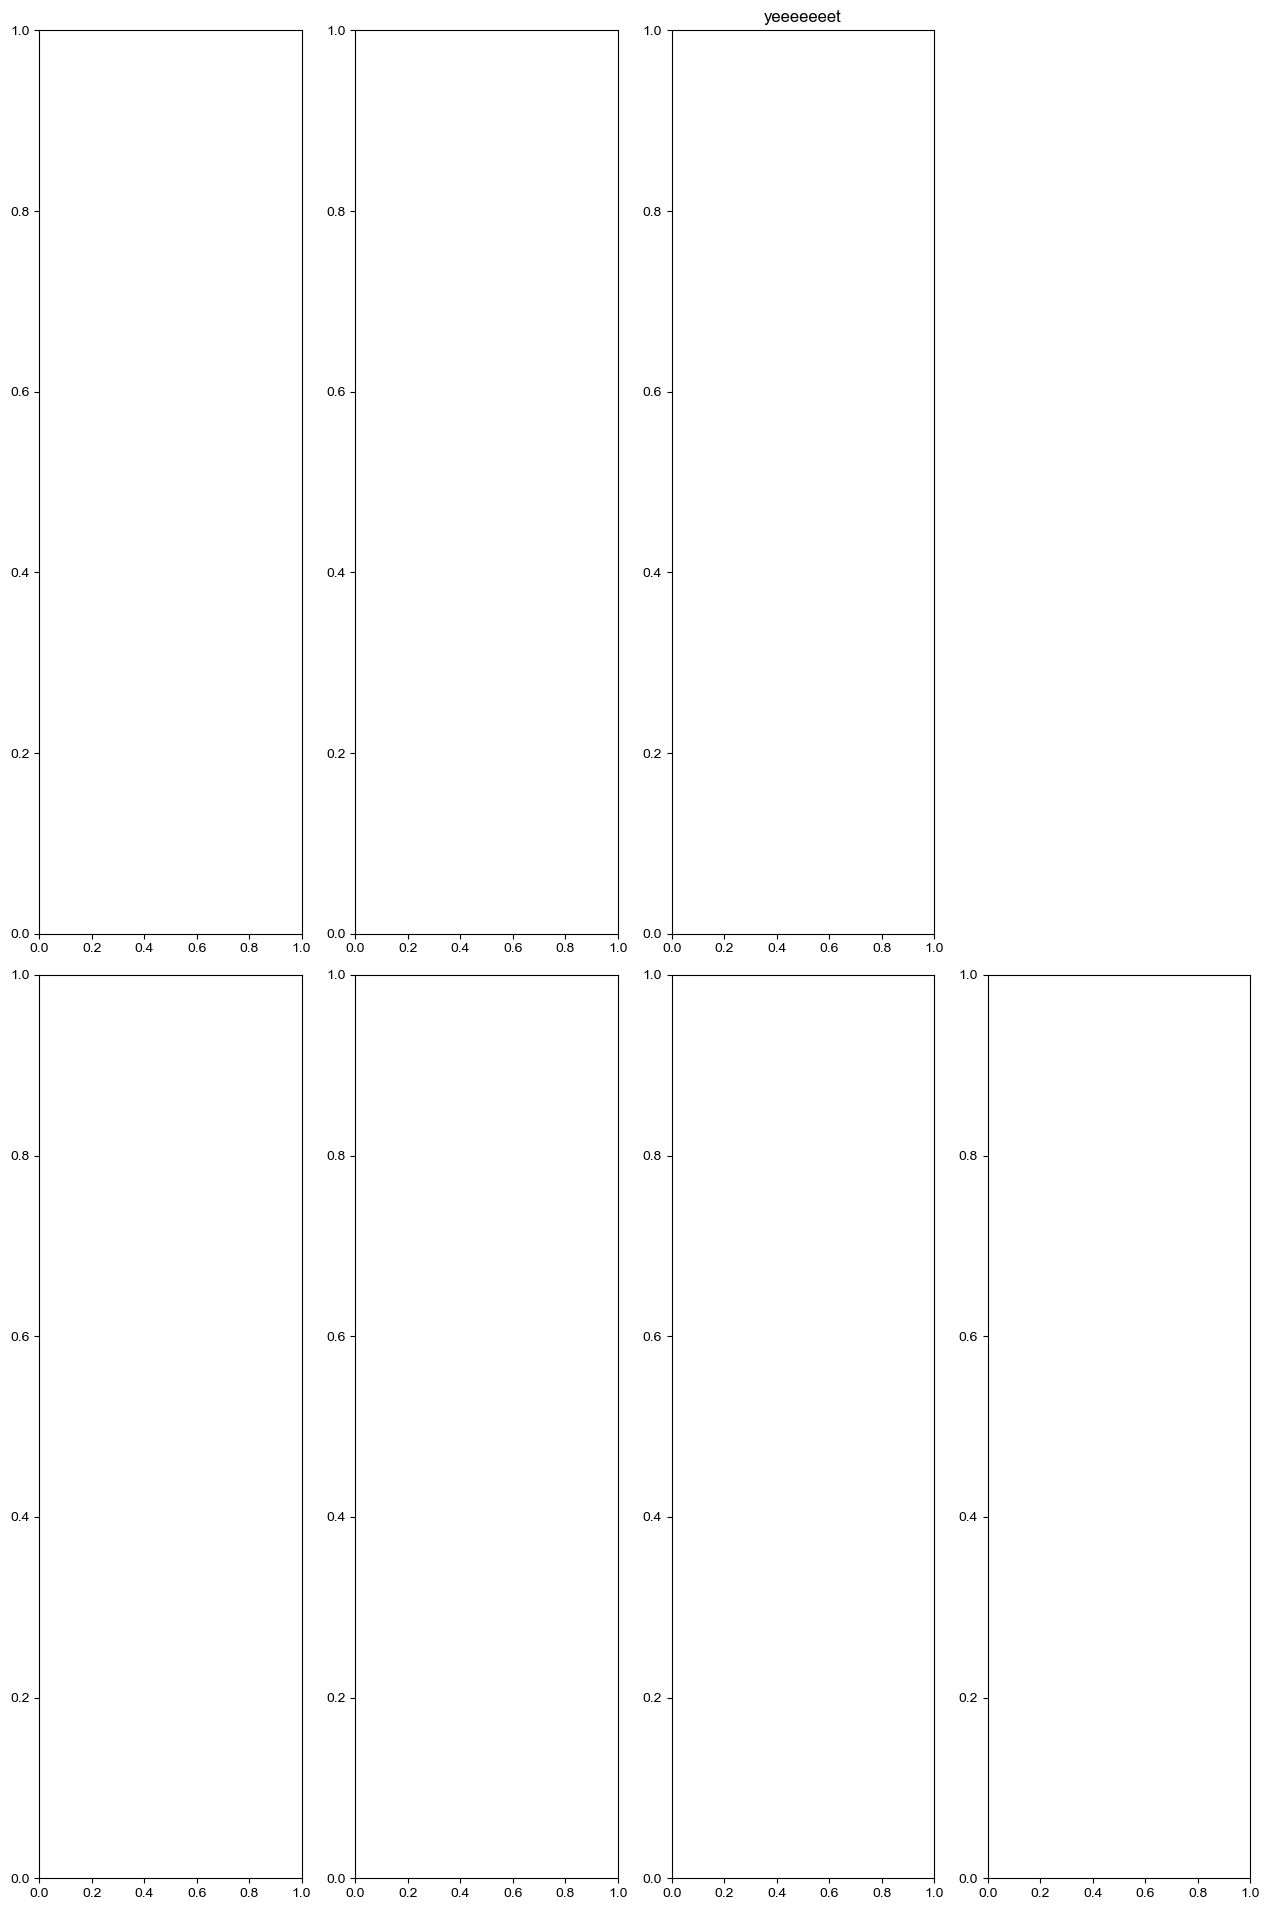

In [27]:
fig = plt.subplots(nrows=2, ncols=4, figsize = (6.4*2,4.8*4))
for x in fig:
    print(x)
ax = fig[1][0,2]
ax.set_title('yeeeeeeet')
ax = fig[1][0,3]
ax.set_visible(False)
plt.tight_layout()

In [82]:
def bar(word, yeet = None):
    word = word + 'wlwlwl'
    print(yeet)
    print(word)
    return word

def foo(fx):
#     bar('yoo')
    pass
foo(bar('eee', yeet = 5))

5
eeewlwlwl


In [41]:
groups = df_means.groupby(['Assay','Time'])
groups_keys = [name for name,df in groups]
print(groups_keys)

[('Absorbance', 12.0), ('Absorbance', 16.0), ('Absorbance', 20.0), ('Absorbance', 24.0), ('Absorbance', 36.0), ('Absorbance', 40.0), ('Absorbance', 44.0), ('Absorbance', 48.0), ('Absorbance', 72.0), ('Absorbance', 96.0), ('Absorbance', 120.0), ('Fluorescence', 12.0), ('Fluorescence', 16.0), ('Fluorescence', 20.0), ('Fluorescence', 24.0), ('Fluorescence', 36.0), ('Fluorescence', 40.0), ('Fluorescence', 44.0), ('Fluorescence', 48.0), ('Fluorescence', 72.0), ('Fluorescence', 96.0), ('Fluorescence', 120.0), ('Normalized Fluorescence', 12.0), ('Normalized Fluorescence', 16.0), ('Normalized Fluorescence', 20.0), ('Normalized Fluorescence', 24.0), ('Normalized Fluorescence', 36.0), ('Normalized Fluorescence', 40.0), ('Normalized Fluorescence', 44.0), ('Normalized Fluorescence', 48.0), ('Normalized Fluorescence', 72.0), ('Normalized Fluorescence', 96.0), ('Normalized Fluorescence', 120.0)]


In [5]:
def df_compress(self, columns, dimension):
    
    states = self[dimension].unique()
#     print(states)
    df_list = list(states)
    suffixes = ['_' + str(x) for x in df_list]
    print(suffixes)
    for i,state in enumerate(states):
        df_list[i] = self.rowtrieve(dimension, state)
#     print(df_list)
    
    df_0 = df_list[0]
    for df in df_list[1:]:
        df_0 = df_0.merge(df, on = columns, how = 'outer')
#     df_a = self.rowtrieve(dimension, False)
#     df_b = self.rowtrieve(dimension, True)
#     df_2 = df_a.merge(df_b, on = columns, how = 'outer')
    
    return df_0
    
pd.DataFrame.compress = df_compress

df_foo = df_means.copy()
df_foo['Induced'] = df_foo['Induction'].apply(lambda x: x.induced)
columns = [x for x in df_foo.columns if x not in ['Induction','Replicates','Induced','Mean','StDev']]
print(columns)
print(df_foo)
# print(df_compress(df_foo, columns, 'Induced'))
print(df_foo.compress(columns, 'Media'))


['Sample', 'Media', 'Temperature', 'Plate', 'Assay', 'Experiment', 'Time']
              Sample       Induction Media Temperature   Plate  \
0             Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0             Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0             Psyn14     + 0 mM IPTG    M9        30°C  Plate3   
0             Psyn14    + 10 mM IPTG    M9        30°C  Plate3   
0             Psyn14    + 10 mM IPTG    M9        30°C  Plate3   
..               ...             ...   ...         ...     ...   
0   hyspank-ObsD-O1P   + 0 mM ribose   MSM        37°C  Plate6   
0   hyspank-ObsD-O1P   + 0 mM ribose   MSM        37°C  Plate6   
0   hyspank-ObsD-O1P  + 10 mM ribose   MSM        37°C  Plate6   
0   hyspank-ObsD-O1P  + 10 mM ribose   MSM        37°C  Plate6   
0   hyspank-ObsD-O1P  + 10 mM ribose   MSM        37°C  Plate6   

                      Assay                                Experiment  \
0                Absorbance   20230928_▲11-▲27_kinetic_time

C:\Users\samgo\AppData\Local\Temp\ipykernel_7612\824722255.py:29: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  print(df_foo.compress(columns, 'Media'))


In [118]:
df_1 = pd.DataFrame({'a':[12,3,4,3,12,5],'b':[2,3,5,3,2,6], 'tf':[0,1,1,0,1,0]})
df_a = df_1.rowtrieve('tf',0)
df_b = df_1.rowtrieve('tf',1)

df_2 = df_a.merge(df_b, on = ['a','b'], how = 'inner')

print(df_1)
print(df_a)
print(df_b)
print(df_2)


    a  b  tf
0  12  2   0
1   3  3   1
2   4  5   1
3   3  3   0
4  12  2   1
5   5  6   0
    a  b  tf
0  12  2   0
3   3  3   0
5   5  6   0
    a  b  tf
1   3  3   1
2   4  5   1
4  12  2   1
    a  b  tf_x  tf_y
0  12  2     0     1
1   3  3     0     1


In [18]:
a = Induction('+10 mM IPTG')
b = Induction('+10 mM IPTG')
y = 'string'
z = 'string'

bar = [a,b]

for x in bar:
    print(hash(x))
if a == b:
    print('yee')
if y == z:
    print('zee')
if a.induced == b.induced:
    print('flea')

6083586314777201675
6083586314777201675
yee
zee
flea


   Sample       Induction Media Induction schedule  I1   I2   I3 Temperature  \
0  Psyn14  + 10 mM ribose    M9                ---  0h  12h  24h        30°C   

    Plate       Assay                                Experiment      Mean  \
0  Plate1  Absorbance  20230928_R+_I+_deep_induction_course_12h  0.338914   

      StDev  Replicates  Time  
0  0.003337           4  12.0  
   Sample       Induction Media Induction schedule  I1   I2   I3 Temperature  \
0  Psyn14  + 10 mM ribose    M9                +--  0h  12h  24h        30°C   

    Plate       Assay                                Experiment      Mean  \
0  Plate1  Absorbance  20230928_R+_I+_deep_induction_course_12h  0.418289   

      StDev  Replicates  Time  
0  0.016687           4  12.0  
1
   Sample       Induction Media Induction schedule  I1   I2   I3 Temperature  \
0  Psyn14  + 10 mM ribose    M9                ---  0h  12h  24h        30°C   

    Plate       Assay                                Experiment      Mean  \


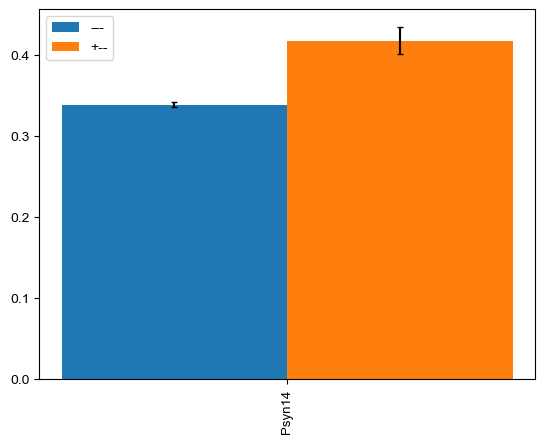

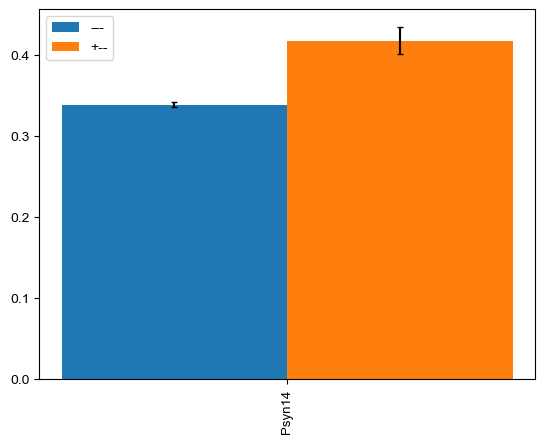

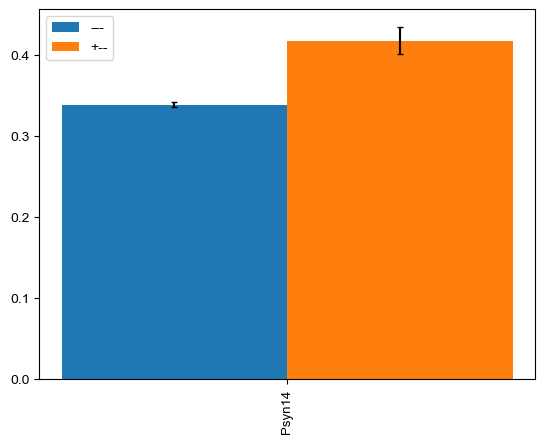

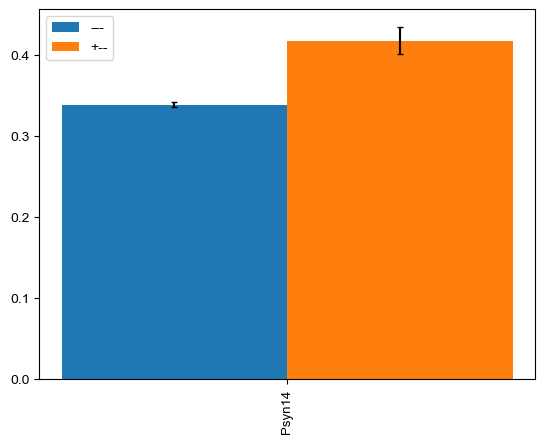

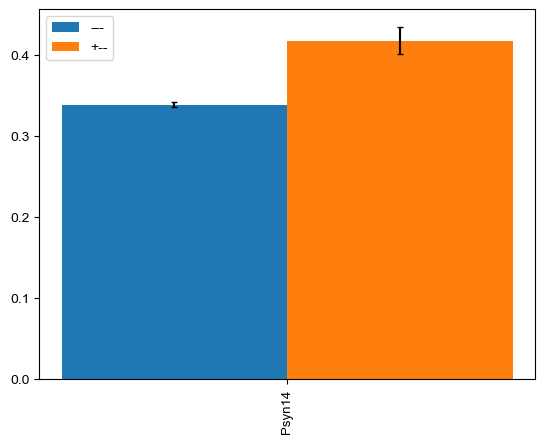

In [11]:
df_foo = df_means.copy()
sort_columns = [x for x in df_foo.columns if x not in ['Induction','Induction schedule','Induced','Replicates','Mean','StDev']]
sort_columns.reverse()
df_foo.sort_values(by=sort_columns, inplace = True)
# print(df_foo['Induction'].apply(lambda x: x.induced))
# print(df_foo.loc[df_foo['Induction'].apply(lambda x: x.induced)])
# df_foo['Induced'] = df_foo['Induction'].apply(lambda x: x.induced)
 
a=0
for i, df in df_foo.groupby(sort_columns):
    while a<5:

        expt = df.loc[df['Induction'].apply(lambda x: x.induced)]
        NC = df.loc[~df['Induction'].apply(lambda x: x.induced)]

        fig, ax = plt.subplots()
        width = 1/(np.sum([expt.shape[0],NC.shape[0]])+1.2)
        multiplier = 0
        fontsize = 12
        
        if expt.shape[0] == NC.shape[0]:
            plot_type = 'collated'
        if expt.shape[0] != NC.shape[0]:
            plot_type = 'grouped'

        if plot_type == 'collated':
            for twobardf in [NC,expt]:
                print(twobardf)
                x = np.arange(len(twobardf.index))     
                offset = width*multiplier
                means = twobardf['Mean']
                if twobardf['Induction'].apply(lambda x: x.schedule).unique() != ['unscheduled']:
                    cond = list(twobardf['Induction'].apply(lambda x: x.schedule))
                else:
                    cond = list(twobardf['Induction'].apply(lambda x: x.string))
                    
                stdevs = twobardf['StDev']
                names = twobardf['Sample'].unique()
                
                rects = ax.bar(x + offset, means, width, label=cond, yerr=stdevs)
                multiplier += 1 
        
            x_locs = x + (np.sum([expt.shape[0],NC.shape[0]])-1)*width/2
            ax.set_xticks(x_locs, names, rotation = 'vertical', size = fontsize*0.8)
            ax.legend()
            
        if plot_type == 'grouped':
            print(df)
            ax.bar(x = np.arange(len(df.index)), height = df['Mean'], yerr = df['StDev'])
#         expt.plot(kind = 'bar', y = 'Mean')
        
        a+=1
        print(a)
#     for index in expt:
#         print(expt[index])
#     expt = df_sampconds.rowtrieve('Induced',True)
    
#     print(NC)
#     print(df)
